In [9]:
import numpy as np
import qutip as qt
import scipy as sp
import scipy.linalg as spla
import scipy.sparse as sps
import scipy.sparse.linalg as spsla
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import pickle
from tqdm import tqdm
import os
import plotsmodule
from plotsmodule import *
from joblib import Parallel, delayed
import json
import sBs
import bits
import metrology
import importlib
import backaction
importlib.reload(plotsmodule)
importlib.reload(sBs)
importlib.reload(bits)
importlib.reload(metrology)
importlib.reload(backaction)
from sBs import *
from bits import *
from metrology import *
from backaction import *

In [10]:
path = os.getcwd()
path_sBs = path + '/sBs-noiseless/'
path_sbs_noise = path + '/sbs-noise/'
path_sbs_noise_figures = path_sbs_noise + "/Figures/"
path_sBs_MP = path_sBs + '/metrological potential/'
path_sBs_MP_FI = path_sBs_MP + '/FI/'
path_sBs_MP_filter = path_sBs_MP_FI + '/filter/'
path_sBs_MP_ML = path_sBs_MP + '/maximum likelihood/'
path_sBs_MP_BA = path_sBs_MP + '/backaction/'
path_figures = path_sBs + '/figures/'
path_figures_data = path_sBs + '/figures/data/'
path_data_sBs = path_sBs+'/sBs/'
path_data_sBs_sensor = path_sBs+'/sBs/sensor/'
path_data_sBs_probabilities = path_sBs+'/sBs/probabilities/'
path_sBs_bayesian = path_sBs+"/data/bayesian/"
path_posters = path+"/posters/"
os.makedirs(path_sBs_MP, exist_ok=True)
os.makedirs(path_sBs_MP_FI, exist_ok=True)
os.makedirs(path_sBs_MP_filter, exist_ok=True)
os.makedirs(path_sBs_MP_ML, exist_ok=True)
os.makedirs(path_sBs_MP_BA, exist_ok=True)
os.makedirs(path_sBs_bayesian, exist_ok=True)

# Fisher Information with averaged map

## FI of the q quadrature as a function of q0 and number of rounds

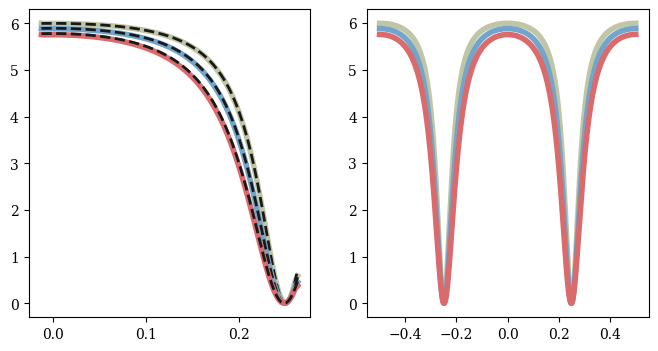

In [12]:
def FI_analytical(q,Delta):
    cd = np.cosh(Delta**2)
    a = 0.4
    numerator =  np.exp(-2*a*Delta**2)*l**2*cd**2*np.cos(l*cd*q)**2 
    denominator = 1-np.sin(l*cd*q)**2*np.exp(-2*a*Delta**2)
    return numerator/denominator

Delta_range = [.25,.3,.35]
fig, axs = plt.subplots(1,2,figsize=(8,4))
ax1, ax2 = axs
R1, k, steps, l = 15, 0, 111, np.sqrt(2*np.pi)
q0_range = (l/4)*np.linspace(-.05,1.05,steps)
T = 1
colors = [lighten_color(green,.6),lighten_color(blue,.6),lighten_color(red,.6)]
for j in range(3):
    Delta = Delta_range[j]
    name_probs = 'probabilities_Delta={0:.2f}_R={1:.0f}_p0=lover{2:.0f}_q0_steps={2:.0f}'.format(Delta,R1,k,steps)
    probs_qp0 = np.load(path_data_sBs_probabilities+name_probs+'.npy')
    FIqT = FI_qq_T(probs_qp0,R1,q0_range,T,steps)
    ax1.plot(q0_range/l,FIqT,color=colors[j],label=r'$\Delta={0:.2f}$'.format(Delta),lw=4)
    ax1.plot(q0_range/l,FI_analytical(q0_range,Delta),ls='--',color=lighten_color('black',.9),lw=2)

steps = 401
q0_range = (l/2)*np.linspace(-1.0,1.0,steps)
T = 1
colors = [lighten_color(green,.6),lighten_color(blue,.6),lighten_color(red,.6)]
for j in range(3):
    Delta = Delta_range[j]
    name_probs = 'probabilities_Delta={0:.2f}_R={1:.0f}_p0=lover{2:.0f}_q0range(-lover2,lover2)_steps={2:.0f}'.format(Delta,R1,k,steps)
    probs_qp0 = np.load(path_data_sBs_probabilities+name_probs+'.npy')
    FIqT = FI_qq_T(probs_qp0,R1,q0_range,T,steps)
    ax2.plot(q0_range/l,FIqT,color=colors[j],label=r'$\Delta={0:.2f}$'.format(Delta),lw=4,ls='-')
    # ax1.plot(q0_range/l,FI_analytical(q0_range,Delta),ls='--',color=lighten_color('black',.9),lw=2)

# Maximum likelihood of the averaged map

### Constructing the likelihoods

In [13]:
Delta = .3
R1, k, steps, l = 15, 0, 101, np.sqrt(2*np.pi)
cd = np.cosh(Delta**2)
q0_range = (l/4/cd)*np.linspace(-1.0,1.0,steps)
T_range = [2]
for T in T_range:
    name_probs = 'probabilities_Delta={0:.2f}_R={1:.0f}_p0=lover{2:.0f}_q0range(-lover4,lover4)_steps={3:.0f}'.format(Delta,R1,k,len(q0_range))
    probs_qp0 = np.load(path_data_sBs_probabilities+name_probs+'.npy')
    ML = ML_q0(probs_qp0,R1,q0_range,T,steps)
    for b in range(2**T):
        print(int_to_r_bits(b,T),np.round(ML[b],3))

00 0.624
01 0.037
10 -0.037
11 -0.624


### MSE of ML

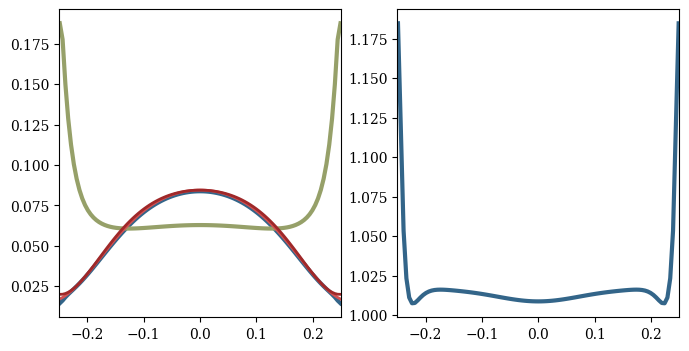

In [14]:
Delta = .3
cd = np.cosh(Delta**2)
fig, axs = plt.subplots(1,2,figsize=(8,4))
ax1, ax2 = axs
R1, k, steps, l = 16, 0, 101, np.sqrt(2*np.pi)
q0_range = (l/4/cd)*np.linspace(-1.0,1.0,steps)
T_range = [4]
for T in T_range:
    name_probs = 'probabilities_Delta={0:.2f}_R={1:.0f}_p0=lover{2:.0f}_q0range(-lover4,lover4)_steps={2:.0f}'.format(Delta,R1,k,steps)
    probs_qp0 = np.load(path_data_sBs_probabilities+name_probs+'.npy')
    MSE, biases, partial_means, Var = MSE_ML_q0(probs_qp0,R1,q0_range,T,steps)
    FIqT = FI_qq_T(probs_qp0,R1,q0_range,T,steps)
    ax1.plot(q0_range/l, partial_means**2/FIqT,color=blue,lw=3)
    ax1.plot(q0_range/l, 1/FIqT,color=green,lw=3)

    # ax1.plot(q0_range/l, FIqT,color=green,lw=3)
    # ax.plot(q0_range/l,FI_analytical(q0_range,Delta),ls='--',color=lighten_color('black',.9),lw=2)
    ax1.plot(q0_range/l,MSE-biases**2,ls='-',color=lighten_color(red,.7),lw=2)
    ax1.plot(q0_range/l,MSE,ls='-',color=lighten_color(red,1),lw=2)
    ax2.plot(q0_range/l,(MSE-biases**2)*FIqT/partial_means**2,color=blue,lw=3)
    ax2.set_xlim(-.25,.25)
    ax1.set_xlim(-.25,.25)

### Sensitivity of ML

[0.98753348 0.98280038 0.97405376 0.96166267 0.94610411 0.92792518
 0.90770418 0.88601629 0.86340482 0.84036109 0.81731121 0.79461073
 0.77254394 0.75132825 0.73112025]
1 -0.035
squeezing parameter r: 0.46735582791521796 gain: 1.2347945427922626 dB: 4.059401142978098 Max MSE: 0.39269908169872403
[0.98753348 0.98280038 0.97405376 0.96166267 0.94610411 0.92792518
 0.90770418 0.88601629 0.86340482 0.84036109 0.81731121 0.79461073
 0.77254394 0.75132825 0.73112025]
4 -0.16999999999999998
squeezing parameter r: 1.2246470186209981 gain: 3.4166307982799182 dB: 10.637148849327367 Max MSE: 0.08635452806640101
[0.98753348 0.98280038 0.97405376 0.96166267 0.94610411 0.92792518
 0.90770418 0.88601629 0.86340482 0.84036109 0.81731121 0.79461073
 0.77254394 0.75132825 0.73112025]
5 -0.18
squeezing parameter r: 1.3317481629422383 gain: 4.104016288564932 dB: 11.567417569012136 Max MSE: 0.06970408700240362
as a reference for e^(-2r)=1/2, r is: 0.34657359027997264 gain: 1.1249999999999998 dB: 3.01029995

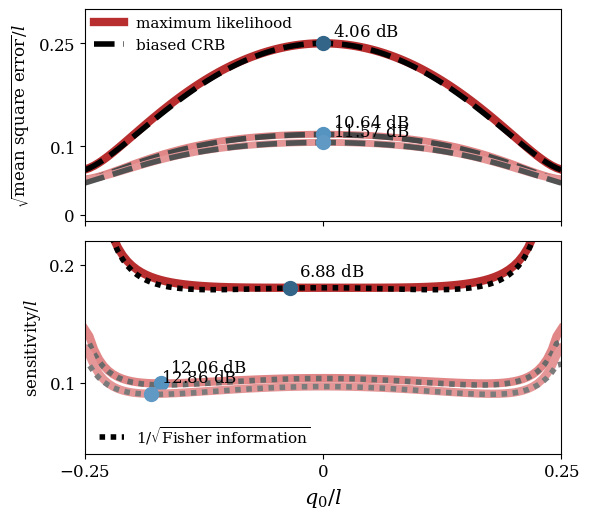

In [ ]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['DejaVu Serif'],
    'mathtext.fontset': 'dejavuserif'
})
Delta = .25
cd = np.cosh(Delta**2)
fig, axs = plt.subplots(2,1,figsize=(6,5.3),sharex=True)
ax1, ax2 = axs
R1, k, steps, l = 15, 0, 101, np.sqrt(2*np.pi)
q0_range = (l/4)*np.linspace(-1.0,1.0,steps)
T_range = [1,4,5]
for T in T_range:
    name_probs = 'probabilities_Delta={0:.2f}_R={1:.0f}_p0=lover{2:.0f}_q0range(-lover4,lover4)_steps={3:.0f}'.format(Delta,R1,k,steps)
    probs_qp0 = np.load(path_data_sBs_probabilities+name_probs+'.npy')
    print(probs_qp0[-1][0])

    MSE, biases, partial_means, Var = MSE_ML_q0(probs_qp0,R1,q0_range,T,steps)
    FIqT = FI_qq_T(probs_qp0,R1,q0_range,T,steps)
    # ax1.plot(q0_range/l,MSE-biases**2,ls='-',color=lighten_color(red,.7),lw=2)
    # ax1.plot(q0_range/l, np.sqrt(1/FIqT)/l,color=lighten_color('black',shine),lw=3,ls='--')
    if T==1:
        ax1.plot(q0_range/l,np.sqrt(MSE)/l,ls='-',color=lighten_color(red,shine),lw=6,label='maximum likelihood')
        ax1.plot(q0_range/l, np.sqrt(partial_means**2/FIqT)/l,color=lighten_color('black',1-.2*np.log(T)),lw=4,ls='--',label='biased CRB')
    else:
        ax1.plot(q0_range/l,np.sqrt(MSE)/l,ls='-',color=lighten_color(red,shine),lw=5)
        ax1.plot(q0_range/l, np.sqrt(partial_means**2/FIqT)/l,color=lighten_color('black',1-.2*np.log(T)),lw=4,ls='--')

    # ax2.plot(q0_range/l, Var/partial_means**2,color=blue,lw=3)
    sensitivity = np.sqrt(MSE/partial_means**2)
    if T==1:
        ax2.plot(q0_range/l, sensitivity/l,color=lighten_color(red,shine),lw=6)
        ax2.plot(q0_range/l, np.sqrt(1/FIqT)/l,color=lighten_color('black',shine),lw=4,ls=(1,(1,1)),label=r'1/$\sqrt{\text{Fisher information}}$')
    else:
        ax2.plot(q0_range/l, sensitivity/l,color=lighten_color(red,shine),lw=6)
        ax2.plot(q0_range/l, np.sqrt(1/FIqT)/l,color=lighten_color('black',shine),lw=4,ls=(1,(1,1)))
    print(T,q0_range[np.argmin(MSE/partial_means**2)]/l)


    r = np.log(1/np.sqrt(np.max(MSE)))
    dB = 10*np.log10(np.exp(2*r))
    gain = np.cosh(r)**2
    rs = np.log(1/np.min(sensitivity))
    dBs = 10*np.log10(np.exp(2*rs))
    print('squeezing parameter r:',r, 'gain:',gain, 'dB:',10*np.log10(np.exp(2*r)),'Max MSE:',np.max(MSE))
    if T==14:
        ax1.text(q0_range[np.argmax(MSE)]/l+.01,np.sqrt(MSE[np.argmax(MSE)])/l-.03,r'${0:.2f}$ dB'.format(dB),fontsize=12)
        ax1.plot(q0_range[np.argmax(MSE)]/l,np.sqrt(MSE[np.argmax(MSE)])/l,'o',color=lighten_color(blue,1-.2*np.log(T)),markersize=10,label='tSU(1,1)')
        ax2.text(q0_range[np.argmin(sensitivity)]/l+.01,sensitivity[np.argmin(sensitivity)]/l-.03,r'${0:.2f}$ dB'.format(dBs),fontsize=12)
        ax2.plot(q0_range[np.argmin(sensitivity)]/l,sensitivity[np.argmin(sensitivity)]/l,'o',color=lighten_color(blue,1-.2*np.log(T)),markersize=10)


    else:
        ax1.text(q0_range[np.argmax(MSE)]/l+.01,np.sqrt(MSE[np.argmax(MSE)])/l+.01,r'${0:.2f}$ dB'.format(dB),fontsize=12)
        ax1.plot(q0_range[np.argmax(MSE)]/l,np.sqrt(MSE[np.argmax(MSE)])/l,'o',color=lighten_color(blue,1-.2*np.log(T)),markersize=10)
        ax2.text(q0_range[np.argmin(sensitivity)]/l+.01,sensitivity[np.argmin(sensitivity)]/l+.01,r'${0:.2f}$ dB'.format(dBs),fontsize=12)
        ax2.plot(q0_range[np.argmin(sensitivity)]/l,sensitivity[np.argmin(sensitivity)]/l,'o',color=lighten_color(blue,1-.2*np.log(T)),markersize=10)



r_half = np.log(2)/2
r_10 = np.log(10)/2
r_20 = np.log(20)/2
r_40 = np.log(40)/2
print('as a reference for e^(-2r)=1/2, r is:',r_half,'gain:',np.cosh(r_half)**2, 'dB:',10*np.log10(np.exp(2*r_half)))
print('as a reference for e^(-2r)=1/10, r is:',r_10,'gain:',np.cosh(r_10)**2, 'dB:',10*np.log10(np.exp(2*r_10)))
print('as a reference for e^(-2r)=1/20, r is:',r_20,'gain:',np.cosh(r_20)**2, 'dB:',10*np.log10(np.exp(2*r_20)))
ax1.set_ylim(-0.01,.3)
ax1.set_xlim(-.25,.25)
ax2.set_ylim(0.04,.22)
ax2.set_xlim(-.25,.25)
xticks = [-1/4,0,1/4]
xlabels = [r'$-0.25$',r'$0$',r'$0.25$']
ax2.set_xticks(xticks)
ax2.set_xticklabels(xlabels,fontsize=12)
ax2.set_xlabel(r'$q_0/l$',fontsize=15)
y1ticks = [0,.1,.25]
y1labels = [r'$0$',r'$0.1$',r'$0.25$']
ax1.set_yticks(y1ticks)
ax1.set_yticklabels(y1labels,fontsize=12)
y2ticks = [.1,.2]
y2labels = [r'$0.1$',r'$0.2$']
ax2.set_yticks(y2ticks)
ax2.set_yticklabels(y2labels,fontsize=12)
ax1.set_ylabel(r'$\sqrt{\text{mean square error}}/l$',fontsize=12)
ax2.set_ylabel(r'$\text{sensitivity}/l$',fontsize=12)
ax1.legend(fontsize=11,loc='upper left',framealpha=0,bbox_to_anchor=(-0.01,1.03))
ax2.legend(fontsize=11,loc='lower left',framealpha=0,bbox_to_anchor=(-0.01,-0.03))

plt.tight_layout()
name = 'Paper-Fig3-ML-MSE-sensitivity'
plt.savefig(path_figures+name+'.pdf',bbox_inches='tight',dpi=1000)

# Fisher Information with map of each bitstring

## auxiliary functions

## Constructing the Fisher

In [ ]:
# Delta, k, steps, R = 0.3,0,101,4
# T = 4
# q0_range = (l/4)*np.linspace(-1.0,1.0,steps)
# name = 'probs_allbits_p0=lover{0:.2f}_qrange(-lover4,lover4)_steps={0:.0f}_Delta={1:.2f}_T={2:.0f}'.format(k,steps,Delta,R)#D\equiv /, division
# probs_qp0_allbits = np.load(path_data_sBs_probabilities+name+'.npy')

# fig, ax = plt.subplots(1,1,figsize=(4,4))
# T_range = [1,2,3,4]
# for T in T_range:
#     FIqT = FI_qq_T_fullmap(probs_qp0_allbits,q0_range,R,T,steps)
#     ax.plot(q0_range/l,FIqT,color=lighten_color(blue,shine),lw=3)
#     ax.plot(q0_range/l,FI_analytical(q0_range,Delta),ls='--',color=lighten_color('black',.9),lw=2)

# Maximumum likelihood with map of each bitstring

## Constructing the likelihoods

In [17]:
Delta, k, steps, R = 0.3,0,101,4
cd = np.cosh(Delta**2)
T = 4
q0_range = (l/4/cd)*np.linspace(-1.0,1.0,steps)
name = 'probs_allbits_p0=lover{0:.2f}_qrange(-lover4,lover4)_steps={0:.0f}_Delta={1:.2f}_T={2:.0f}'.format(k,steps,Delta,R)#D\equiv /, division
probs_qp0_allbits = np.load(path_data_sBs_probabilities+name+'.npy')
print(probs_qp0_allbits.shape)
T_range = [2]
for T in T_range:
    ML = ML_q0_fullmap(probs_qp0_allbits,R,q0_range,T,steps)
    print(ML)
    for b in range(2**(2*T)):
        print(int_to_r_bits(b,2*T)[0::2],np.round(ML[b],3))

(101, 256)
[ 0.62412765  0.62412765  0.02496511  0.02496511  0.62412765  0.62412765
  0.02496511  0.02496511 -0.02496511 -0.02496511 -0.62412765 -0.62412765
 -0.02496511 -0.02496511 -0.62412765 -0.62412765]
00 0.624
00 0.624
01 0.025
01 0.025
00 0.624
00 0.624
01 0.025
01 0.025
10 -0.025
10 -0.025
11 -0.624
11 -0.624
10 -0.025
10 -0.025
11 -0.624
11 -0.624


## MSE ML

In [18]:
# Delta = .3
# cd = np.cosh(Delta**2)
# fig, axs = plt.subplots(1,2,figsize=(8,4))
# ax1, ax2 = axs
# R1, k, steps, l = 4, 0, 101, np.sqrt(2*np.pi)
# q0_range = (l/4/cd)*np.linspace(-1.0,1.0,steps)
# T_range = [1,2,3]
# name = 'probs_allbits_p0=lover{0:.2f}_qrange(-lover4,lover4)_steps={0:.0f}_Delta={1:.2f}_T={2:.0f}'.format(k,steps,Delta,R)#D\equiv /, division
# probs_qp0_allbits = np.load(path_data_sBs_probabilities+name+'.npy')
# for T in T_range:
#     MSE, biases, partial_means, Var = MSE_ML_q0_fullmap(probs_qp0_allbits,R1,q0_range,T,steps)
#     FIqT = FI_qq_T_fullmap(probs_qp0_allbits,q0_range,R1,T,steps)
#     ax1.plot(q0_range/l, np.sqrt(partial_means**2/FIqT)/l,color=blue,lw=3)
#     ax1.plot(q0_range/l, np.sqrt(1/FIqT)/l,color=green,lw=3)

#     # ax1.plot(q0_range/l, FIqT,color=green,lw=3)
#     # ax.plot(q0_range/l,FI_analytical(q0_range,Delta),ls='--',color=lighten_color('black',.9),lw=2)
#     ax1.plot(q0_range/l,np.sqrt(MSE-biases**2)/l,ls='-',color=lighten_color(red,.7),lw=2)
#     ax1.plot(q0_range/l,np.sqrt(MSE)/l,ls='-',color=lighten_color(red,1),lw=2)
#     ax2.plot(q0_range/l,(MSE-biases**2)*FIqT/partial_means**2,color=blue,lw=3)
#     ax2.set_xlim(-.25,.25)
#     ax1.set_xlim(-.25,.25)
#     ax1.set_ylim(-0.01,.3)
#     ax2.set_ylim(.99,1.01)

## sensitivity ML

1 0.0
squeezing parameter r: 0.46735558514729314 gain: 1.2347942813579977 dB: 7.695069697941735 sensitivity: 0.41233150111618433
average MSE 0.21438184389670314 3.4176712512691636
2 0.0
squeezing parameter r: 0.8130959071105482 gain: 1.8202880775630084 dB: 10.103809783043312 sensitivity: 0.31247085147248266
average MSE 0.11607178688119692 0.15656021612440724
4 0.0
squeezing parameter r: 1.2601101945198367 gain: 3.62794449205189 dB: 11.966989909540619 sensitivity: 0.2521450835701147
average MSE 0.06103670171852785 0.07670259127633282
as a reference for e^(-2r)=1/2, r is: 0.34657359027997264 gain: 1.1249999999999998 dB: 3.010299956639812
as a reference for e^(-2r)=1/10, r is: 1.151292546497023 gain: 3.0250000000000004 dB: 10.0
as a reference for e^(-2r)=1/20, r is: 1.4978661367769954 gain: 5.512499999999999 dB: 13.01029995663981


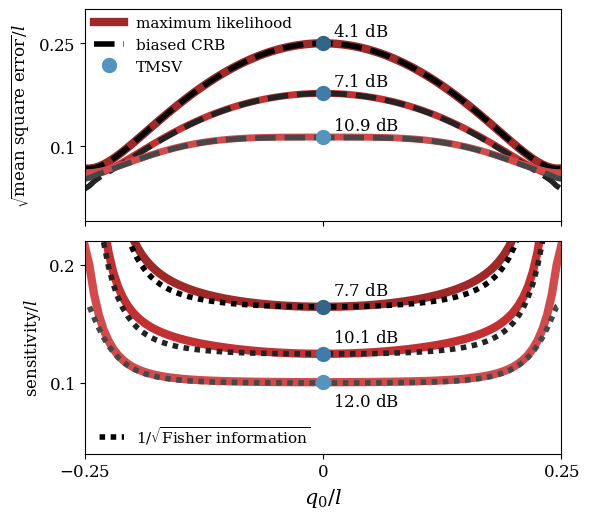

In [9]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['DejaVu Serif'],
    'mathtext.fontset': 'dejavuserif'
})
Delta = .3
cd = np.cosh(Delta**2)
fig, axs = plt.subplots(2,1,figsize=(6,5.3),sharex=True)
ax1, ax2 = axs
R1, k, steps, l = 4, 0, 101, np.sqrt(2*np.pi)
q0_range = (l/4)*np.linspace(-1.0,1.0,steps)
T_range = [1,2,4]
for T in T_range:
    
    name = 'probs_allbits_p0=lover{0:.2f}_qrange(-lover4,lover4)_steps={1:.0f}_Delta={2:.2f}_T={3:.0f}'.format(k,steps,Delta,R1)#D\equiv /, division
    probs_qp0_allbits = np.load(path_data_sBs_probabilities+name+'.npy')

    MSE, biases, partial_means, Var = MSE_ML_q0_fullmap(probs_qp0_allbits,R1,q0_range,T,steps)
    FIqT = FI_qq_T_fullmap(probs_qp0_allbits,q0_range,R1,T,steps)
    if T==4:
        dictionary_ML = {}
        dictionary_ML['MSE'] = MSE
        dictionary_ML['biases'] = biases
        dictionary_ML['partial_means'] = partial_means
        dictionary_ML['FIqT'] = FIqT
        name = 'data-noiseless-sensitivity-delta={0:.2f}'.format(Delta)
        import pickle
        with open(path_sbs_noise_figures+name+'.pkl', 'wb') as file:
            pickle.dump(dictionary_ML, file)
    
    shine = 1-.2*np.log(T)

    # ax1.plot(q0_range/l,MSE-biases**2,ls='-',color=lighten_color(red,.7),lw=2)
    # ax1.plot(q0_range/l, np.sqrt(1/FIqT)/l,color=lighten_color('black',shine),lw=3,ls='--')
    if T==1:
        ax1.plot(q0_range/l,np.sqrt(MSE)/l,ls='-',color=lighten_color(red,shine),lw=6,label='maximum likelihood')
        ax1.plot(q0_range/l, np.sqrt(partial_means**2/FIqT+biases**2)/l,color=lighten_color('black',1-.2*np.log(T)),lw=4,ls='--',label='biased CRB')
    else:
        ax1.plot(q0_range/l,np.sqrt(MSE)/l,ls='-',color=lighten_color(red,shine),lw=5)
        ax1.plot(q0_range/l, np.sqrt(partial_means**2/FIqT+biases**2)/l,color=lighten_color('black',1-.2*np.log(T)),lw=4,ls='--')

    # ax2.plot(q0_range/l, Var/partial_means**2,color=blue,lw=3)
    sensitivity = np.sqrt(MSE/partial_means**2)
    if T==1:
        ax2.plot(q0_range/l, sensitivity/l,color=lighten_color(red,shine),lw=6)
        ax2.plot(q0_range/l, np.sqrt(1/FIqT)/l,color=lighten_color('black',shine),lw=4,ls=(1,(1,1)),label=r'1/$\sqrt{\text{Fisher information}}$')
    else:
        ax2.plot(q0_range/l, sensitivity/l,color=lighten_color(red,shine),lw=6)
        ax2.plot(q0_range/l, np.sqrt(1/FIqT)/l,color=lighten_color('black',shine),lw=4,ls=(1,(1,1)))
    print(T,q0_range[np.argmin(MSE/partial_means**2)]/l)


    r = np.log(1/np.sqrt(np.max(MSE)))
    dB = 10*np.log10(np.exp(2*r))
    gain = np.cosh(r)**2
    rs = np.log(1/np.min(sensitivity))
    dBs = 10*np.log10(np.exp(2*rs))
    print('squeezing parameter r:',r, 'gain:',gain, 'dB:',10*np.log10(np.exp(2*rs)),'sensitivity:',np.min(sensitivity))
    if T==4:
        ax1.text(q0_range[np.argmax(MSE)]/l+.01,np.sqrt(MSE[np.argmax(MSE)])/l+.01,r'${0:.1f}$ dB'.format(dB),fontsize=12)
        ax1.plot(q0_range[np.argmax(MSE)]/l,np.sqrt(MSE[np.argmax(MSE)])/l,'o',color=lighten_color(blue,1-.2*np.log(T)),markersize=10,label='TMSV')
        ax2.text(q0_range[np.argmin(sensitivity)]/l+.01,sensitivity[np.argmin(sensitivity)]/l-.02,r'${0:.1f}$ dB'.format(dBs),fontsize=12)
        ax2.plot(q0_range[np.argmin(sensitivity)]/l,sensitivity[np.argmin(sensitivity)]/l,'o',color=lighten_color(blue,1-.2*np.log(T)),markersize=10)


    else:
        ax1.text(q0_range[np.argmax(MSE)]/l+.01,np.sqrt(MSE[np.argmax(MSE)])/l+.01,r'${0:.1f}$ dB'.format(dB),fontsize=12)
        ax1.plot(q0_range[np.argmax(MSE)]/l,np.sqrt(MSE[np.argmax(MSE)])/l,'o',color=lighten_color(blue,1-.2*np.log(T)),markersize=10)
        ax2.text(q0_range[np.argmin(sensitivity)]/l+.01,sensitivity[np.argmin(sensitivity)]/l+.01,r'${0:.1f}$ dB'.format(dBs),fontsize=12)
        ax2.plot(q0_range[np.argmin(sensitivity)]/l,sensitivity[np.argmin(sensitivity)]/l,'o',color=lighten_color(blue,1-.2*np.log(T)),markersize=10)

    print('average MSE',np.mean(MSE),np.mean(1/FIqT))


r_half = np.log(2)/2
r_10 = np.log(10)/2
r_20 = np.log(20)/2
r_40 = np.log(40)/2
print('as a reference for e^(-2r)=1/2, r is:',r_half,'gain:',np.cosh(r_half)**2, 'dB:',10*np.log10(np.exp(2*r_half)))
print('as a reference for e^(-2r)=1/10, r is:',r_10,'gain:',np.cosh(r_10)**2, 'dB:',10*np.log10(np.exp(2*r_10)))
print('as a reference for e^(-2r)=1/20, r is:',r_20,'gain:',np.cosh(r_20)**2, 'dB:',10*np.log10(np.exp(2*r_20)))
ax1.set_ylim(-0.01,.3)
ax1.set_xlim(-.25,.25)
ax2.set_ylim(0.04,.22)
ax2.set_xlim(-.25,.25)
xticks = [-1/4,0,1/4]
xlabels = [r'$-0.25$',r'$0$',r'$0.25$']
ax2.set_xticks(xticks)
ax2.set_xticklabels(xlabels,fontsize=12)
ax2.set_xlabel(r'$q_0/l$',fontsize=15)
y1ticks = [.1,.25]
y1labels = [r'$0.1$',r'$0.25$']
ax1.set_yticks(y1ticks)
ax1.set_yticklabels(y1labels,fontsize=12)
y2ticks = [.1,.2]
y2labels = [r'$0.1$',r'$0.2$']
ax2.set_yticks(y2ticks)
ax2.set_yticklabels(y2labels,fontsize=12)
ax1.set_ylabel(r'$\sqrt{\text{mean square error}}/l$',fontsize=12)
ax2.set_ylabel(r'$\text{sensitivity}/l$',fontsize=12)
ax1.legend(fontsize=11,loc='upper left',framealpha=0,bbox_to_anchor=(-0.01,1.03))
ax2.legend(fontsize=11,loc='lower left',framealpha=0,bbox_to_anchor=(-0.01,-0.03))

plt.tight_layout()
name = 'Paper-Fig3-ML-MSE-sensitivity'
plt.savefig(path_figures+name+'.pdf',bbox_inches='tight',dpi=1000)

# Maximum likelihood with all q bits

## checking ML is well constructed

In [5]:
Delta, k, steps, R = 0.35,0,51,0
Delta = .26
cd = np.cosh(Delta**2)
R1 = 10
q0_range = (l/4/cd)*np.linspace(-1.0,1.0,steps)
name = 'probs_allqbits_p0=lover{0:.0f}_qrange(-lover4,lover4)_steps={1:.0f}_Delta={2:.2f}_T={3:.0f}'.format(k,steps,Delta,R1)#D\equiv /, division
probs_qp0_qbits = np.load(path_data_sBs_probabilities+name+'.npy')
print(probs_qp0_qbits[50])
print(probs_qp0_qbits.shape)
T_range = [1,2,4]
for T in T_range:
    ML = ML_q0_full_q_map(probs_qp0_qbits,R1,q0_range,T,steps)
    for b in range(2**(T)):
        print(int_to_r_bits(b,T),np.round(ML[b],3))

[4.87431708e-01 8.23605002e-02 6.58386416e-02 ... 8.34795886e-07
 7.56542593e-07 3.12319149e-06]
(51, 1024)
0 0.625
1 -0.625
00 0.625
01 0.025
10 -0.025
11 -0.625
0000 0.625
0001 0.275
0010 0.25
0011 0.05
0100 0.225
0101 0.025
0110 0.0
0111 -0.175
1000 0.175
1001 0.0
1010 -0.025
1011 -0.225
1100 -0.05
1101 -0.25
1110 -0.275
1111 -0.625


## sensitivity

### getting the sensitivity

In [6]:
#saving data
def save_data_noiseless_sensitivity(Delta):
    cd = np.cosh(Delta**2)
    R1, k, steps, l = 10, 0, 51, np.sqrt(2*np.pi)
    q0_range = (l/4)*np.linspace(-1.0,1.0,steps)
    T_range = [1,2,4,10]
    # T_range = np.arange(1,11,1)

    for T in tqdm(T_range):
        name = 'probs_allqbits_p0=lover{0:.0f}_qrange(-lover4,lover4)_steps={1:.0f}_Delta={2:.2f}_T={3:.0f}'.format(k,steps,Delta,R1)#D\equiv /, division
        probs_qp0_qbits = np.load(path_data_sBs_probabilities+name+'.npy')
        MSE, biases, partial_means, Var = MSE_ML_q0_q_map(probs_qp0_qbits,R1,q0_range,T,steps)
        FIqT = FI_qq_T_qmap(probs_qp0_qbits,q0_range,R1,T,steps)

        dictionary = {}
        dictionary['MSE'] = MSE
        dictionary['biases'] = biases
        dictionary['partial_means'] = partial_means
        dictionary['FIqT'] = FIqT
        name = 'data-noiseless-sensitivity-fullqmap-delta={0:.2f}-T={1:.0f}'.format(Delta,T)
        with open(path_sBs_MP_ML+name+'.pkl', 'wb') as file:
            pickle.dump(dictionary, file)
    return None


Delta_range = np.arange(.25,.41,.01)
Parallel(n_jobs=-1)(delayed(save_data_noiseless_sensitivity)(Delta) for Delta in Delta_range)


100%|██████████| 4/4 [01:32<00:00, 23.10s/it]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [6]:
#saving data
def save_data_noiseless_sensitivity_p(Delta):
    cd = np.cosh(Delta**2)
    R1, k, steps, l = 10, 0, 51, np.sqrt(2*np.pi)
    q0_range = (l/4)*np.linspace(-1.0,1.0,steps)
    T_range = [1,2,4,10]
    # T_range = np.arange(1,11,1)

    for T in tqdm(T_range):
        name = 'probs_allpbits_q0=lover{0:.0f}_prange(-lover4,lover4)_steps={1:.0f}_Delta={2:.2f}_T={3:.0f}'.format(k,steps,Delta,R1)#D\equiv /, division
        probs_qp0_qbits = np.load(path_data_sBs_probabilities+name+'.npy')
        MSE, biases, partial_means, Var = MSE_ML_q0_q_map(probs_qp0_qbits,R1,q0_range,T,steps)
        FIqT = FI_qq_T_qmap(probs_qp0_qbits,q0_range,R1,T,steps)

        dictionary = {}
        dictionary['MSE'] = MSE
        dictionary['biases'] = biases
        dictionary['partial_means'] = partial_means
        dictionary['FIqT'] = FIqT
        name = 'data-noiseless-sensitivity-fullpmap-delta={0:.2f}-T={1:.0f}'.format(Delta,T)
        with open(path_sBs_MP_ML+name+'.pkl', 'wb') as file:
            pickle.dump(dictionary, file)
    return None


Delta_range = np.arange(.25,.36,.01)
Parallel(n_jobs=-1)(delayed(save_data_noiseless_sensitivity_p)(Delta) for Delta in Delta_range)


100%|██████████| 4/4 [01:49<00:00, 27.35s/it]


[None, None, None, None, None, None, None, None, None, None, None]

### plotting

sensor n 5.27312488122502
QFI-r: 1.5697539344554259 dB-QFI: 13.634709433598207 gain-QFI: 6.2839509072136925
1 0.0
squeezing parameter r: 0.8854300810322735 gain: 2.0115229892645585 dB: 7.69074796606931
squeezing parameter rmin: 1.7796161039153202 dB: 15.457549076731752
average MSE 0.2125626076288462 1.1301070648923421
2 0.0
squeezing parameter r: 1.1628363659892529 gain: 3.082819974824204 dB: 10.100268342111253
squeezing parameter rmin: 1.9468693741017897 dB: 16.9102925231769
average MSE 0.11513491153308338 0.1571432018869873
4 0.0
squeezing parameter r: 1.378304709774852 gain: 4.45246743831835 dB: 11.971802596729624
squeezing parameter rmin: 1.8758825480183274 dB: 16.29370878605943
average MSE 0.06071147332172936 0.07714914736359282
10 0.0
squeezing parameter r: 1.5376478813168322 gain: 5.925615513462791 dB: 13.355839799322528
squeezing parameter rmin: 1.8950236925923598 dB: 16.459966655375723
average MSE 0.03859883438999728 0.048604252279906085
as a reference for e^(-2r)=1/2, r is: 0

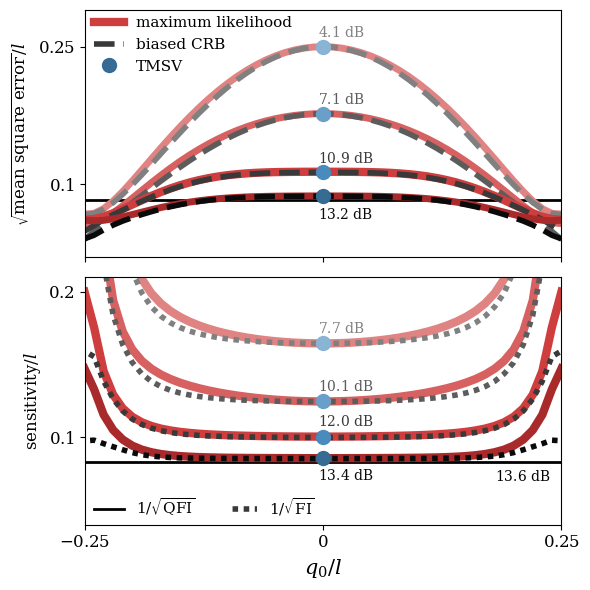

In [7]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['DejaVu Serif'],
    'mathtext.fontset': 'dejavuserif'
})
Delta = .3
cd = np.cosh(Delta**2)
fig, axs = plt.subplots(2,1,figsize=(6,6),sharex=True)
ax1, ax2 = axs
R1, k, steps, l = 10, 0, 51, np.sqrt(2*np.pi)
q0_range = (l/4)*np.linspace(-1.0,1.0,steps)
T_range = [1,2,4,10]

name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,120)
sensor = sps.load_npz(path_data_sBs_sensor+name)
n = (n_op@sensor).diagonal().sum()
QFI = np.real(1/(4*n+2))
print('sensor n',np.real(n))

ax2.plot([-1,1],[np.sqrt(QFI)/l,np.sqrt(QFI)/l],color=lighten_color('black',1),lw=2,ls='-',label=r'1/$\sqrt{\text{QFI}}$')
ax1.plot([-1,1],[np.sqrt(QFI)/l,np.sqrt(QFI)/l],color=lighten_color('black',1),lw=2,ls='-',label=None)

r_QFI = np.log(1/np.sqrt(QFI))
dB_QFI = 10*np.log10(np.exp(2*r_QFI))
gain_QFI = np.cosh(r_QFI)**2
ax2.text(0.18,.07,r'${0:.1f}$ dB'.format(dB_QFI),fontsize=10,color=lighten_color('black',1))

print('QFI-r:',np.real(r_QFI),'dB-QFI:',dB_QFI, 'gain-QFI:',gain_QFI)
for T in T_range:
    
    name = 'data-noiseless-sensitivity-fullqmap-delta={0:.2f}-T={1:.0f}'.format(Delta,T)
    with open(path_sBs_MP_ML+name+'.pkl', 'rb') as file:
        dictionary = pickle.load(file)
    MSE = dictionary['MSE']
    biases = dictionary['biases']
    partial_means = dictionary['partial_means']
    FIqT = dictionary['FIqT']

    # ax1.plot(q0_range/l,MSE-biases**2,ls='-',color=lighten_color(red,.7),lw=2)
    # ax1.plot(q0_range/l, np.sqrt(1/FIqT)/l,color=lighten_color('black',shine),lw=3,ls='--')
    shine = .5+.2*np.log(T)

    if T==4:
        ax1.plot(q0_range/l,np.sqrt(MSE)/l,ls='-',color=lighten_color(red,shine),lw=6,label='maximum likelihood')
        ax1.plot(q0_range/l, np.sqrt(partial_means**2/FIqT)/l,color=lighten_color('black',shine),lw=4,ls='--',label='biased CRB')
    else:
        ax1.plot(q0_range/l,np.sqrt(MSE)/l,ls='-',color=lighten_color(red,shine),lw=5)
        ax1.plot(q0_range/l, np.sqrt(partial_means**2/FIqT)/l,color=lighten_color('black',shine),lw=4,ls='--')

    # ax2.plot(q0_range/l, Var/partial_means**2,color=blue,lw=3)
    sensitivity = np.sqrt(MSE/partial_means**2)
    if T==4:
        ax2.plot(q0_range/l, sensitivity/l,color=lighten_color(red,shine),lw=6)
        ax2.plot(q0_range/l, np.sqrt(1/FIqT)/l,color=lighten_color('black',shine),lw=4,ls=(1,(1,1)),label=r'1/$\sqrt{\text{FI}}$')
    else:
        ax2.plot(q0_range/l, sensitivity/l,color=lighten_color(red,shine),lw=6)
        ax2.plot(q0_range/l, np.sqrt(1/FIqT)/l,color=lighten_color('black',shine),lw=4,ls=(1,(1,1)))
    print(T,q0_range[np.argmin(MSE/partial_means**2)]/l)


    r = np.log(1/np.sqrt(MSE[int(steps/2)]))
    ind_mean = np.argmin((MSE[:int(steps/2)]-np.mean(MSE))**2)
    ind_max = int(steps/2)
    dB = 10*np.log10(np.exp(2*r))
    gain = np.cosh(r)**2
    rs = np.log(1/np.min(sensitivity))
    gains = np.cosh(rs)**2
    dBs = 10*np.log10(np.exp(2*rs))
    rmin = np.log(1/np.sqrt(np.min(MSE)))
    print('squeezing parameter r:',rs, 'gain:',gains, 'dB:',10*np.log10(np.exp(2*rs)))
    print('squeezing parameter rmin:',rmin,'dB:',10*np.log10(np.exp(2*rmin)))

    x0, y0 = -.005, .01

    if T==10:
        ax1.text(q0_range[ind_max]/l+x0,np.sqrt(MSE[ind_max])/l-.025,r'${0:.1f}$ dB'.format(dB),fontsize=10,color=lighten_color('black',shine))
        ax1.plot(q0_range[ind_max]/l,np.sqrt(MSE[ind_max])/l,'o',color=lighten_color(blue,shine),markersize=10,label='TMSV')
        ax2.text(q0_range[np.argmin(sensitivity)]/l+x0,sensitivity[np.argmin(sensitivity)]/l-.015,r'${0:.1f}$ dB'.format(dBs),fontsize=10,color=lighten_color('black',shine))
        ax2.plot(q0_range[np.argmin(sensitivity)]/l,sensitivity[np.argmin(sensitivity)]/l,'o',color=lighten_color(blue,shine),markersize=10)

    else:
        ax1.text(q0_range[ind_max]/l+x0,np.sqrt(MSE[ind_max])/l+.01,r'${0:.1f}$ dB'.format(dB),fontsize=10,color=lighten_color('black',shine))
        ax1.plot(q0_range[ind_max]/l,np.sqrt(MSE[ind_max])/l,'o',color=lighten_color(blue,shine),markersize=10)
        ax2.text(q0_range[np.argmin(sensitivity)]/l+x0,sensitivity[np.argmin(sensitivity)]/l+.007,r'${0:.1f}$ dB'.format(dBs),fontsize=10,color=lighten_color('black',shine))
        ax2.plot(q0_range[np.argmin(sensitivity)]/l,sensitivity[np.argmin(sensitivity)]/l,'o',color=lighten_color(blue,shine),markersize=10)

    print('average MSE',np.mean(MSE),np.mean(1/FIqT))


r_half = np.log(2)/2
r_10 = np.log(10)/2
r_20 = np.log(20)/2
r_40 = np.log(40)/2
print('as a reference for e^(-2r)=1/2, r is:',r_half,'gain:',np.cosh(r_half)**2, 'dB:',10*np.log10(np.exp(2*r_half)))
print('as a reference for e^(-2r)=1/10, r is:',r_10,'gain:',np.cosh(r_10)**2, 'dB:',10*np.log10(np.exp(2*r_10)))
print('as a reference for e^(-2r)=1/20, r is:',r_20,'gain:',np.cosh(r_20)**2, 'dB:',10*np.log10(np.exp(2*r_20)))
ax1.set_ylim(.02,.29)
ax1.set_xlim(-.25,.25)
ax2.set_ylim(0.04,.21)
ax2.set_xlim(-.25,.25)
xticks = [-1/4,0,1/4]
xlabels = [r'$-0.25$',r'$0$',r'$0.25$']
ax2.set_xticks(xticks)
ax2.set_xticklabels(xlabels,fontsize=12)
ax2.set_xlabel(r'$q_0/l$',fontsize=15)
y1ticks = [.1,.25]
y1labels = [r'$0.1$',r'$0.25$']
ax1.set_yticks(y1ticks)
ax1.set_yticklabels(y1labels,fontsize=12)
y2ticks = [.1,.2]
y2labels = [r'$0.1$',r'$0.2$']
ax2.set_yticks(y2ticks)
ax2.set_yticklabels(y2labels,fontsize=12)
ax1.set_ylabel(r'$\sqrt{\text{mean square error}}/l$',fontsize=12)
ax2.set_ylabel(r'$\text{sensitivity}/l$',fontsize=12)
ax1.legend(fontsize=11,loc='upper left',framealpha=0,bbox_to_anchor=(-0.01,1.03))
ax2.legend(fontsize=11,loc='lower left',framealpha=0,bbox_to_anchor=(-0.01,-0.03),ncol=2)

plt.tight_layout()
name = 'Paper-Fig3-ML-MSE-sensitivity'
plt.savefig(path_figures+name+'.pdf',bbox_inches='tight',dpi=1000)

sensor n 5.27312488122502
QFI-r: 1.5697539344554259 dB-QFI: 13.634709433598207 gain-QFI: 6.2839509072136925
1 0.0
squeezing parameter r: 0.8843271987854775 gain: 2.008380295764635 dB: 7.681168452589859
squeezing parameter rmin: 1.77975035395197 dB: 15.458715157733998
average MSE 0.21271620558622112 1.0306238438474467
2 0.0
squeezing parameter r: 1.1618102474890912 gain: 3.077625121383114 dB: 10.091355590063273
squeezing parameter rmin: 1.9464145534247796 dB: 16.90634200097128
average MSE 0.11519614336008195 0.15651277882876272
4 0.0
squeezing parameter r: 1.3774001234148445 gain: 4.445380653927061 dB: 11.9639454594385
squeezing parameter rmin: 1.8749524287100054 dB: 16.28562987239711
average MSE 0.06074052555691018 0.07716247599989562
10 0.0
squeezing parameter r: 1.5369540774279193 gain: 5.918124145229156 dB: 13.349813495312972
squeezing parameter rmin: 1.8941139333807142 dB: 16.452064587266154
average MSE 0.03862229404136359 0.048657190912719805
as a reference for e^(-2r)=1/2, r is: 

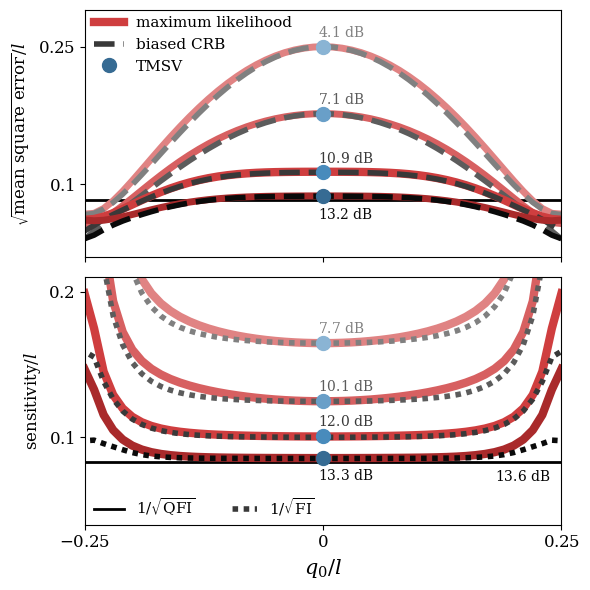

In [7]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['DejaVu Serif'],
    'mathtext.fontset': 'dejavuserif'
})
Delta = .3
cd = np.cosh(Delta**2)
fig, axs = plt.subplots(2,1,figsize=(6,6),sharex=True)
ax1, ax2 = axs
R1, k, steps, l = 10, 0, 51, np.sqrt(2*np.pi)
q0_range = (l/4)*np.linspace(-1.0,1.0,steps)
T_range = [1,2,4,10]

name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,120)
sensor = sps.load_npz(path_data_sBs_sensor+name)
n = (n_op@sensor).diagonal().sum()
QFI = np.real(1/(4*n+2))
print('sensor n',np.real(n))

ax2.plot([-1,1],[np.sqrt(QFI)/l,np.sqrt(QFI)/l],color=lighten_color('black',1),lw=2,ls='-',label=r'1/$\sqrt{\text{QFI}}$')
ax1.plot([-1,1],[np.sqrt(QFI)/l,np.sqrt(QFI)/l],color=lighten_color('black',1),lw=2,ls='-',label=None)

r_QFI = np.log(1/np.sqrt(QFI))
dB_QFI = 10*np.log10(np.exp(2*r_QFI))
gain_QFI = np.cosh(r_QFI)**2
ax2.text(0.18,.07,r'${0:.1f}$ dB'.format(dB_QFI),fontsize=10,color=lighten_color('black',1))

print('QFI-r:',np.real(r_QFI),'dB-QFI:',dB_QFI, 'gain-QFI:',gain_QFI)
for T in T_range:
    
    name = 'data-noiseless-sensitivity-fullpmap-delta={0:.2f}-T={1:.0f}'.format(Delta,T)
    with open(path_sBs_MP_ML+name+'.pkl', 'rb') as file:
        dictionary = pickle.load(file)
    MSE = dictionary['MSE']
    biases = dictionary['biases']
    partial_means = dictionary['partial_means']
    FIqT = dictionary['FIqT']

    # ax1.plot(q0_range/l,MSE-biases**2,ls='-',color=lighten_color(red,.7),lw=2)
    # ax1.plot(q0_range/l, np.sqrt(1/FIqT)/l,color=lighten_color('black',shine),lw=3,ls='--')
    shine = .5+.2*np.log(T)

    if T==4:
        ax1.plot(q0_range/l,np.sqrt(MSE)/l,ls='-',color=lighten_color(red,shine),lw=6,label='maximum likelihood')
        ax1.plot(q0_range/l, np.sqrt(partial_means**2/FIqT)/l,color=lighten_color('black',shine),lw=4,ls='--',label='biased CRB')
    else:
        ax1.plot(q0_range/l,np.sqrt(MSE)/l,ls='-',color=lighten_color(red,shine),lw=5)
        ax1.plot(q0_range/l, np.sqrt(partial_means**2/FIqT)/l,color=lighten_color('black',shine),lw=4,ls='--')

    # ax2.plot(q0_range/l, Var/partial_means**2,color=blue,lw=3)
    sensitivity = np.sqrt(MSE/partial_means**2)
    if T==4:
        ax2.plot(q0_range/l, sensitivity/l,color=lighten_color(red,shine),lw=6)
        ax2.plot(q0_range/l, np.sqrt(1/FIqT)/l,color=lighten_color('black',shine),lw=4,ls=(1,(1,1)),label=r'1/$\sqrt{\text{FI}}$')
    else:
        ax2.plot(q0_range/l, sensitivity/l,color=lighten_color(red,shine),lw=6)
        ax2.plot(q0_range/l, np.sqrt(1/FIqT)/l,color=lighten_color('black',shine),lw=4,ls=(1,(1,1)))
    print(T,q0_range[np.argmin(MSE/partial_means**2)]/l)


    r = np.log(1/np.sqrt(MSE[int(steps/2)]))
    ind_mean = np.argmin((MSE[:int(steps/2)]-np.mean(MSE))**2)
    ind_max = int(steps/2)
    dB = 10*np.log10(np.exp(2*r))
    gain = np.cosh(r)**2
    rs = np.log(1/np.min(sensitivity))
    gains = np.cosh(rs)**2
    dBs = 10*np.log10(np.exp(2*rs))
    rmin = np.log(1/np.sqrt(np.min(MSE)))
    print('squeezing parameter r:',rs, 'gain:',gains, 'dB:',10*np.log10(np.exp(2*rs)))
    print('squeezing parameter rmin:',rmin,'dB:',10*np.log10(np.exp(2*rmin)))

    x0, y0 = -.005, .01

    if T==10:
        ax1.text(q0_range[ind_max]/l+x0,np.sqrt(MSE[ind_max])/l-.025,r'${0:.1f}$ dB'.format(dB),fontsize=10,color=lighten_color('black',shine))
        ax1.plot(q0_range[ind_max]/l,np.sqrt(MSE[ind_max])/l,'o',color=lighten_color(blue,shine),markersize=10,label='TMSV')
        ax2.text(q0_range[np.argmin(sensitivity)]/l+x0,sensitivity[np.argmin(sensitivity)]/l-.015,r'${0:.1f}$ dB'.format(dBs),fontsize=10,color=lighten_color('black',shine))
        ax2.plot(q0_range[np.argmin(sensitivity)]/l,sensitivity[np.argmin(sensitivity)]/l,'o',color=lighten_color(blue,shine),markersize=10)

    else:
        ax1.text(q0_range[ind_max]/l+x0,np.sqrt(MSE[ind_max])/l+.01,r'${0:.1f}$ dB'.format(dB),fontsize=10,color=lighten_color('black',shine))
        ax1.plot(q0_range[ind_max]/l,np.sqrt(MSE[ind_max])/l,'o',color=lighten_color(blue,shine),markersize=10)
        ax2.text(q0_range[np.argmin(sensitivity)]/l+x0,sensitivity[np.argmin(sensitivity)]/l+.007,r'${0:.1f}$ dB'.format(dBs),fontsize=10,color=lighten_color('black',shine))
        ax2.plot(q0_range[np.argmin(sensitivity)]/l,sensitivity[np.argmin(sensitivity)]/l,'o',color=lighten_color(blue,shine),markersize=10)

    print('average MSE',np.mean(MSE),np.mean(1/FIqT))


r_half = np.log(2)/2
r_10 = np.log(10)/2
r_20 = np.log(20)/2
r_40 = np.log(40)/2
print('as a reference for e^(-2r)=1/2, r is:',r_half,'gain:',np.cosh(r_half)**2, 'dB:',10*np.log10(np.exp(2*r_half)))
print('as a reference for e^(-2r)=1/10, r is:',r_10,'gain:',np.cosh(r_10)**2, 'dB:',10*np.log10(np.exp(2*r_10)))
print('as a reference for e^(-2r)=1/20, r is:',r_20,'gain:',np.cosh(r_20)**2, 'dB:',10*np.log10(np.exp(2*r_20)))
ax1.set_ylim(.02,.29)
ax1.set_xlim(-.25,.25)
ax2.set_ylim(0.04,.21)
ax2.set_xlim(-.25,.25)
xticks = [-1/4,0,1/4]
xlabels = [r'$-0.25$',r'$0$',r'$0.25$']
ax2.set_xticks(xticks)
ax2.set_xticklabels(xlabels,fontsize=12)
ax2.set_xlabel(r'$q_0/l$',fontsize=15)
y1ticks = [.1,.25]
y1labels = [r'$0.1$',r'$0.25$']
ax1.set_yticks(y1ticks)
ax1.set_yticklabels(y1labels,fontsize=12)
y2ticks = [.1,.2]
y2labels = [r'$0.1$',r'$0.2$']
ax2.set_yticks(y2ticks)
ax2.set_yticklabels(y2labels,fontsize=12)
ax1.set_ylabel(r'$\sqrt{\text{mean square error}}/l$',fontsize=12)
ax2.set_ylabel(r'$\text{sensitivity}/l$',fontsize=12)
ax1.legend(fontsize=11,loc='upper left',framealpha=0,bbox_to_anchor=(-0.01,1.03))
ax2.legend(fontsize=11,loc='lower left',framealpha=0,bbox_to_anchor=(-0.01,-0.03),ncol=2)

plt.tight_layout()
name = 'Paper-Fig3-ML-MSE-sensitivity'
plt.savefig(path_figures+name+'.pdf',bbox_inches='tight',dpi=1000)

### plotting minimal sensitivity as function of $\Delta$

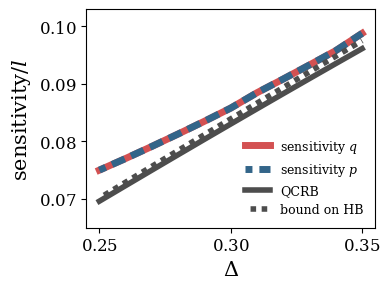

In [78]:
def mininal_sensitivity_delta(Delta, T):
    name = 'data-noiseless-sensitivity-fullpmap-delta={0:.2f}-T={1:.0f}'.format(Delta,T)
    with open(path_sBs_MP_ML+name+'.pkl', 'rb') as file:
        dictionary = pickle.load(file)
    MSE = dictionary['MSE']
    biases = dictionary['biases']
    partial_means = dictionary['partial_means']
    FIqT = dictionary['FIqT']
    sensitivity_q = np.sqrt(MSE/partial_means**2)

    name = 'data-noiseless-sensitivity-fullpmap-delta={0:.2f}-T={1:.0f}'.format(Delta,T)
    with open(path_sBs_MP_ML+name+'.pkl', 'rb') as file:
        dictionary = pickle.load(file)
    MSE = dictionary['MSE']
    biases = dictionary['biases']
    partial_means = dictionary['partial_means']
    FIqT = dictionary['FIqT']
    sensitivity_p = np.sqrt(MSE/partial_means**2)
    
    return sensitivity_q , sensitivity_p

def CRB_HB_delta(Delta):
    name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,120)
    sensor = sps.load_npz(path_data_sBs_sensor+name)
    n = np.real((n_op@sensor).diagonal().sum())
    CR = np.sqrt(1/(4*n+2))
    HB  = CR*np.sqrt(1+1/(8*n+4))
    return CR, HB

Delta_range = np.arange(.25,.36,.01)
T = 10
sensitivity_q_delta = []
sensitivity_p_delta = []
CR_delta, HB_delta = [], []
for Delta in Delta_range:
    sensitivity_q, sensitivity_p = mininal_sensitivity_delta(Delta, T)
    sensitivity_q_delta.append(sensitivity_q[len(sensitivity_q)//2])
    sensitivity_p_delta.append(sensitivity_p[len(sensitivity_q)//2])
    CRB, HB = CRB_HB_delta(Delta)
    CR_delta.append(CRB)
    HB_delta.append(HB)

fig, ax = plt.subplots(1,1,figsize=(4,3),sharex=True)
ax.plot(Delta_range, sensitivity_q_delta/l, color=lighten_color(red,.7), lw=5, label='sensitivity $q$')
ax.plot(Delta_range, sensitivity_p_delta/l, color=blue, lw=5, label='sensitivity $p$',ls=(1,(2,1)))
ax.plot(Delta_range, CR_delta/l, color=lighten_color('black',.7), lw=4, label='QCRB')
ax.plot(Delta_range, HB_delta/l, color=lighten_color('black',.7), lw=4, label='bound on HB',ls=(1,(1,1)))
ax.set_xlabel(r'$\Delta$',fontsize=15)
ax.set_ylabel(r'$\text{sensitivity}/l$',fontsize=15)
ax.set_ylim(0.065,.103)
ax.set_xlim(0.245,0.355)
y1labels = [r'$0.07$',r'$0.08$',r'$0.09$',r'$0.10$']
y1ticks = [.07,.08,.09,.1]
xticks = [.25,.3,.35]
xlabels = [r'$0.25$',r'$0.30$',r'$0.35$']
ax.set_yticks(y1ticks)
ax.set_yticklabels(y1labels,fontsize=12)
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels,fontsize=12)

ax.legend(fontsize=9,loc='lower right',framealpha=0)
plt.tight_layout()
name = 'Paper-Fig-sensitivity-delta-bounds'
plt.savefig(path_figures+name+'.pdf',bbox_inches='tight',dpi=1000)

# information rate in units of $1/\sqrt{\text{bits}}$

## first information per bit without the rate

7.773724209576819
7.69074796606931
7.595967402179595
7.489021858599953


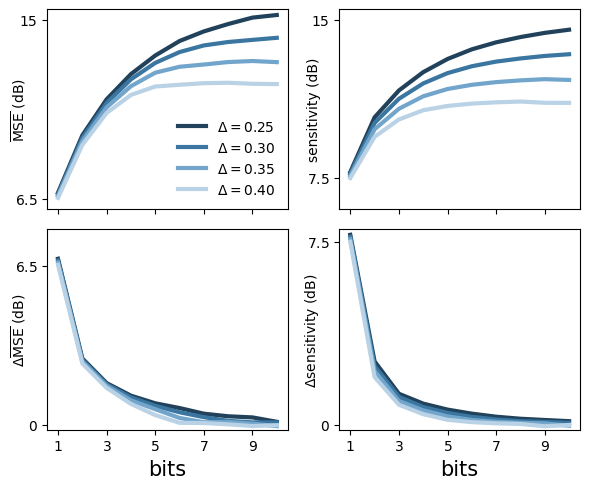

In [45]:
Delta_range = [.25,.3,.35,.4]
R0 = 120
R1, k, steps, l = 15, 0, 101, np.sqrt(2*np.pi)
gauges = [0,0]
cd = np.cosh(Delta**2)
q0_range = (l/4/cd)*np.linspace(-1.0,1.0,steps)
T_range = np.arange(1,11,1)

fig, axs = plt.subplots(2,2,figsize=(6,5),sharex=True)
axs1, axs2 = axs
ax1, ax2 = axs1
ax3, ax4 = axs2
for i in range(4):
    Delta = Delta_range[i]
    max_MSE, min_MSE, avg_MSE = [],[],[]
    sensitivities = []
    for T in T_range:
        name = 'data-noiseless-sensitivity-fullqmap-delta={0:.2f}-T={1:.0f}'.format(Delta,T)
        with open(path_sBs_MP_ML+name+'.pkl', 'rb') as file:
            dictionary = pickle.load(file)
        MSE = dictionary['MSE']
        biases = dictionary['biases']
        partial_means = dictionary['partial_means']
        FIqT = dictionary['FIqT']
        sensitivity = np.sqrt(MSE/partial_means**2)

        max_MSE.append(np.max(MSE))
        min_MSE.append(np.min(MSE))
        avg_MSE.append(np.mean(MSE))
        sensitivities.append(np.min(sensitivity))

    max_MSE, min_MSE, avg_MSE = np.array(max_MSE), np.array(min_MSE), np.array(avg_MSE)
    sensitivities = np.array(sensitivities)

    def MSE_to_dB(MSE):
        r = np.log(1/np.sqrt(MSE))
        return 10*np.log10(np.exp(2*r))
    def sensitivity_to_dB(sensitivity):
        rs = np.log(1/sensitivity)
        return 10*np.log10(np.exp(2*rs))

    gaps_max_dB = [MSE_to_dB(max_MSE[0])]
    gaps_min_dB = [MSE_to_dB(min_MSE[0])]
    gaps_avg_dB = [MSE_to_dB(avg_MSE[0])]

    gaps_sensitivity_dB = [sensitivity_to_dB(sensitivities[0])]

    gaps_max_dB2 = [MSE_to_dB(max_MSE[i+1])-MSE_to_dB(max_MSE[i]) for i in range(len(max_MSE)-1)]
    gaps_min_dB2 = [MSE_to_dB(min_MSE[i+1])-MSE_to_dB(min_MSE[i]) for i in range(len(min_MSE)-1)]
    gaps_avg_dB2 = [MSE_to_dB(avg_MSE[i+1])-MSE_to_dB(avg_MSE[i]) for i in range(len(avg_MSE)-1)]
    gaps_sensitivity_dB2 = [sensitivity_to_dB(sensitivities[i+1])-sensitivity_to_dB(sensitivities[i]) for i in range(len(sensitivities)-1)]

    gaps_max_dB += gaps_max_dB2
    gaps_min_dB += gaps_min_dB2
    gaps_avg_dB += gaps_avg_dB2
    gaps_sensitivity_dB += gaps_sensitivity_dB2

    gaps_max_dB, gaps_min_dB, gaps_avg_dB = np.array(gaps_max_dB), np.array(gaps_min_dB), np.array(gaps_avg_dB)
    gaps_sensitivity_dB = np.array(gaps_sensitivity_dB)

    max_dB = MSE_to_dB(max_MSE)
    min_dB = MSE_to_dB(min_MSE)
    avg_dB = MSE_to_dB(avg_MSE)
    sensitivity_dB = sensitivity_to_dB(sensitivities)

    print(np.max(gaps_sensitivity_dB))

    # ax1.plot(T_range,max_dB,color=lighten_color(blue,1-.2*i),lw=3,label=r'$\text{Tr}(\rho T_q)$')
    # ax1.plot(T_range,min_dB,color=lighten_color(red,1-.2*i),lw=3,label=r'$\text{Tr}(\rho T_p)$')
    ax1.plot(T_range,avg_dB,color=lighten_color(blue,1.2-.3*i),lw=3,label=r'$\Delta={0:.2f}$'.format(Delta))
    ax2.plot(T_range,sensitivity_dB,color=lighten_color(blue,1.2-.3*i),lw=3)

    # ax2.plot(T_range[1:],gaps_max_dB/np.sqrt(T_range[:-1]),color=lighten_color(blue,1-.2*i),lw=3,label=r'$\text{Tr}(\rho T_q)$')
    ax3.plot(T_range,gaps_avg_dB,color=lighten_color(blue,1.2-.3*i),lw=3)
    ax4.plot(T_range,gaps_sensitivity_dB,color=lighten_color(blue,1.2-.3*i),lw=3)

# ax1.set_ylim(6,15.8)
ax3.set_ylim(-.2,7)
ax1.set_yticks([15,6.5])
ax1.set_ylim(6,15.5)
ax1.set_yticklabels([r'$15$',r'$6.5$'],fontsize=10)
ax3.set_yticks([0,6.5])
ax3.set_ylim(-.2,8)
ax3.set_yticklabels([r'$0$',r'$6.5$'],fontsize=10)
ax3.set_xticks([1,3,5,7,9])
ax3.set_xticklabels([r'$1$',r'$3$',r'$5$',r'$7$',r'$9$'],fontsize=10)
ax3.set_xlabel(r'bits',fontsize=15)
ax1.set_ylabel(r'$\overline{\text{MSE}}$ (dB)',fontsize=10,labelpad=-10)
ax3.set_ylabel(r'$\Delta \overline{\text{MSE}}$ (dB)',fontsize=10,labelpad=-10)

ax4.set_ylim(-.2,8)
ax2.set_yticks([15,7.5])
ax2.set_ylim(6,15.5)
ax2.set_yticklabels([r'$15$',r'$7.5$'],fontsize=10)
ax4.set_yticks([0,7.5])
ax4.set_ylim(-.2,8)
ax4.set_yticklabels([r'$0$',r'$7.5$'],fontsize=10)
ax4.set_xticks([1,3,5,7,9])
ax4.set_xticklabels([r'$1$',r'$3$',r'$5$',r'$7$',r'$9$'],fontsize=10)
ax4.set_xlabel(r'bits',fontsize=15)
ax2.set_ylabel(r'sensitivity (dB)',fontsize=10,labelpad=-10)
ax4.set_ylabel(r'$\Delta \text{sensitivity}$ (dB)',fontsize=10,labelpad=-10)

ax1.legend(loc='lower right',fontsize=10,framealpha=0)
plt.tight_layout()
name = 'appendix-ML-MSE-sensitivity-bits'
fig.savefig(path_figures+name+'.pdf',bbox_inches='tight',dpi=1000)
plt.show()


## information per unit of $1/\sqrt{\text{bits}}$

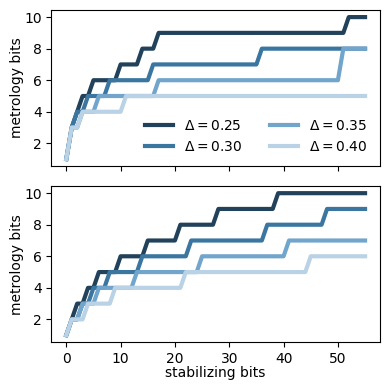

In [54]:
#consider preparation time in unit of bits 

preparation_bits = np.arange(0,56,1)
Delta_range = [.25,.3,.35,.4]
R0 = 120
R1, k, steps, l = 15, 0, 101, np.sqrt(2*np.pi)
gauges = [0,0]
cd = np.cosh(Delta**2)
q0_range = (l/4/cd)*np.linspace(-1.0,1.0,steps)
T_range = np.arange(1,11,1)

fig, axs = plt.subplots(2,1,figsize=(4,4),sharex=True)
ax1, ax2 = axs
for j in range(4):
    Delta = Delta_range[j]
    T_max_avg_all, T_max_sensitivity_all = [],[]

    for i in range(len(preparation_bits)):
        preparation = preparation_bits[i]
        max_MSE, min_MSE, avg_MSE = [],[],[]
        sensitivities = []
        for T in T_range:
            name = 'data-noiseless-sensitivity-fullqmap-delta={0:.2f}-T={1:.0f}'.format(Delta,T)
            with open(path_sBs_MP_ML+name+'.pkl', 'rb') as file:
                dictionary = pickle.load(file)
            MSE = dictionary['MSE']
            biases = dictionary['biases']
            partial_means = dictionary['partial_means']
            FIqT = dictionary['FIqT']
            sensitivity = np.sqrt(MSE/partial_means**2)

            max_MSE.append(np.max(MSE))
            min_MSE.append(np.min(MSE))
            avg_MSE.append(np.mean(MSE))
            sensitivities.append(np.min(sensitivity))

        max_MSE, min_MSE, avg_MSE = np.array(max_MSE), np.array(min_MSE), np.array(avg_MSE)
        sensitivities = np.array(sensitivities)

        def MSE_to_dB(MSE):
            r = np.log(1/np.sqrt(MSE))
            return 10*np.log10(np.exp(2*r))
        def sensitivity_to_dB(sensitivity):
            rs = np.log(1/sensitivity)
            return 10*np.log10(np.exp(2*rs))

        max_dB = MSE_to_dB(max_MSE)
        min_dB = MSE_to_dB(min_MSE)
        avg_dB = MSE_to_dB(avg_MSE)
        sensitivity_dB = sensitivity_to_dB(sensitivities)
        rate = T_range+preparation

        avg_dB_rate = avg_dB/np.sqrt(rate)*np.sqrt(rate[0])
        sensitivity_dB_rate = sensitivity_dB/np.sqrt(rate)*np.sqrt(rate[0])

        T_avg_max = T_range[np.argmax(avg_dB_rate)]
        T_sensitivity_max = T_range[np.argmax(sensitivity_dB_rate)]
        T_max_avg_all.append(T_avg_max)
        T_max_sensitivity_all.append(T_sensitivity_max)

    ax1.plot(preparation_bits,T_max_avg_all,color=lighten_color(blue,1.2-.3*j),lw=3,label=r'$\Delta={0:.2f}$'.format(Delta))
    ax2.plot(preparation_bits,T_max_sensitivity_all,color=lighten_color(blue,1.2-.3*j),lw=3)


# ax1.set_ylim(6,15.8)
# ax1.set_yticks([15,6.5])
# ax1.set_ylim(0,12)
# ax1.set_yticklabels([r'$15$',r'$6.5$'],fontsize=10)
# ax1.set_ylabel(r'$\overline{\text{MSE}}$ (dB)',fontsize=10,labelpad=-10)
ax1.set_ylabel(r'metrology bits',fontsize=10,labelpad=0)


# ax2.set_yticks([15,7.5])
# ax2.set_yticklabels([r'$15$',r'$7.5$'],fontsize=10)
# ax2.set_ylabel(r'sensitivity (dB)',fontsize=10,labelpad=-10)
ax2.set_xlabel(r'stabilizing bits',fontsize=10,labelpad=0)
ax2.set_ylabel(r'metrology bits',fontsize=10,labelpad=0)


ax1.legend(loc='lower right',fontsize=10,framealpha=0,ncol=2)
plt.tight_layout()
name = 'appendix-ML-MSE-sensitivity-rate'
fig.savefig(path_figures+name+'.pdf',bbox_inches='tight',dpi=1000)
plt.show()

## plotting MSE as a function of number of bits, gaussian prior

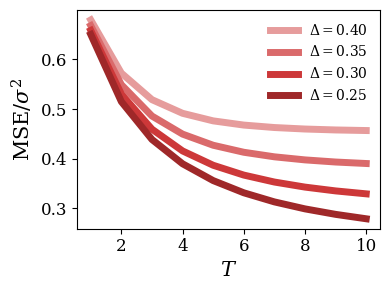

In [101]:
Delta_range = [.4,.35,.3,.25]
T_range = np.arange(1,11,1)
k = 0
steps = 51  
stddev_range = np.arange(0.05,l/4+.1,.01)
fig, ax = plt.subplots(1,1,figsize=(4,3))
for i in range(len(Delta_range)):
    Delta = Delta_range[i]
    shine = .4+.2*i
    min_MSE = []
    for T in T_range:
        name = 'gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
        with open(path_sBs_bayesian+name+'.pkl', 'rb') as f:
            dictionary = pickle.load(f)
        MSE = dictionary['MSEs']
        MSE_q = dictionary['mse_qrange']
        min_MSE.append(np.min(MSE/stddev_range**2))

        # name = 'gaussian_prior_fullpmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
        # with open(path_sBs_bayesian+name+'.pkl', 'rb') as f:
        #     dictionary = pickle.load(f)
        # MSE = dictionary['MSEs']
        # MSE_q = dictionary['mse_qrange']
        # min_MSE.append(np.min(MSE/stddev_range**2))
        
    ax.plot(T_range, min_MSE, color=lighten_color(red,shine), lw=5, label=r'$\Delta={0:.2f}$'.format(Delta))

ax.set_xlabel(r'$T$',fontsize=15)
ax.set_ylabel(r'$\text{MSE}/\sigma^2$',fontsize=15)
ax.legend(loc='upper right',fontsize=10,framealpha=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
name = 'Paper-fig-MSE-bayesian-T'
plt.savefig(path_figures+name+'.pdf',bbox_inches='tight',dpi=1000)

# Running backaction evading 

## Constructing the estimators

### maximum likelihood estimators

In [ ]:
# Delta = .25
# R1, k, steps, l = 15, 4, 101, np.sqrt(2*np.pi)
# cd = np.cosh(Delta**2)
# q0_range = (l/4/cd)*np.linspace(-1.0,1.0,steps)
# p0_range = (l/4/cd)*np.linspace(-1.0,1.0,steps)
# T_range = np.arange(1,10,1)
# for T in T_range:
#     name_probs = 'probabilities_Delta={0:.2f}_R={1:.0f}_p0=lover{2:.0f}_q0range(-lover4,lover4)_steps={3:.0f}'.format(Delta,R1,k,steps)
#     probs_qp0 = np.load(path_data_sBs_probabilities+name_probs+'.npy')
#     MLq = ML_q0(probs_qp0,R1,q0_range,T,steps)
#     name = 'estimators_ML_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range=(-lover4,lover4)'.format(Delta,T,k)
#     np.save(path_sBs_MP_ML+name,MLq)

#     name_probs = 'probabilities_Delta={0:.2f}_R={1:.0f}_q0=lover{2:.0f}_p0range(-lover4,lover4)_steps={3:.0f}'.format(Delta,R1,k,steps)
#     probs_pq0 = np.load(path_data_sBs_probabilities+name_probs+'.npy')
#     MLp = ML_p0(probs_pq0,R1,p0_range,T,steps)
#     name = 'estimators_ML_Delta={0:.2f}_T={1:.0f}_q0=lover{2:.0f}_p0range=(-lover4,lover4)'.format(Delta,T,k)
#     np.save(path_sBs_MP_ML+name,MLp)

(2,)
estimators_ML_Delta=0.25_T=1_p0=lover4_q0range=(-lover4,lover4)
(4,)
estimators_ML_Delta=0.25_T=2_p0=lover4_q0range=(-lover4,lover4)
(8,)
estimators_ML_Delta=0.25_T=3_p0=lover4_q0range=(-lover4,lover4)
(16,)
estimators_ML_Delta=0.25_T=4_p0=lover4_q0range=(-lover4,lover4)
(32,)
estimators_ML_Delta=0.25_T=5_p0=lover4_q0range=(-lover4,lover4)
(64,)
estimators_ML_Delta=0.25_T=6_p0=lover4_q0range=(-lover4,lover4)
(128,)
estimators_ML_Delta=0.25_T=7_p0=lover4_q0range=(-lover4,lover4)
(256,)
estimators_ML_Delta=0.25_T=8_p0=lover4_q0range=(-lover4,lover4)
(512,)
estimators_ML_Delta=0.25_T=9_p0=lover4_q0range=(-lover4,lover4)


In [ ]:
# Delta = .3
# R1, k, steps, l = 15, 4, 101, np.sqrt(2*np.pi)
# cd = np.cosh(Delta**2)
# q0_range = (l/4/cd)*np.linspace(-1.0,1.0,steps)
# p0_range = (l/4/cd)*np.linspace(-1.0,1.0,steps)
# T_range = np.arange(1,10,1)
# for T in T_range:
#     name_probs = 'probabilities_Delta={0:.2f}_R={1:.0f}_p0=lover{2:.0f}_q0range(-lover4,lover4)_steps={3:.0f}'.format(Delta,R1,k,steps)
#     probs_qp0 = np.load(path_data_sBs_probabilities+name_probs+'.npy')
#     MLq = ML_q0(probs_qp0,R1,q0_range,T,steps)
#     name = 'estimators_ML_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range=(-lover4,lover4)'.format(Delta,T,k)
#     np.save(path_sBs_MP_ML+name,MLq)

#     name_probs = 'probabilities_Delta={0:.2f}_R={1:.0f}_q0=lover{2:.0f}_p0range(-lover4,lover4)_steps={3:.0f}'.format(Delta,R1,k,steps)
#     probs_pq0 = np.load(path_data_sBs_probabilities+name_probs+'.npy')
#     MLp = ML_p0(probs_pq0,R1,p0_range,T,steps)
#     name = 'estimators_ML_Delta={0:.2f}_T={1:.0f}_q0=lover{2:.0f}_p0range=(-lover4,lover4)'.format(Delta,T,k)
#     np.save(path_sBs_MP_ML+name,MLp)

### gaussian estimator (the l range ones are built in gaussian prior)

In [264]:
k, steps, R = 0,51,10
Delta_range = [.25,.3,.35,.4]

for Delta in Delta_range:
    cd = np.cosh(Delta**2)
    q0_range = (l/4)*np.linspace(-1.0,1.0,steps)
    name = 'probs_allqbits_p0=lover{0:.0f}_qrange(-lover4,lover4)_steps={1:.0f}_Delta={2:.2f}_T={3:.0f}'.format(k,steps,Delta,R)#D\equiv /, division
    probs_qp0_allbits = np.load(path_data_sBs_probabilities+name+'.npy',allow_pickle=True)
    # probs_qp0_allbits = probs_qp0_allbits[:,0,:]

    T_range = np.arange(1,11,1)
    MSEs = []
    mse_qrange = []
    posteriors_all = []
    estimators_all = []
    for T in tqdm(T_range):
        mse_q, MSE, posteriors, estimators, probs_b = flat_MSE_qmap(probs_qp0_allbits,R,T,q0_range,steps)
        MSEs.append(MSE)
        mse_qrange.append(mse_q)
        posteriors_all.append(posteriors)
        estimators_all.append(estimators)

    MSEs = np.array(MSEs)
    mse_qrange = np.array(mse_qrange)
    posteriors_all = np.array(posteriors_all)
    estimators_all = np.array(estimators_all)
    dictionary = {'MSEs':MSEs,'mse_qrange':mse_qrange,'posteriors_all':posteriors_all,'estimators':estimators_all}
    name = 'flat_prior_fullqmap_Delta={0:.2f}_p0=lover{1:.0f}_q0range(-lover4,lover4)_steps={2:.0f}'.format(Delta,k,steps)
    with open(path_sBs_bayesian+name+'.pkl', 'wb') as f:
        pickle.dump(dictionary, f, pickle.HIGHEST_PROTOCOL)

100%|██████████| 10/10 [01:23<00:00,  8.31s/it]
/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_67338/2385996022.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  posteriors_all = np.array(posteriors_all)
/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_67338/2385996022.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  estimators_all = np.array(estimators_all)
100%|██████████| 10/10 [01:21<00:00,  8.13s/it]


(10,)
0.17565103266732163 0.10857554170434142 0.14252713155693142
0.13242993971933903 0.09512578933998349 0.06234062542957759
0.11219150895735128 0.08852595516950161 0.033209315126627385
0.10082250767461183 0.08489539639898 0.020168822632957967
0.09402572085675687 0.08270202188246578 0.01351267498329934
0.09103321122258883 0.08132456875317766 0.011385674352252607
0.08997318453482496 0.08043175928028698 0.011011550206912163
0.08878470137853824 0.0798436501906478 0.01023127812195309


(-0.01, 0.05)

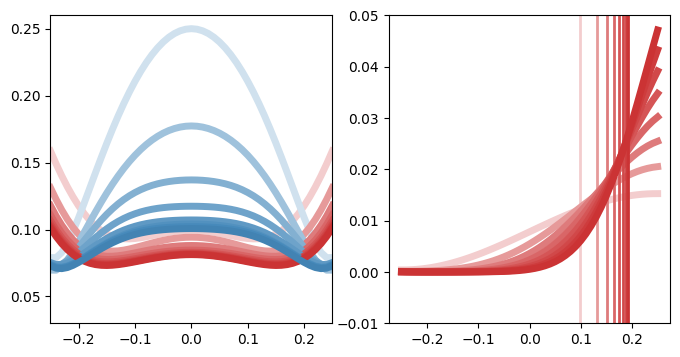

In [275]:
Delta, k, steps, R = 0.35,0,51,10

name = 'flat_prior_fullqmap_Delta={0:.2f}_p0=lover{1:.0f}_q0range(-lover4,lover4)_steps={2:.0f}'.format(Delta,k,steps)
with open(path_sBs_bayesian+name+'.pkl', 'rb') as file:
    dictionary = pickle.load(file)
    
MSE = dictionary['MSEs']
mse_q = dictionary['mse_qrange']
posteriors = dictionary['posteriors_all']
estimators = dictionary['estimators']
print(estimators.shape)

fig, axs = plt.subplots(1,2,figsize=(8,4))
ax1, ax2 = axs
T_range = np.arange(1,9,1)
for i in range(8):
    T = T_range[i]
    MSE_T = MSE[i]
    mse_qT = mse_q[i]
    posteriors_T = posteriors[i]
    estimators_T = estimators[i]

    mean_MSE = np.mean(MSE_T)

    name = 'data-noiseless-sensitivity-fullqmap-delta={0:.2f}-T={1:.0f}'.format(Delta,T)
    with open(path_sBs_MP_ML+name+'.pkl', 'rb') as file:
        dictionary = pickle.load(file)
    MSE_ML = dictionary['MSE']
    biases = dictionary['biases']
    partial_means = dictionary['partial_means']
    FIqT = dictionary['FIqT']

    shine = .2+.3*np.log(T)
    index_b = 0
    estimator = estimators_T[index_b]
    ax1.plot(q0_range/l,np.sqrt(mse_qT*steps)/l,color=lighten_color(red,shine),label='sequential',lw=5)
    ax1.plot(q0_range/l,np.sqrt(MSE_ML)/l,color=lighten_color(blue,shine),label='sequential',lw=5)
    ax2.plot(q0_range/l,posteriors_T[index_b]/l,color=lighten_color(red,shine),label='sequential',lw=5)
    ax2.plot([estimator/l,estimator/l],[-1,1],color=lighten_color(red,shine),label='sequential',lw=2)

    print(np.mean(np.sqrt(MSE_ML))/l,np.sqrt(mean_MSE)/l,np.mean(MSE_ML)-mean_MSE)

ax1.set_ylim(0.03,.26)
ax1.set_xlim(-.25,.25)
ax2.set_ylim(-.01,.05)

## simple tests to decide the number of autonomous runs after displacement back to the center

### simply checking the decay

max MSE: 0.17736035699791228 avg MSE: 0.13242993971933903 min MSE: 0.06965814430598126


/Users/labl2714/Projects/GKP-metrology/LL_env_1/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/labl2714/Projects/GKP-metrology/LL_env_1/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/Users/labl2714/Projects/GKP-metrology/LL_env_1/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(Q, P)


q: [0.6  0.58 0.56 0.55]
p: [0.4  0.42 0.44 0.45]
max MSE: 0.13705244933873367 avg MSE: 0.11219150895735128 min MSE: 0.07185952278427986
q: [0.6  0.58 0.56 0.55 0.54 0.53]
p: [0.4  0.42 0.44 0.45 0.46 0.47]
max MSE: 0.11740133006212254 avg MSE: 0.10082250767461183 min MSE: 0.07338673792624685
q: [0.6  0.58 0.56 0.55 0.54 0.53 0.53 0.52]
p: [0.4  0.42 0.44 0.45 0.46 0.47 0.47 0.48]
max MSE: 0.1071562388083143 avg MSE: 0.09402572085675687 min MSE: 0.07383182504207317
q: [0.6  0.58 0.56 0.55 0.54 0.53 0.53 0.52 0.52 0.52]
p: [0.4  0.42 0.44 0.45 0.46 0.47 0.47 0.48 0.48 0.48]
max MSE: 0.10407718524343804 avg MSE: 0.09103321122258883 min MSE: 0.07191252899741446
q: [0.6  0.58 0.56 0.55 0.54 0.53 0.53 0.52 0.52 0.52 0.51 0.51]
p: [0.4  0.42 0.44 0.45 0.46 0.47 0.47 0.48 0.48 0.48 0.49 0.49]
max MSE: 0.10213679548141145 avg MSE: 0.08997318453482496 min MSE: 0.07148460844695229
q: [0.6  0.58 0.56 0.55 0.54 0.53 0.53 0.52 0.52 0.52 0.51 0.51 0.51 0.51]
p: [0.4  0.42 0.44 0.45 0.46 0.47 0.47 0.

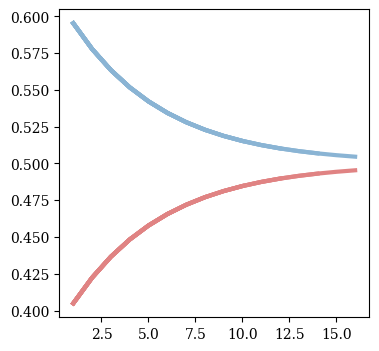

In [105]:
Delta, R0 = .35, 120
R1, k, steps, l = 15, 0, 101, np.sqrt(2*np.pi)
gauges = [0,0]
cd = np.cosh(Delta**2)
q0_range = (l/4/cd)*np.linspace(-1.0,1.0,steps)
T_range = np.arange(2,9,1)
name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,R0)
sensor = sps.load_npz(path_data_sBs_sensor+name)

fig, ax = plt.subplots(1,1,figsize=(4,4))

for T in T_range:
    name = 'data-noiseless-sensitivity-fullqmap-delta={0:.2f}-T={1:.0f}'.format(Delta,T)
    with open(path_sBs_MP_ML+name+'.pkl', 'rb') as file:
        dictionary = pickle.load(file)
    MSE = dictionary['MSE']
    biases = dictionary['biases']
    partial_means = dictionary['partial_means']
    FIqT = dictionary['FIqT']

    max_MSE = np.max(np.sqrt(MSE))
    avg_MSE = np.mean(np.sqrt(MSE))
    min_MSE = np.min(np.sqrt(MSE))
    print('max MSE:',max_MSE/l, 'avg MSE:',np.mean(np.sqrt(MSE))/l, 'min MSE:',min_MSE/l)
    q0, p0 = 0.08,0.08

    beta = (q0 + 1j*p0)/np.sqrt(2)
    U_q0p0 = Displacement(beta)
    rho0 = U_q0p0@sensor@U_q0p0.getH()
    rhos, probs_q, probs_p = sBs_cycle(Delta,2*T,rho0,gauges)
    print('q:',np.round(probs_q,2))
    print('p:',np.round(probs_p,2))

    ax.plot(np.arange(1,2*T+1,1),probs_q,color=lighten_color(blue,.5),lw=3,label=r'$\text{Tr}(\rho T_q)$')
    ax.plot(np.arange(1,2*T+1,1),probs_p,color=lighten_color(red,.5),lw=3,label=r'$\text{Tr}(\rho T_p)$')

### information rate with gaussian prior

sigma: 0.14760864374853014
[10, 11, 12, 13, 14]


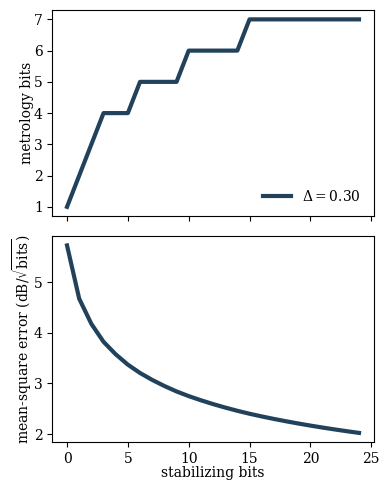

In [107]:
#consider preparation time in unit of bits 

preparation_bits = np.arange(0,25,1)
Delta_range = [.3]
R0 = 120
R1, k, steps, l = 15, 0, 51, np.sqrt(2*np.pi)
gauges = [0,0]
cd = np.cosh(Delta**2)
q0_range = (l/4/cd)*np.linspace(-1.0,1.0,steps)
T_range = np.arange(1,8,1)
stddev_range = np.arange(0.05,l/4+.1,.01)
ind = 32
sigma = stddev_range[ind]
print('sigma:',sigma/l)

fig, axs = plt.subplots(2,1,figsize=(4,5),sharex=True)
ax1, ax2 = axs

for j in range(1):
    Delta = Delta_range[j]
    T_max_avg_all = []
    avg_dB_max_all = []

    for i in range(len(preparation_bits)):
        preparation = preparation_bits[i]
        MSE_T = []
        for T in T_range:
            name = 'gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
            with open(path_sBs_bayesian+name+'.pkl', 'rb') as file:
                dictionary = pickle.load(file)
            MSE = dictionary['MSEs']
            mse_qrange = dictionary['mse_qrange']
            posteriors_all = dictionary['posteriors_all']

            MSE_T.append(MSE[ind])

        MSE_T = np.array(MSE_T)

        def two_mode_squeezing_limit(v,r):
            return np.exp(-2*r)*v/(np.exp(-2*r)+v)
        from scipy.optimize import fsolve
        def solve_for_dB(v, MSE_array):
            r_array = []
            for MSE in MSE_array:
                # Define the equation to solve
                def equation(r):
                    return two_mode_squeezing_limit(v, r) - MSE
                # Use fsolve to find the root of the equation
                r_initial_guess = 0.5 # Initial guess for r
                r_solution = fsolve(equation, r_initial_guess)
                r_array.append(r_solution[0])
            r_array = np.array(r_array)
            return 10*np.log10(np.exp(2*r_array))

        avg_dB = solve_for_dB(sigma**2,MSE_T)
        rate = T_range+preparation

        avg_dB_rate = avg_dB/np.sqrt(rate)

        # ax2.plot(T_range,avg_dB_rate,color=lighten_color(blue,1.2-.03*i),lw=3)

        T_avg_max = T_range[np.argmax(avg_dB_rate)]
        T_max_avg_all.append(T_avg_max)
        avg_dB_max = avg_dB_rate[np.argmax(avg_dB_rate)]
        avg_dB_max_all.append(avg_dB_max)
    index_4 = [preparation_bits[i] for i in range(len(preparation_bits)) if T_max_avg_all[i]==6]
    print(index_4)

    ax1.plot(preparation_bits,T_max_avg_all,color=lighten_color(blue,1.2-.3*j),lw=3,label=r'$\Delta={0:.2f}$'.format(Delta))
    ax2.plot(preparation_bits,avg_dB_max_all,color=lighten_color(blue,1.2-.3*j),lw=3)

# ax1.set_ylim(6,15.8)
# ax1.set_yticks([15,6.5])
# ax1.set_ylim(0,12)
# ax1.set_yticklabels([r'$15$',r'$6.5$'],fontsize=10)
# ax1.set_ylabel(r'$\overline{\text{MSE}}$ (dB)',fontsize=10,labelpad=-10)
ax1.set_ylabel(r'metrology bits',fontsize=10,labelpad=0)
ax2.set_ylabel(r'mean-square error (dB/$\sqrt{\text{bits}}$)',fontsize=10,labelpad=0)
ax2.set_xlabel(r'stabilizing bits',fontsize=10,labelpad=0)
ax1.legend(loc='lower right',fontsize=10,framealpha=0,ncol=2)
plt.tight_layout()
# name = 'appendix-ML-MSE-sensitivity-rate'
# fig.savefig(path_figures+name+'.pdf',bbox_inches='tight',dpi=1000)
# plt.show()

## Running random sBs 

In [4]:
Delta, R0 = .3, 120
R1, k, steps, l = 15, 0, 101, np.sqrt(2*np.pi)
gauges = [0,0]
cd = np.cosh(Delta**2)
q0_range = (l/4/cd)*np.linspace(-1.0,1.0,steps)
T_range = [2]
name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,R0)
sensor = sps.load_npz(path_data_sBs_sensor+name)
q0, p0 = l/4, -l/4
Tq, Tp = stabilizers(Delta)

beta = (q0 + 1j*p0)/np.sqrt(2)
U_q0p0 = Displacement(beta)
rho0 = U_q0p0@sensor@U_q0p0.getH()
Tq_beta, Tp_beta = displaced_stabilizers(Tq,Tp,beta)  
for T in T_range:
    probs_bits = sBs_allbits(Delta,q0,p0,sensor,T,gauges)
    print('shape', probs_bits.shape)
    rhos, probs_q, probs_p = sBs_cycle(Delta,R1,rho0,gauges)
    print('q:',np.round(probs_q,2)) 
    print('p:',np.round(probs_p,2))
    probs_q, probs_p = get_probability_bq_bp(probs_bits,T)
    prob_each_q, prob_each_p = get_probability_of_each_bit(probs_bits,T)
    print(np.round(probs_q,2),np.round(probs_p,2))
    print(np.round(prob_each_q,2),np.round(prob_each_p,2))

shape (16,)
q: [0.98 0.97 0.96 0.93 0.9  0.87 0.84 0.81 0.78 0.75 0.72 0.69 0.67 0.65
 0.63]
p: [0.02 0.03 0.04 0.07 0.1  0.13 0.16 0.19 0.22 0.25 0.28 0.31 0.33 0.35
 0.37]
[0.96 0.02 0.02 0.  ] [0.   0.02 0.02 0.96]
[0.98 0.97] [0.02 0.03]


## backaction evading simple run

### with ML (deprecated)

In [5]:
Delta, R0 = .3, 120
R1, k, steps, l = 15, 0, 101, np.sqrt(2*np.pi)
cd = np.cosh(Delta**2)
gauges = [0,0]
q0_range = (l/4/cd)*np.linspace(-1.0,1.0,steps)
p0_range = (l/4/cd)*np.linspace(-1.0,1.0,steps)
T_range = [8]
name_probs = 'probabilities_Delta={0:.2f}_R={1:.0f}_p0=lover{2:.0f}_q0range(-lover4,lover4)_steps={3:.0f}'.format(Delta,R1,k,steps)
probs_qp0 = np.load(path_data_sBs_probabilities+name_probs+'.npy')
name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,R0)
sensor = sps.load_npz(path_data_sBs_sensor+name)
q0, p0 = l/4, -l/4

beta = (q0 + 1j*p0)/np.sqrt(2)
U_q0p0 = Displacement(beta)
rho0 = U_q0p0@sensor@U_q0p0.getH()
Tq, Tp = stabilizers(Delta)
repeat_baem = 1
for T in T_range:
    R_metrology = T
    R_stabilizing = T
    name = 'estimators_ML_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range=(-lover4,lover4)'.format(Delta,T,k)
    estimators_allqbits_p0 = np.load(path_sBs_MP_ML+name+'.npy')
    name = 'estimators_ML_Delta={0:.2f}_T={1:.0f}_q0=lover{2:.0f}_p0range=(-lover4,lover4)'.format(Delta,T,k)
    estimators_allpbits_q0 = np.load(path_sBs_MP_ML+name+'.npy')
    # rho, final_gauge, bits, estq, estp = sBs_random_bits_probs_estimators(Delta,q0,p0,sensor,R,T,estimators_allqbits_p0,estimators_allpbits_q0,gauges)
    rho, squared_errors_q, squared_errors_p, estimators_q, estimators_p  = backaction_evading_sBs_run(Delta,q0,p0,sensor,repeat_baem, R_metrology,R_stabilizing,estimators_allqbits_p0,estimators_allpbits_q0,gauges)
    print(np.round(squared_errors_q,3),np.round(squared_errors_p,3))

TypeError: backaction_evading_sBs_run() missing 1 required positional argument: 'exp_qrange_allqbits'

1.0000000262942026


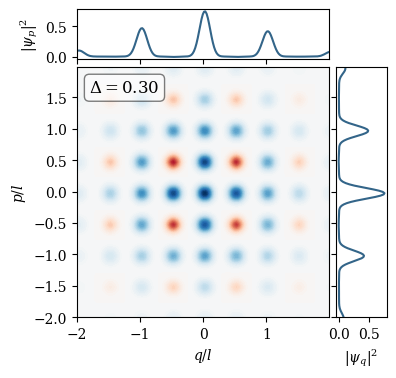

In [116]:
rho = qt.Qobj(rho)
print(rho.tr())
xvec = np.arange(-2*l,2*l,0.05)
W = qt.wigner(rho, xvec, xvec)

# Assuming W, xvec, and l are already defined
row_marginal = np.sum(W, axis=0)*(xvec[1]-xvec[0])
column_marginal = np.sum(W, axis=1)*(xvec[1]-xvec[0])

# Normalize the color scale
nrm = mpl.colors.Normalize(-W.max(), W.max())

# Create the main plot and the marginal plots
fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(2, 2, width_ratios=(5, 1), height_ratios=(1, 5), hspace=0.05, wspace=0.05)

# Main contour plot
ax_main = fig.add_subplot(gs[1, 0])
contour = ax_main.contourf(xvec/l, xvec/l, W, 100, cmap=cm.RdBu, norm=nrm)
ax_main.set_xlabel(r'$q/l$')
ax_main.set_ylabel(r'$p/l$')

# Row marginal plot
ax_row = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_row.plot(xvec/l, row_marginal, color=blue)
ax_row.set_ylabel(r'$|\psi_p|^2$')
ax_row.xaxis.set_tick_params(labelbottom=False)

# Column marginal plot
ax_col = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_col.plot(column_marginal, xvec/l, color=blue)
ax_col.set_xlabel(r'$|\psi_q|^2$')
ax_col.yaxis.set_tick_params(labelleft=False)

# Add textbox with the value of Delta
textstr = r'$\Delta = {0:.2f}$'.format(Delta)
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax_main.text(0.05, 0.95, textstr, transform=ax_main.transAxes, fontsize=12,
             verticalalignment='top', bbox=props)

plt.show()

### with bayesian

In [10]:
#work here now
Delta, R0 = .3, 120
R1, k, steps, l = 10, 0, 51, np.sqrt(2*np.pi)
cd = np.cosh(Delta**2)
gauges = [0,0]
q0_range = (l/4/cd)*np.linspace(-1.0,1.0,steps)
p0_range = (l/4/cd)*np.linspace(-1.0,1.0,steps)
T_range = [4]
name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,R0)
sensor = sps.load_npz(path_data_sBs_sensor+name)

stddev_range = np.arange(0.05,l/4+.1,.01)
mean, sigma = 0,0.15*l
num_samples = 2
samples = np.random.normal(mean, sigma, num_samples)
index_sigma = np.argmin(np.abs(stddev_range-sigma))

q0, p0 = samples[0], samples[1]
q0, p0 = l/4,l/4
# print('q0,p0',q0/l,p0/l)

repeat_baem = 2
M = 4
for T in T_range:
    steps2 = 101
    qrange = (l)*np.linspace(-1.0,1.0,steps2)
    name = 'expectation_value_q_allqbits_Bayesian_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps2)
    exp_qrange_allqbits = np.load(path_sBs_bayesian+name+'.npy')
    
    name = 'gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
    with open(path_sBs_bayesian+name+'.pkl', 'rb') as file:
        dictionary = pickle.load(file)
    MSE = dictionary['MSEs']
    mse_qrange = dictionary['mse_qrange']
    posteriors_all = dictionary['posteriors_all']
    estimators_all = dictionary['estimators_all']
    estimators_allqbits_p0 = estimators_all[index_sigma]
    estimators_allpbits_q0 = estimators_all[index_sigma]

    rhos, squared_errors_q, squared_errors_p, estimators_q, estimators_p  = backaction_evading_sBs_run(Delta,q0,p0,sensor,repeat_baem, T,M,estimators_allqbits_p0,estimators_allpbits_q0,gauges,exp_qrange_allqbits)
    print('errors',np.round(np.sqrt(squared_errors_q)/l,3),np.round(np.sqrt(squared_errors_p)/l,3))

errors [0.081 0.081] [0.081 0.081]


## Center of phase-space after T rounds

Here, I save the center of phase-space for different displacements after T rounds. These are to be used in the backaction evading protocol. After a bitstrings is meausred, it has a corresponding estimator. Then, choose the closest value of this dataset to that estimator to proxy the center of phase space, and with that the recovery displacement

In [102]:
#work here now
Delta, R0 = .3, 120
R1, k, steps, l = 10, 0, 201, np.sqrt(2*np.pi)
cd = np.cosh(Delta**2)
gauges = [0,0]
q0_range = (l)*np.linspace(-1.0,1.0,steps)
p0_range = (l)*np.linspace(-1.0,1.0,steps)
T_range = np.arange(2,11,1)
name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,R0)
sensor = sps.load_npz(path_data_sBs_sensor+name)
Tq, Tp = stabilizers(Delta)

if k==0:
    p0 = 0
else:
    p0 = l/k

for T in T_range:
    exp_qrange_allqbits = []
    for q0 in tqdm(q0_range):
        exp_q_allqbits = sBs_allqbits_center(Delta,q0,p0,sensor,T,gauges)
        exp_qrange_allqbits.append(exp_q_allqbits)
    exp_qrange_allqbits = np.array(exp_qrange_allqbits)
    print(exp_qrange_allqbits.shape)
    name = 'expectation_value_q_allqbits_Bayesian_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
    np.save(path_sBs_bayesian+name,exp_qrange_allqbits)

/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/scipy/sparse/_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(Q, P)
100%|██████████| 201/201 [02:13<00:00,  1.50it/s]


(201, 4)


100%|██████████| 201/201 [02:26<00:00,  1.37it/s]


(201, 8)


100%|██████████| 201/201 [02:49<00:00,  1.19it/s]


(201, 16)


100%|██████████| 201/201 [03:30<00:00,  1.05s/it]


(201, 32)


/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 201/201 [04:57<00:00,  1.48s/it]


(201, 64)


100%|██████████| 201/201 [08:09<00:00,  2.44s/it]


(201, 128)


100%|██████████| 201/201 [15:09<00:00,  4.53s/it]


(201, 256)


 83%|████████▎ | 167/201 [25:29<05:11,  9.16s/it]


KeyboardInterrupt: 

## Backaction evading, testing return to the initial state

### Bayesian, saving data

In [19]:
#work here now
Delta, R0 = .3, 120
R1, k, steps, l = 10, 0, 51, np.sqrt(2*np.pi)
cd = np.cosh(Delta**2)
gauges = [0,0]
name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,R0)
sensor = sps.load_npz(path_data_sBs_sensor+name)
mean, sigma = 0,0.15
stddev_range = np.arange(0.05,l/4+.1,.01)
index_sigma = np.argmin(np.abs(stddev_range-0.15))

T_range = np.arange(10,11)
T_range = [2]
T_dict = {2:10,3:9,4:8,5:7,6:6,7:5,8:4,9:3,10:2}  # Mapping T to the corresponding M value
for T in T_range:
    if T % 2 == 0:
        name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,R0)
        sensor_gauge = sps.load_npz(path_data_sBs_sensor+name)
    else:
        name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,R0)
        sensor_gauge = sps.load_npz(path_data_sBs_sensor+name)
    steps2 = 101
    qrange = (l)*np.linspace(-1.0,1.0,steps2)
    # name = 'expectation_value_q_allqbits_Bayesian_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps2)
    # exp_qrange_allqbits = np.load(path_sBs_bayesian+name+'.npy')
    exp_qrange_allqbits = []

    if k==0:
        p0 = 0
    else:
        p0 = l/k

    Tq, Tp = stabilizers(Delta)

    steps3 = 51
    q_test = (l/2)*np.linspace(0,1.0,steps3)
    name = 'gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
    with open(path_sBs_bayesian+name+'.pkl', 'rb') as file:
        dictionary = pickle.load(file)
    estimators_all = dictionary['estimators_all']
    estimators_allqbits_p0 = estimators_all[index_sigma]
    estimators_allpbits_q0 = estimators_all[index_sigma]

    # M_range = np.arange(10,13,2)

    # for M in tqdm(M_range):
    M = T_dict[T]
    fidelities_yes = []
    fidelities_no = []
    fidelities_yes_simple = []
    fidelities_yes_filter = []
    for q0 in q_test:
        # fidelities_yes.append(backaction_evading_sBs_fidelities_probs_allqbits(Delta,q0,p0,sensor,T,M,estimators_allqbits_p0,estimators_allpbits_q0,gauges,exp_qrange_allqbits,sensor_gauge))
        fidelities_yes_simple.append(backaction_evading_sBs_fidelities_probs_allqbits_simplerecovery(Delta,q0,p0,sensor,T,M,estimators_allqbits_p0,estimators_allpbits_q0,gauges,exp_qrange_allqbits,sensor_gauge))
        # fidelities_yes_filter.append(backaction_evading_sBs_fidelities_probs_allqbits_filterrecovery(Delta,q0,p0,sensor,T,M,estimators_allqbits_p0,estimators_allpbits_q0,gauges,exp_qrange_allqbits,sensor_gauge))
        # fidelities_no.append(backaction_evading_sBs_fidelities_probs_allqbits_norecovery(Delta,q0,p0,sensor,T,M,estimators_allqbits_p0,estimators_allpbits_q0,gauges,exp_qrange_allqbits,sensor_gauge))
    # fidelities_yes = np.array(fidelities_yes)
    # fidelities_no = np.array(fidelities_no)
    fidelities_yes_simple = np.array(fidelities_yes_simple)
    # fidelities_yes_filter = np.array(fidelities_yes_filter)
    name_yes = 'fidelities_probs_allqbits_bayesian_BArecovery=yes_Delta={0:.2f}_T={1:.0f}_M={2:.0f}_p0=lover{3:.0f}_q0range(0,lover2)_steps={4:.0f}'.format(Delta,T,M,k,steps3)
    name_yes_simple = 'fidelities_probs_allqbits_bayesian_BArecoverysimple=yes_Delta={0:.2f}_T={1:.0f}_M={2:.0f}_p0=lover{3:.0f}_q0range(0,lover2)_steps={4:.0f}'.format(Delta,T,M,k,steps3)
    name_yes_filter = 'fidelities_probs_allqbits_bayesian_BArecoveryfilter=yes_Delta={0:.2f}_T={1:.0f}_M={2:.0f}_p0=lover{3:.0f}_q0range(0,lover2)_steps={4:.0f}'.format(Delta,T,M,k,steps3)
    name_no = 'fidelities_probs_allqbits_bayesian_BArecovery=no_Delta={0:.2f}_T={1:.0f}_M={2:.0f}_p0=lover{3:.0f}_q0range(0,lover2)_steps={4:.0f}'.format(Delta,T,M,k,steps3)
    # np.save(path_sBs_MP_BA+name_yes,fidelities_yes)
    np.save(path_sBs_MP_BA+name_yes_simple,fidelities_yes_simple)
    # np.save(path_sBs_MP_BA+name_yes_filter,fidelities_yes_filter)
    # np.save(path_sBs_MP_BA+name_no,fidelities_no)

/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/scipy/sparse/_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(Q, P)
/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/

### bayesian, dermining wheter the recovery is helpful or not

(16,) (16,)
[ 0.05589034  0.03160716  0.02791373  0.00773781  0.0236356   0.00391343
  0.00069914 -0.01874424  0.01874424 -0.00069914 -0.00391343 -0.0236356
 -0.00773781 -0.02791373 -0.03160716 -0.05589034]


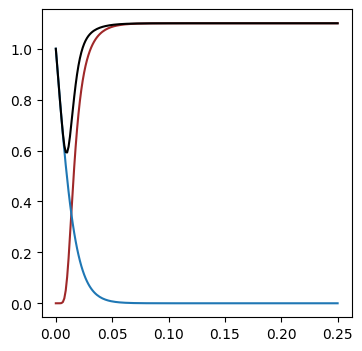

In [29]:
qtest = (l/4)*np.linspace(0,1.0,200)
fig, ax = plt.subplots(1,1,figsize=(4,4))

T = 4
steps3 = 51
q_test = (l/2)*np.linspace(0,1.0,steps3)
name = 'gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
with open(path_sBs_bayesian+name+'.pkl', 'rb') as file:
    dictionary = pickle.load(file)
estimators_all = dictionary['estimators_all']
estimators_allqbits_p0 = estimators_all[index_sigma]
estimators_allpbits_q0 = estimators_all[index_sigma]

print(estimators_allqbits_p0.shape, estimators_allpbits_q0.shape)
print(estimators_allqbits_p0/l)

c1 = 0.03
c2 = 0.005
a = np.arctanh(1/1.1)/c1/l
b = np.arctanh(1.1 * np.tanh(a * c2 * l))/c2/l
def f1(q):
    return  1.1 * np.tanh(a * q) * np.tanh(50 * q)**10
def f2(q):
    return 1 - np.tanh(b * q)

ax.plot(qtest/l, f1(qtest), color=red)
ax.plot(qtest/l, f2(qtest))
ax.plot(qtest/l, f1(qtest) + f2(qtest), label='f1+f2', color='black')

purity: [[1.   +0.j 1.   +0.j 1.   +0.j 1.   +0.j]
 [1.   +0.j 1.   +0.j 1.   +0.j 1.   +0.j]
 [1.   +0.j 1.   +0.j 1.   +0.j 1.   +0.j]
 [1.   +0.j 1.   +0.j 1.   +0.j 1.   +0.j]
 [1.   +0.j 1.   +0.j 1.   +0.j 1.   +0.j]
 [1.   +0.j 1.   +0.j 1.   +0.j 1.   +0.j]
 [1.   +0.j 1.   +0.j 1.   +0.j 1.   +0.j]
 [1.   +0.j 1.   +0.j 1.   +0.j 1.   +0.j]
 [1.   +0.j 1.   +0.j 1.   +0.j 1.   +0.j]
 [1.   +0.j 1.   +0.j 1.   +0.j 1.   +0.j]
 [1.   +0.j 1.   +0.j 1.   +0.j 1.   +0.j]
 [1.   +0.j 1.   +0.j 1.   +0.j 0.999+0.j]
 [1.   +0.j 1.   +0.j 1.   +0.j 0.999+0.j]
 [0.999+0.j 1.   +0.j 1.   +0.j 0.999+0.j]
 [0.999+0.j 1.   +0.j 0.999+0.j 0.998+0.j]
 [0.999+0.j 0.999+0.j 0.999+0.j 0.997+0.j]
 [0.999+0.j 0.999+0.j 0.998+0.j 0.994+0.j]
 [0.998+0.j 0.998+0.j 0.995+0.j 0.989+0.j]
 [0.998+0.j 0.995+0.j 0.99 +0.j 0.979+0.j]
 [0.997+0.j 0.992+0.j 0.981+0.j 0.958+0.j]
 [0.996+0.j 0.984+0.j 0.963+0.j 0.92 +0.j]
 [0.995+0.j 0.972+0.j 0.931+0.j 0.852+0.j]
 [0.994+0.j 0.949+0.j 0.876+0.j 0.748+0.j]
 [0

(0.0, 0.3)

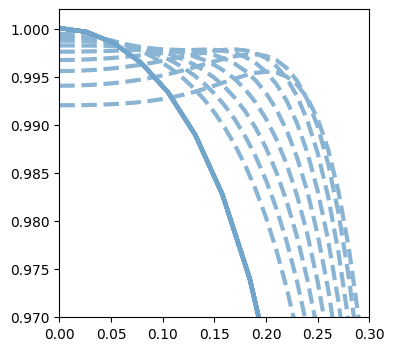

In [16]:
Delta, k, steps3 = 0.3, 0, 51
q_test = (l/2)*np.linspace(0,1.0,steps3)
q_test20 = (l/2)*np.linspace(0,1.0,20)

fig, ax = plt.subplots(1,1,figsize=(4,4))

T_range =  np.arange(2,11)
# M_range = np.arange(10,13,2)
M_range = [10]
T_dict = {2:10,3:9,4:8,5:7,6:6,7:5,8:4,9:3,10:2}  # Mapping T to the corresponding M value
sigma = 0.15*l
styles = ['-',(2,(2,1)),(1,(1,1)),(1,(1,2))]
colors = [light_blue,blue,green,red]
fidelities_yes_all = []
fidelities_yes_simple_all = []
fidelities_no_all = []
for j in range(len(T_range)):
    style = styles[j%len(styles)]
    T = T_range[j]
    # for i in range(len(M_range)):
        # M = M_range[i]
    M = T_dict[T]
    shine = .5 

    name_recovery = 'fidelities_probs_allqbits_bayesian_BArecovery=yes_Delta={0:.2f}_T={1:.0f}_M={2:.0f}_p0=lover{3:.0f}_q0range(0,lover2)_steps={4:.0f}'.format(Delta,T,M,k,20)
    name_recovery_simple = 'fidelities_probs_allqbits_bayesian_BArecoverysimple=yes_Delta={0:.2f}_T={1:.0f}_M={2:.0f}_p0=lover{3:.0f}_q0range(0,lover2)_steps={4:.0f}'.format(Delta,T,M,k,steps3)
    # name_recovery_filter = 'fidelities_probs_allqbits_bayesian_BArecoveryfilter=yes_Delta={0:.2f}_T={1:.0f}_M={2:.0f}_p0=lover{3:.0f}_q0range(0,lover2)_steps={4:.0f}'.format(Delta,T,M,k,steps3)
    name_norecovery = 'fidelities_probs_allqbits_bayesian_BArecovery=no_Delta={0:.2f}_T={1:.0f}_M={2:.0f}_p0=lover{3:.0f}_q0range(0,lover2)_steps={4:.0f}'.format(Delta,T,M,k,20)
    fidelities_probs_yes = np.load(path_sBs_MP_BA+name_recovery+'.npy')
    fidelities_probs_yes_simple = np.load(path_sBs_MP_BA+name_recovery_simple+'.npy')
    # fidelities_probs_yes_filter = np.load(path_sBs_MP_BA+name_recovery_filter+'.npy')
    fidelities_probs_no = np.load(path_sBs_MP_BA+name_norecovery+'.npy')

    fidelities_yes = fidelities_probs_yes[:,:,0]
    fidelities_yes_simple = fidelities_probs_yes_simple[:,:,0]
    # fidelities_yes_filter = fidelities_probs_yes_filter[:,:,0]
    fidelities_no = fidelities_probs_no[:,:,0]
    probs_yes = fidelities_probs_yes[:,:,1]
    probs_yes_simple = fidelities_probs_yes_simple[:,:,1]
    # probs_yes_filter = fidelities_probs_yes_filter[:,:,1]
    probs_no = fidelities_probs_no[:,:,1]

    if T==2:
        purity = fidelities_probs_yes_simple[:,:,2]
        print('purity:',np.round(purity,3))

    avg_fidelities_yes = []
    avg_fidelities_yes_simple = []
    # avg_fidelities_yes_filter = []
    avg_fidelities_no = []
    for index_q0 in range(20):
        avg_fidelities_yes.append(np.dot(fidelities_yes[index_q0],probs_yes[index_q0]))
        avg_fidelities_no.append(np.dot(fidelities_no[index_q0],probs_no[index_q0]))
    for index_q0 in range(steps3):    
        avg_fidelities_yes_simple.append(np.dot(fidelities_yes_simple[index_q0],probs_yes_simple[index_q0]))
        # avg_fidelities_yes_filter.append(np.dot(fidelities_yes_filter[index_q0],probs_yes_filter[index_q0]))
        
    avg_fidelities_yes = np.real(np.array(avg_fidelities_yes))
    avg_fidelities_yes_simple = np.real(np.array(avg_fidelities_yes_simple))
    # avg_fidelities_yes_filter = np.real(np.array(avg_fidelities_yes_filter))
    avg_fidelities_no = np.real(np.array(avg_fidelities_no))
    
    # ax.plot(q_test20/l,avg_fidelities_yes,color=lighten_color(red,1.1),lw=3, ls='-')
    ax.plot(q_test/l,avg_fidelities_yes_simple,color=lighten_color(blue,shine),lw=3, ls='--')
    # ax.plot(q_test/l,avg_fidelities_yes_filter,color=lighten_color(green,shine),lw=3, ls='-.')
    ax.plot(q_test20/l,avg_fidelities_no,color=lighten_color(blue,.6),lw=3,ls='-')

    prior = np.exp(-q_test**2/(2*sigma**2))
    prior /= np.sum(prior)
    prior20 = np.exp(-q_test20**2/(2*sigma**2))
    prior20 /= np.sum(prior20)
    flat_prior = np.ones_like(prior)
    index_q0_lover4 = np.argmin(np.abs(q_test-l/4))
    flat_prior[index_q0_lover4:] = 0
    flat_prior /= np.sum(flat_prior)
    flat_prior20 = np.ones_like(prior20)
    flat_prior20 /= np.sum(flat_prior20)

    weighted_fidelities_yes = avg_fidelities_yes * prior20
    weighted_fidelities_yes_simple = avg_fidelities_yes_simple * prior
    # weighted_fidelities_yes_filter = avg_fidelities_yes_filter * prior
    weighted_fidelities_no = avg_fidelities_no * prior20
    flat_weighted_fidelities_yes = avg_fidelities_yes * flat_prior20
    flat_weighted_fidelities_yes_simple = avg_fidelities_yes_simple * flat_prior
    # flat_weighted_fidelities_yes_filter = avg_fidelities_yes_filter * flat_prior
    flat_weighted_fidelities_no = avg_fidelities_no * flat_prior20
    print(T,'weighted fidelities yes:',np.sum(weighted_fidelities_yes))
    print(T,'weighted fidelities yes simple:',np.sum(weighted_fidelities_yes_simple))
    # print(T,'weighted fidelities yes filter:',np.sum(weighted_fidelities_yes_filter))
    print(T,'weighted fidelities no:',np.sum(weighted_fidelities_no))
    print(T,'flat weighted fidelities yes:',np.sum(flat_weighted_fidelities_yes))
    print(T,'flat weighted fidelities yes simple:',np.sum(flat_weighted_fidelities_yes_simple))
    # print(T,'flat weighted fidelities yes filter:',np.sum(flat_weighted_fidelities_yes_filter))
    print(T,'flat weighted fidelities no:',np.sum(flat_weighted_fidelities_no))

    fidelities_yes_all.append(avg_fidelities_yes)
    fidelities_yes_simple_all.append(avg_fidelities_yes_simple)
    fidelities_no_all.append(avg_fidelities_no)

    fidelity_95 = q_test[np.argmin(np.abs(avg_fidelities_yes-.95))]
    print('fidelity_95:',fidelity_95/l)

dict_figure = {}
dict_figure['fidelities_yes_all'] = fidelities_yes_all
dict_figure['fidelities_yes_simple_all'] = fidelities_yes_simple_all
dict_figure['fidelities_no_all'] = fidelities_no_all    
dict_figure['q_test'] = q_test
print(len(fidelities_yes_all))
name = 'data-figure-fidelities-BA'
with open(path_figures_data+name +'.pkl', 'wb') as f:
    pickle.dump(dict_figure, f, pickle.HIGHEST_PROTOCOL)

ax.set_ylim(.97,1.002)
ax.set_xlim(0,.3)
# ax.plot([0,.5],[.95,.95],color='black')
# ax.plot([.3,.3],[.5,1],color='black')

## mixed density matrix to characterize backaction evading performance

In [ ]:
Delta, R0 = .3, 120
name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,R0)
sensor = sps.load_npz(path_data_sBs_sensor+name)
gauges = [0,0]
steps = 60
sigma = 0.3
mix_rho = backaction_mixed_rho(sigma,Delta,R,sensor,gauges,steps)

### fidelity with the initial state after displacement

In [20]:
Delta, R0 = .3, 120
R1, k, steps, l = 10, 0, 51, np.sqrt(2*np.pi)
cd = np.cosh(Delta**2)
gauges = [0,0]
name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,R0)
sensor = sps.load_npz(path_data_sBs_sensor+name)
qrange = np.linspace(0,l,steps)

fidelities = []
for q0 in tqdm(qrange):
    U_q0 = Displacement(q0/np.sqrt(2))
    rho0 = U_q0@sensor@U_q0.getH()
    fidelities.append(qt.fidelity(qt.Qobj(rho0),qt.Qobj(sensor)))

  0%|          | 0/51 [00:00<?, ?it/s]/Users/labl2714/Projects/GKP-metrology/LL_env_1/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/labl2714/Projects/GKP-metrology/LL_env_1/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
100%|██████████| 51/51 [00:25<00:00,  2.00it/s]


0.99 0.02
0.95 0.05999999999999999
0.9 0.08


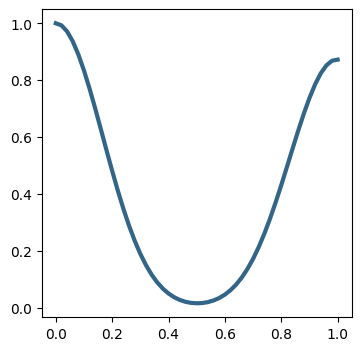

In [ ]:
fidelities=np.array(fidelities)

fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(qrange/l,fidelities,color=blue,lw=3)

fidelity_995 = qrange[np.argmin(np.abs(fidelities-.995))]
print('0.995',fidelity_995/l)
fidelity_99 = qrange[np.argmin(np.abs(fidelities-.99))]
print('0.99',fidelity_99/l)
fidelity_95 = qrange[np.argmin(np.abs(fidelities-.95))]
print('0.95',fidelity_95/l)
fidelity_90 = qrange[np.argmin(np.abs(fidelities-.9))]
print('0.9',fidelity_90/l)

## backaction evading parallel runs

### in q0 range, one repeat

In [ ]:
# def running_BAEM_parallel(Delta,q0,p0,sensor,repeat_baem, R_metrology,R_stabilizing, T,estimators_allqbits_p0,estimators_allpbits_q0,gauges,runs):
    
#     def single_run():
#         squared_errors_q, squared_errors_p, estimators_q, estimators_p  = backaction_evading_sBs_run_notrhos(Delta,q0,p0,sensor,repeat_baem, R_metrology,R_stabilizing, T,estimators_allqbits_p0,estimators_allpbits_q0,gauges)
#         return np.array([squared_errors_q, squared_errors_p, estimators_q, estimators_p])

#     result = Parallel(n_jobs=-1)(delayed(single_run)() for _ in range(runs))
#     return np.array(result)#shape [run][0=SEq,1=SEp,2=estq,3=estp][repeats]

# Delta, R0 = .3, 120
# R1, k, steps, l = 15, 4, 51, np.sqrt(2*np.pi)
# cd = np.cosh(Delta**2)
# gauges = [0,0]
# q0_range = (l/4/cd)*np.linspace(-1.0,1.0,steps)
# T = 14
# name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,R0)
# sensor = sps.load_npz(path_data_sBs_sensor+name)
# Tq, Tp = stabilizers(Delta)

# if k==0:
#     p0 = 0
# else:
#     p0 = l/k
# runs = 1000
# repeat_baem = 1
# R_metrology = T
# R_stabilizing = T
# name = 'estimators_ML_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range=(-lover4,lover4)'.format(Delta,T,k)
# estimators_allqbits_p0 = np.load(path_sBs_MP_ML+name+'.npy')
# name = 'estimators_ML_Delta={0:.2f}_T={1:.0f}_q0=lover{2:.0f}_p0range=(-lover4,lover4)'.format(Delta,T,k)
# estimators_allpbits_q0 = np.load(path_sBs_MP_ML+name+'.npy')

# results_q0 = []
# for q0 in tqdm(q0_range):
#     result = running_BAEM_parallel(Delta,q0,p0,sensor,repeat_baem, R_metrology,R_stabilizing, T,estimators_allqbits_p0,estimators_allpbits_q0,gauges,runs)
#     results_q0.append(result)
# results_q0 = np.array(results_q0)#shape [index_q0][run][0=SEq,1=SEp,2=estq,3=estp][repeats]
# name = 'backaction_evading_sBs_Delta={0:.2f}_Rmet=Rstab={1:.0f}_p0=lover{2:.0f}_q0range(-lover4,lover4,steps={3:.0f})_runs={4:.0f}_repeats={5:.0f}'.format(Delta,T,k,steps,runs,repeat_baem)
# np.save(path_sBs_MP_BA+name,results_q0)

### Sampling q0,p0 many repeats

In [4]:
def running_BAEM_parallel(Delta,sigma,sensor,repeat_baem,T, M, estimators_allqbits_p0,estimators_allpbits_q0,gauges,exp_qrange_allqbits,runs):
    
    def single_run():
        # squared_errors_q, squared_errors_p, estimators_q, estimators_p, q0s, p0s, bitstrings  = backaction_evading_sBs_run_notrhos(Delta,sigma,sensor,repeat_baem, T, M ,estimators_allqbits_p0,estimators_allpbits_q0,gauges,exp_qrange_allqbits)
        squared_errors_q, squared_errors_p, estimators_q, estimators_p, q0s, p0s, bitstrings  = backaction_evading_sBs_run_notrhos_simple(Delta,sigma,sensor,repeat_baem, T, M ,estimators_allqbits_p0,estimators_allpbits_q0,gauges,exp_qrange_allqbits)

        return np.array([squared_errors_q, squared_errors_p, estimators_q, estimators_p, q0s, p0s])

    result = Parallel(n_jobs=20)(delayed(single_run)() for _ in tqdm(range(runs)))
    return np.array(result)#shape [run][0=SEq,1=SEp,2=estq,3=estp][repeats]

Delta, R0 = .3, 120
R1, k, steps, l = 15, 0, 51, np.sqrt(2*np.pi)
gauges = [0,0]
T_range = [8]
M_range = [8]
T_dict = {2:10,3:9,4:8,5:7,6:6,7:5,8:4,9:3,10:2}  # Mapping T to the corresponding M value
name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,R0)
sensor = sps.load_npz(path_data_sBs_sensor+name)
stddev_range = np.arange(0.05,l/4+.1,.01)
sigma = 0.15*l
sigma = stddev_range[np.argmin(np.abs(stddev_range-sigma))] # here change from 0.15 to 0.1
index_sigma = np.argmin(np.abs(stddev_range-sigma))
print('sigma:',sigma/l)

for T in T_range:
    steps2 = 101
    qrange = (l)*np.linspace(-1.0,1.0,steps2)
    name = 'expectation_value_q_allqbits_Bayesian_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps2)
    exp_qrange_allqbits = np.load(path_sBs_bayesian+name+'.npy')

    name = 'gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
    with open(path_sBs_bayesian+name+'.pkl', 'rb') as file:
        dictionary = pickle.load(file)
    estimators_all = dictionary['estimators_all']
    estimators_allqbits_p0 = estimators_all[index_sigma]
    estimators_allpbits_q0 = estimators_all[index_sigma]

    runs_range = [4000]
    # M = T_dict[T]
    for M in M_range:
        for runs in runs_range:
            repeat_baem = 15
            result = running_BAEM_parallel(Delta,sigma,sensor,repeat_baem, T,M, estimators_allqbits_p0, estimators_allpbits_q0, gauges, exp_qrange_allqbits, runs)

            result = np.array(result)

            # name = 'backaction_evading_bayesian_Delta={0:.2f}_T={1:.0f}_M={2:.0f}_sigma={3:.2f}_runs={4:.0f}_repeats={5:.0f}'.format(Delta,T,M,sigma/l,runs,repeat_baem)
            name = 'backaction_evading_simple_bayesian_Delta={0:.2f}_T={1:.0f}_M={2:.0f}_sigma={3:.2f}_runs={4:.0f}_repeats={5:.0f}'.format(Delta,T,M,sigma/l,runs,repeat_baem)
            np.save(path_sBs_MP_BA+name,result)

sigma: 0.15159806655254446


  0%|          | 20/4000 [00:00<00:31, 125.46it/s]/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve

In [31]:
print(result.shape)

(2, 6, 2)


### plotting N = 1, to see convergence

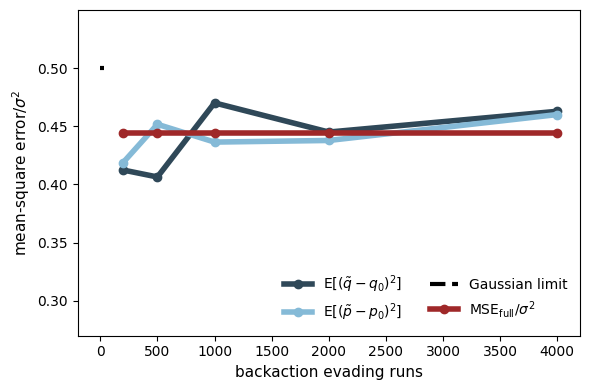

In [13]:
Delta = 0.3
k = 0
T = 8
M = 1
stddev_range = np.arange(0.05,l/4+.1,.01)
sigma = stddev_range[np.argmin(np.abs(stddev_range-0.1*l))]
index_sigma = np.argmin(np.abs(stddev_range-sigma))
runs_range = [200,500,1000,2000,4000]
repeat_baem = 1
steps = 51

fig, ax = plt.subplots(1,1,figsize=(6,4))
x_range = np.array(runs_range)

mean_MSE_q_runs = []
mean_MSE_p_runs = []

for i in range(len(runs_range)):
    runs = runs_range[i]
    name = 'backaction_evading_bayesian_Delta={0:.2f}_T={1:.0f}_M={2:.0f}_sigma={3:.2f}_runs={4:.0f}_repeats={5:.0f}'.format(Delta,T,M,sigma/l,runs,repeat_baem)
    result = np.load(path_sBs_MP_BA+name+'.npy',allow_pickle=True)

    name = 'gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
    with open(path_sBs_bayesian+name+'.pkl', 'rb') as f:
        dictionary = pickle.load(f)
    MSE = dictionary['MSEs']
    MSE_q = dictionary['mse_qrange']

    min_MSE = np.min(MSE/stddev_range**2)

    squared_errors_q = result[:,0,:]
    squared_errors_p = result[:,1,:]
    mean_MSE_q = np.mean(squared_errors_q,axis=0)
    mean_MSE_p = np.mean(squared_errors_p,axis=0)

    mean_MSE_q_runs.append(mean_MSE_q)
    mean_MSE_p_runs.append(mean_MSE_p)

    # mean_means_MSE_q = np.mean(mean_MSE_q[1:])/sigma**2
    # mean_means_MSE_p = np.mean(mean_MSE_p[1:])/sigma**2
    # stddev_means_MSE_q = np.std(mean_MSE_q[1:])/sigma**2
    # stddev_means_MSE_p = np.std(mean_MSE_p[1:])/sigma**2
    

steps2 = 101
name = 'gaussian_prior_fullmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps2)
name = 'gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)

with open(path_sBs_bayesian+name+'.pkl', 'rb') as f:
    dictionary = pickle.load(f)
MSEs = dictionary['MSEs']

shine = 1.0
ax.plot(x_range,mean_MSE_q_runs/sigma**2,color=lighten_color(dark_blue,shine),lw=4,label=r'E$[(\tilde q-q_0)^2]$',marker='o')
ax.plot(x_range,mean_MSE_p_runs/sigma**2,color=lighten_color(light_blue,shine),lw=4,label=r'E$[(\tilde p-p_0)^2]$',marker='o')
ax.plot([1,31],[.5,.5],color='black',ls='--',lw=3,label=r'Gaussian limit')

stddev_range = np.arange(0.05,l/4+.1,.01)
ax.plot(x_range, MSEs[index_sigma]/stddev_range[index_sigma]**2*np.ones(len(x_range)),color=lighten_color(red,shine),lw=4,label=r'$\text{MSE}_{\text{full}}/\sigma^2$',marker='o')    

# ax.set_xticks([1,15,30])
ax.set_yticks([.3,.35,.4,.45,.5])
ax.set_xlabel(r'backaction evading runs',fontsize=11)
ax.set_ylabel(r'mean-square error$/\sigma^2$',fontsize=11)

ax.set_ylim(0.27,.55)
# ax.set_xlim(1,15)
ax.legend(loc='lower right',fontsize=10,ncol=2,framealpha=0)
plt.tight_layout()
name = 'backaction_evading_MSE'
fig.savefig(path_figures+name+'.pdf',bbox_inches='tight',dpi=1000)

### plotting

T: 4 M: 8
T: 4 M: 8 0.46551831835653634 0.4592237978420316
T: 4 M: 8 0.4445595327989763 0.4503039965011641
T: 4 0.4163842969259451
T: 8 M: 4
T: 8 M: 4 0.4080130049669486 0.4188293789144939
T: 8 M: 4 0.38245863518581685 0.3797712670280016
T: 8 0.34439905996394243


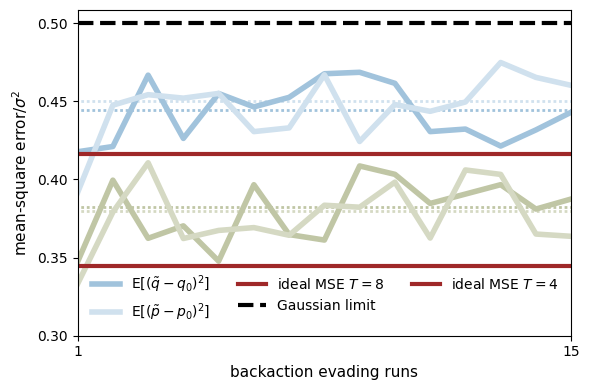

In [ ]:
Delta = 0.3
k = 0
T_range = [4,8]
T_dict = {4:8, 6:6, 8:4, 10:2}
M_range = [4]
stddev_range = np.arange(0.05,l/4+.1,.01)
sigma = 0.15*l
sigma = stddev_range[np.argmin(np.abs(stddev_range-sigma))]
index_sigma = np.argmin(np.abs(stddev_range-sigma))
runs = 4000
repeat_baem = 15
steps = 51

fig, ax = plt.subplots(1,1,figsize=(6,4))
x_range = np.arange(1,repeat_baem+1,1)

colors = [blue, green, red]
mean_MSE_q_Trange = []
mean_MSE_p_Trange = []
mean_means_MSE_q_Trange = []
mean_means_MSE_p_Trange = []
ideal_MSE_Trange = []
for i in range(len(T_range)):
    T = T_range[i]
    M = T_dict[T]
    print('T:', T, 'M:', M)
    # for M in M_range:

    name = 'backaction_evading_bayesian_Delta={0:.2f}_T={1:.0f}_M={2:.0f}_sigma={3:.2f}_runs={4:.0f}_repeats={5:.0f}'.format(Delta,T,M,sigma/l,runs,repeat_baem)
    result = np.load(path_sBs_MP_BA+name+'.npy',allow_pickle=True)

    name = 'backaction_evading_simple_bayesian_Delta={0:.2f}_T={1:.0f}_M={2:.0f}_sigma={3:.2f}_runs={4:.0f}_repeats={5:.0f}'.format(Delta,T,M,sigma/l,runs,repeat_baem)
    result_simple = np.load(path_sBs_MP_BA+name+'.npy',allow_pickle=True)

    name = 'gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
    with open(path_sBs_bayesian+name+'.pkl', 'rb') as f:
        dictionary = pickle.load(f)
    MSE = dictionary['MSEs']
    MSE_q = dictionary['mse_qrange']

    min_MSE = MSE[index_sigma]/stddev_range[index_sigma]**2 # not the min, just the value at the corresponding sigma
    ideal_MSE_Trange.append(min_MSE)

    squared_errors_q = result[:,0,:]
    squared_errors_p = result[:,1,:]
    squared_errors_q_simple = result_simple[:,0,:]
    squared_errors_p_simple = result_simple[:,1,:]
    mean_MSE_q = np.mean(squared_errors_q,axis=0)
    mean_MSE_p = np.mean(squared_errors_p,axis=0)
    mean_MSE_q_simple = np.mean(squared_errors_q_simple,axis=0)
    mean_MSE_p_simple = np.mean(squared_errors_p_simple,axis=0)
    mean_MSE_q_Trange.append(mean_MSE_q_simple)
    mean_MSE_p_Trange.append(mean_MSE_p_simple)

    mean_means_MSE_q = np.mean(mean_MSE_q[1:])/sigma**2
    mean_means_MSE_p = np.mean(mean_MSE_p[1:])/sigma**2
    stddev_means_MSE_q = np.std(mean_MSE_q[1:])/sigma**2
    stddev_means_MSE_p = np.std(mean_MSE_p[1:])/sigma**2
    mean_means_MSE_q_simple = np.mean(mean_MSE_q_simple[1:])/sigma**2
    mean_means_MSE_p_simple = np.mean(mean_MSE_p_simple[1:])/sigma**2
    stddev_means_MSE_q_simple = np.std(mean_MSE_q_simple[1:])/sigma**2
    stddev_means_MSE_p_simple = np.std(mean_MSE_p_simple[1:])/sigma**2
    mean_means_MSE_q_Trange.append(mean_means_MSE_q_simple)
    mean_means_MSE_p_Trange.append(mean_means_MSE_p_simple)

    print('T:', T, 'M:', M, mean_means_MSE_q,mean_means_MSE_p)
    print('T:', T, 'M:', M, mean_means_MSE_q_simple,mean_means_MSE_p_simple)
    print('T:', T, min_MSE)

    shine = .4+.2*i
    ax.plot(x_range,mean_means_MSE_q_simple*np.ones(len(x_range)),color=lighten_color(colors[i],shine),lw=2,label=None,ls=(1,(1,1)))
    ax.plot(x_range,mean_means_MSE_p_simple*np.ones(len(x_range)),color=lighten_color(colors[i],shine-.2),lw=2,label=None,ls=(1,(1,1)))
    
    
    if i ==0:
        ax.plot(x_range,mean_MSE_q_simple/sigma**2,color=lighten_color(colors[i],shine),lw=4,label=r'E$[(\tilde q-q_0)^2]$')
        ax.plot(x_range,mean_MSE_p_simple/sigma**2,color=lighten_color(colors[i],shine-.2),lw=4,label=r'E$[(\tilde p-p_0)^2]$')
        ax.plot(x_range,min_MSE*np.ones(len(x_range)),color=lighten_color(red,1),lw=3,label=r'ideal MSE $T=8$')
        ax.plot([1,31],[.5,.5],color='black',ls='--',lw=3,label=r'Gaussian limit')
    else:
        ax.plot(x_range,mean_MSE_q_simple/sigma**2,color=lighten_color(colors[i],shine),lw=4,label=None)
        ax.plot(x_range,mean_MSE_p_simple/sigma**2,color=lighten_color(colors[i],shine-.2),lw=4,label=None)
        ax.plot(x_range,min_MSE*np.ones(len(x_range)),color=lighten_color(red,1),lw=3,label=r'ideal MSE $T=4$')

    # # Add shadow for the red line
    # ax.fill_between(x_range, (mean_means_MSE_q - stddev_means_MSE_q) * np.ones(len(x_range)),
    #                 (mean_means_MSE_q + stddev_means_MSE_q) * np.ones(len(x_range)),
    #                 color=lighten_color(dark_blue, shine-.1), alpha=.1)

    # # Add shadow for the blue line
    # ax.fill_between(x_range, (mean_means_MSE_p - stddev_means_MSE_p) * np.ones(len(x_range)),
    #                 (mean_means_MSE_p + stddev_means_MSE_p) * np.ones(len(x_range)),
    #                 color=lighten_color(light_blue, shine-.1), alpha=0.25)

ax.set_xticks([1,15])
ax.set_yticks([.3,.35,.4,.45,.5])
ax.set_xlabel(r'backaction evading runs',fontsize=11)
ax.set_ylabel(r'mean-square error$/\sigma^2$',fontsize=11)

dict_figure = {}
dict_figure['mean_MSE_q_Trange'] = mean_MSE_q_Trange
dict_figure['mean_MSE_p_Trange'] = mean_MSE_p_Trange
dict_figure['mean_means_MSE_q_Trange'] = mean_means_MSE_q_Trange
dict_figure['mean_means_MSE_p_Trange'] = mean_means_MSE_p_Trange
dict_figure['T_range'] = T_range
dict_figure['T_dict'] = T_dict
dict_figure['ideal_MSE_Trange'] = ideal_MSE_Trange
name = 'data-figure5-BA-performance'
np.savez(path_figures_data+name+'.npz', **dict_figure)

# ax.set_ylim(0.27,.52)
ax.set_xlim(1,15)
ax.legend(loc='lower right',fontsize=10,ncol=3,framealpha=0)
plt.tight_layout()
name = 'backaction_evading_MSE'
fig.savefig(path_figures+name+'.pdf',bbox_inches='tight',dpi=1000)

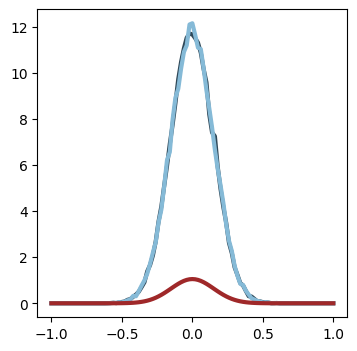

In [ ]:
q0s = result[:,4,:]
p0s = result[:,5,:]

q_range = np.linspace(-l,l,101)
p_range = np.linspace(-l,l,101)

step = (q_range[1]-q_range[0])/2

counts_q0 = []
counts_p0 = []
for q0 in q_range:
    counts_q0.append(np.count_nonzero(np.abs(q0s-q0)<step))
    counts_p0.append(np.count_nonzero(np.abs(p0s-q0)<step))

counts_q0 = np.array(counts_q0)
counts_p0 = np.array(counts_p0)

fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(q_range/l,counts_q0/runs*15,color=dark_blue,lw=3,label=r'$q_0$')
ax.plot(p_range/l,counts_p0/runs*15,color=light_blue,lw=3,label=r'$p_0$')
ax.plot(q_range/l,np.exp(-q_range**2/2/sigma**2)/np.sqrt(2*np.pi*sigma**2),color=red,lw=3,label=r'Gaussian')

### plotting the average with N=4 for different T, M

## plotting

squeezing parameter r: 1.3554941143492478 gain: 4.2776515757629845 dB: 11.773672282284275


(0.0, 0.25)

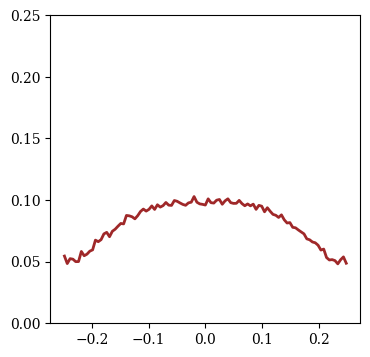

In [ ]:
Delta, R0 = .3, 120
R1, k, steps, l = 15, 4, 101, np.sqrt(2*np.pi)
cd = np.cosh(Delta**2)
gauges = [0,0]
q0_range = (l/4/cd)*np.linspace(-1.0,1.0,steps)
T = 14
runs = 2000
repeat_baem = 10
name = 'backaction_evading_sBs_Delta={0:.2f}_Rmet=Rstab={1:.0f}_p0=lover{2:.0f}_q0range(-lover4,lover4,steps={3:.0f})_runs={4:.0f}_repeats={5:.0f}'.format(Delta,T,k,steps,runs,repeat_baem)
results_q0 = np.load(path_sBs_MP_BA+name+'.npy')

seq_values = results_q0[:, :, 0, 0]
sep_values = results_q0[:, :, 1, 0]
mean_seq_values = np.mean(seq_values, axis=1)
std_seq_values = np.std(np.sqrt(seq_values)/l, axis=1)
mean_sep_values = np.mean(sep_values, axis=1)
std_sep_values = np.std(sep_values, axis=1)

r = np.log(1/np.sqrt(np.max(mean_seq_values)))
dB = 10*np.log10(np.exp(2*r))
gain = np.cosh(r)**2
print('squeezing parameter r:',r, 'gain:',gain, 'dB:',dB)

fig, ax = plt.subplots(1,1,figsize=(4,4))

# ax.errorbar(q0_range/l, np.sqrt(mean_seq_values)/l, yerr=std_seq_values, color=blue, lw=2, label='sequential')
ax.plot(q0_range/l, np.sqrt(mean_seq_values)/l, color=red, lw=2, label='separable')
ax.set_ylim(0,.25)

# Testing the average map estimator

(101, 256)
squeezing parameter r: 0.47140014002403524 gain: 1.2391739069730867 dB: 4.0945295916171744
(101, 256)
squeezing parameter r: 0.8164213735346956 gain: 1.8284444431409372 dB: 7.091345948679837
(101, 256)
squeezing parameter r: 1.1708143297247346 gain: 3.123582179628141 dB: 10.169564054654135


(-0.25, 0.25)

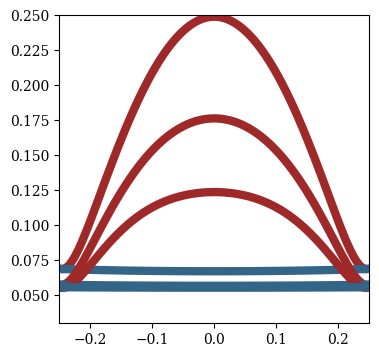

In [ ]:
def MSE_q_p_estimating_with_averagemap(probs_qp0_allbits,estimators_allqbits_p0,estimators_allpbits_q0,R,T,q0_range):
    mean_squared_errors_q, mean_squared_errors_p = [],[]
    for index_q0 in range(steps):
        q0 = q0_range[index_q0]
        probs_q0p0_allbits = probs_qp0_allbits[index_q0]
        probs_allbits_q0p0 = np.transpose(probs_q0p0_allbits)
        probs_Tbits_q0p0 = get_probabilities_bitsT(probs_allbits_q0p0,R,T)
        mean_sqeq, mean_sqep = 0, 0
        for b in range(2**(2*T)):
            bit = int_to_r_bits(b,2*T)
            bq, bp = bit[::2], bit[1::2]
            bq = binary_array_to_int(bq)
            bp = binary_array_to_int(bp)
            est_q = estimators_allqbits_p0[bq]
            est_p = estimators_allpbits_q0[bp]
            seq, sep = (est_q-q0)**2, (est_p-p0)**2
            mean_sqeq += probs_Tbits_q0p0[b]*seq
            mean_sqep += probs_Tbits_q0p0[b]*sep
        mean_squared_errors_q.append(mean_sqeq)
        mean_squared_errors_p.append(mean_sqep)
    mean_squared_errors_q = np.array(mean_squared_errors_q)
    mean_squared_errors_p = np.array(mean_squared_errors_p)
    return mean_squared_errors_q, mean_squared_errors_p


Delta, R0 = .3, 120
R, k, steps, l = 4, 4, 101, np.sqrt(2*np.pi)
cd = np.cosh(Delta**2)
gauges = [0,0]
q0_range = (l/4/cd)*np.linspace(-1.0,1.0,steps)
T_range = [1,2,4]
name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,R0)
sensor = sps.load_npz(path_data_sBs_sensor+name)
Tq, Tp = stabilizers(Delta)

if k==0:
    p0 = 0
else:
    p0 = l/k
runs = 1
repeat_baem = 1
R_stabilizing = 0
fig, ax = plt.subplots(1,1,figsize=(4,4))
for T in T_range:
    R_metrology = T
    name = 'estimators_ML_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range=(-lover4,lover4)'.format(Delta,T,k)
    estimators_allqbits_p0 = np.load(path_sBs_MP_ML+name+'.npy')
    name = 'estimators_ML_Delta={0:.2f}_T={1:.0f}_q0=lover{2:.0f}_p0range=(-lover4,lover4)'.format(Delta,T,k)
    estimators_allpbits_q0 = np.load(path_sBs_MP_ML+name+'.npy')
    
    name = 'probs_allbits_p0=lover{0:.0f}_qrange(-lover4,lover4)_steps={1:.0f}_Delta={2:.2f}_T={3:.0f}'.format(k,steps,Delta,R)#D\equiv /, division
    probs_qp0_allbits = np.load(path_data_sBs_probabilities+name+'.npy')
    print(probs_qp0_allbits.shape)


    mean_squared_errors_q, mean_squared_errors_p = MSE_q_p_estimating_with_averagemap(probs_qp0_allbits,estimators_allqbits_p0,estimators_allpbits_q0,R,T,q0_range)

    ax.plot(q0_range/l,np.sqrt(mean_squared_errors_q)/l,color=red,label='sequential',lw=6)
    ax.plot(q0_range/l,np.sqrt(mean_squared_errors_p)/l,color=blue,label='separable',lw=6)
    r = np.log(1/np.sqrt(np.max(mean_squared_errors_q)))
    dB = 10*np.log10(np.exp(2*r))
    gain = np.cosh(r)**2
    print('squeezing parameter r:',r, 'gain:',gain, 'dB:',dB)

ax.set_ylim(0.03,.25)
ax.set_xlim(-.25,.25)

# Gaussian prior

## Saving the data full map

In [ ]:
Delta = 0.3
k, steps, R = 0,101,4
cd = np.cosh(Delta**2)
q0_range = (l)*np.linspace(-1.0,1.0,steps)
name = 'probs_allbits_p0=lover{0:.0f}_qrange(-l,l)_steps={1:.0f}_Delta={2:.2f}_T={3:.0f}'.format(k,steps,Delta,R)#D\equiv /, division
probs_qp0_allbits = np.load(path_data_sBs_probabilities+name+'.npy',allow_pickle=True)
probs_qp0_allbits = probs_qp0_allbits[:,0,:]
T_range = [1,2,4]
stddev_range = np.arange(0.05,l/4+.1,.01)
for T in T_range:
    MSEs = []
    mse_qrange = []
    posteriors_all = []
    for stddev in tqdm(stddev_range):
        mse_q, MSE, posteriors, probs_b = gaussian_MSE(stddev,probs_qp0_allbits,R,T,q0_range,steps)
        MSEs.append(MSE)
        mse_qrange.append(mse_q)
        posteriors_all.append(posteriors)
    MSEs = np.array(MSEs)
    mse_qrange = np.array(mse_qrange)
    posteriors_all = np.array(posteriors_all)
    dictionary = {'MSEs':MSEs,'mse_qrange':mse_qrange,'posteriors_all':posteriors_all}
    name = 'gaussian_prior_fullmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
    with open(path_sBs_bayesian+name+'.pkl', 'wb') as f:
        pickle.dump(dictionary, f, pickle.HIGHEST_PROTOCOL)

T = 4
stddev = l/4
mse_q, MSE, posteriors, probs_b = gaussian_MSE(stddev,probs_qp0_allbits,R,T,q0_range,steps)
print(MSE/stddev**2)
print('posterior',np.sum(posteriors[2]))
fig, axs = plt.subplots(1,3,figsize=(12,4))
ax1, ax2, ax3 = axs
ax1.plot(q0_range/l,np.sqrt(mse_q)/l,color=red,label='sequential',lw=6)
ax2.plot(q0_range/l,posteriors[0]/l,color=red,label='sequential',lw=6)
ax3.plot(stddev_range/l,MSEs/stddev_range**2,color=red,label='sequential',lw=6)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/labl2714/Projects/GKP-metrology/GKP-metrology/sBs-noiseless//sBs/probabilities/probs_allbits_p0=lover0_qrange(-l,l)_steps=101_Delta=0.30_T=8.npy'

## saving the data qmap

In [ ]:
def saving_gaussian_prior_fullqmap(Delta):
    k, steps, R = 0,51,10
    cd = np.cosh(Delta**2)
    q0_range = (l)*np.linspace(-1.0,1.0,steps)
    name = 'probs_allqbits_p0=lover{0:.0f}_qrange(-l,l)_steps={1:.0f}_Delta={2:.2f}_T={3:.0f}'.format(k,steps,Delta,R)#D\equiv /, division
    probs_qp0_allbits = np.load(path_data_sBs_probabilities+name+'.npy',allow_pickle=True)
    # probs_qp0_allbits = probs_qp0_allbits[:,0,:]
    T_range = np.arange(1,11,1)
    stddev_range = np.arange(0.05,l/4+.1,.01)
    for T in tqdm(T_range):
        MSEs = []
        mse_qrange = []
        posteriors_all = []
        estimators_all = []
        for stddev in stddev_range:
            mse_q, MSE, posteriors, estimators, probs_b = gaussian_MSE_qmap(stddev,probs_qp0_allbits,R,T,q0_range,steps)
            MSEs.append(MSE)
            mse_qrange.append(mse_q)
            posteriors_all.append(posteriors)
            estimators_all.append(estimators)
        MSEs = np.array(MSEs)
        mse_qrange = np.array(mse_qrange)
        posteriors_all = np.array(posteriors_all)
        estimators_all = np.array(estimators_all)
        dictionary = {'MSEs':MSEs,'mse_qrange':mse_qrange,'posteriors_all':posteriors_all,'estimators_all':estimators_all}
        name = 'gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
        with open(path_sBs_bayesian+name+'.pkl', 'wb') as f:
            pickle.dump(dictionary, f, pickle.HIGHEST_PROTOCOL)
    return None

Delta_range = np.arange(.25,.41,.01)
Parallel(n_jobs=-1)(delayed(saving_gaussian_prior_fullqmap)(Delta) for Delta in Delta_range)

# stddev = l/4
# mse_q, MSE, posteriors, probs_b = gaussian_MSE(stddev,probs_qp0_allbits,R,T,q0_range,steps)
# print(MSE/stddev**2)
# print('posterior',np.sum(posteriors[2]))
# fig, axs = plt.subplots(1,3,figsize=(12,4))
# ax1, ax2, ax3 = axs
# ax1.plot(q0_range/l,np.sqrt(mse_q)/l,color=red,label='sequential',lw=6)
# ax2.plot(q0_range/l,posteriors[0]/l,color=red,label='sequential',lw=6)
# ax3.plot(stddev_range/l,MSEs/stddev_range**2,color=red,label='sequential',lw=6)

 90%|█████████ | 9/10 [46:42<11:15, 675.75s/it]

In [ ]:
def saving_gaussian_prior_fullpmap(Delta):
    k, steps, R = 0,51,10
    cd = np.cosh(Delta**2)
    q0_range = (l)*np.linspace(-1.0,1.0,steps)
    name = 'probs_allpbits_q0=lover{0:.0f}_prange(-l,l)_steps={1:.0f}_Delta={2:.2f}_T={3:.0f}'.format(k,steps,Delta,R)#D\equiv /, division
    probs_qp0_allbits = np.load(path_data_sBs_probabilities+name+'.npy',allow_pickle=True)
    # probs_qp0_allbits = probs_qp0_allbits[:,0,:]
    T_range = np.arange(1,11,1)
    stddev_range = np.arange(0.05,l/4+.1,.01)
    for T in tqdm(T_range):
        MSEs = []
        mse_qrange = []
        posteriors_all = []
        estimators_all = []
        for stddev in stddev_range:
            mse_q, MSE, posteriors, estimators, probs_b = gaussian_MSE_qmap(stddev,probs_qp0_allbits,R,T,q0_range,steps)
            MSEs.append(MSE)
            mse_qrange.append(mse_q)
            posteriors_all.append(posteriors)
            estimators_all.append(estimators)
        MSEs = np.array(MSEs)
        mse_qrange = np.array(mse_qrange)
        posteriors_all = np.array(posteriors_all)
        estimators_all = np.array(estimators_all)
        dictionary = {'MSEs':MSEs,'mse_qrange':mse_qrange,'posteriors_all':posteriors_all,'estimators_all':estimators_all}
        name = 'gaussian_prior_fullpmap_Delta={0:.2f}_T={1:.0f}_q0=lover{2:.0f}_p0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
        print(name)
        with open(path_sBs_bayesian+name+'.pkl', 'wb') as f:
            pickle.dump(dictionary, f, pickle.HIGHEST_PROTOCOL)

Delta_range = [.25,.3,.35,.4]
Parallel(n_jobs=-1)(delayed(saving_gaussian_prior_fullpmap)(Delta) for Delta in Delta_range)

# T = 4
# stddev = l/4
# mse_q, MSE, posteriors, probs_b = gaussian_MSE(stddev,probs_qp0_allbits,R,T,q0_range,steps)
# print(MSE/stddev**2)
# print('posterior',np.sum(posteriors[2]))
# fig, axs = plt.subplots(1,3,figsize=(12,4))
# ax1, ax2, ax3 = axs
# ax1.plot(q0_range/l,np.sqrt(mse_q)/l,color=red,label='sequential',lw=6)
# ax2.plot(q0_range/l,posteriors[0]/l,color=red,label='sequential',lw=6)
# ax3.plot(stddev_range/l,MSEs/stddev_range**2,color=red,label='sequential',lw=6)

  0%|          | 0/10 [00:00<?, ?it/s]

gaussian_prior_fullpmap_Delta=0.35_T=1_q0=lover0_p0range(-l,l)_steps=51
gaussian_prior_fullpmap_Delta=0.40_T=1_q0=lover0_p0range(-l,l)_steps=51
gaussian_prior_fullpmap_Delta=0.25_T=1_q0=lover0_p0range(-l,l)_steps=51


 10%|█         | 1/10 [00:07<01:03,  7.04s/it]

gaussian_prior_fullpmap_Delta=0.30_T=1_q0=lover0_p0range(-l,l)_steps=51


 10%|█         | 1/10 [00:07<01:04,  7.12s/it]

gaussian_prior_fullpmap_Delta=0.40_T=2_q0=lover0_p0range(-l,l)_steps=51
gaussian_prior_fullpmap_Delta=0.35_T=2_q0=lover0_p0range(-l,l)_steps=51


 20%|██        | 2/10 [00:20<01:26, 10.86s/it]

gaussian_prior_fullpmap_Delta=0.25_T=2_q0=lover0_p0range(-l,l)_steps=51
gaussian_prior_fullpmap_Delta=0.30_T=2_q0=lover0_p0range(-l,l)_steps=51


 20%|██        | 2/10 [00:21<01:30, 11.28s/it]

gaussian_prior_fullpmap_Delta=0.35_T=3_q0=lover0_p0range(-l,l)_steps=51
gaussian_prior_fullpmap_Delta=0.40_T=3_q0=lover0_p0range(-l,l)_steps=51


 30%|███       | 3/10 [00:47<02:06, 18.10s/it]

gaussian_prior_fullpmap_Delta=0.25_T=3_q0=lover0_p0range(-l,l)_steps=51


 30%|███       | 3/10 [00:48<02:08, 18.41s/it]

gaussian_prior_fullpmap_Delta=0.30_T=3_q0=lover0_p0range(-l,l)_steps=51


 30%|███       | 3/10 [00:48<02:10, 18.63s/it]

## numerically limit $\Delta\to 0$

In [41]:
def pg_q0(q0):
    return (1/2) * (1 + np.sin(l * q0))

def prob_ideal_bit(bit,q0):
    prob = 1
    for b in bit:
        if b == '0':
            prob *= pg_q0(q0)
        else:
            prob *= (1-pg_q0(q0))
    return prob

q0_range = np.linspace(-l,l,101)
probs_ideal_bit = []
r = 4
for i in range(2**r):
    bit = int_to_r_bits(i,r)
    probs = prob_ideal_bit(bit,q0_range)
    probs_ideal_bit.append(probs)
probs_ideal_bit = np.array(probs_ideal_bit)

print(np.sum(probs_ideal_bit,axis=0))


def MSE_onlyqorp(p_array: list, vlist: list, variance: float = 1, r: int = 1):

    def p_gaussian_prior(v: list, variance: float = 1):
        p_v = (1.0 / (np.sqrt(2 * np.pi) * variance)) * np.exp(
            -(1 / (2 * variance)) * v ** 2
        )
        return p_v / sum(p_v)

    p_array = np.transpose(p_array)
    estimator_arr = np.empty((2 ** (r)))
    posterior_arr = np.empty((2 ** (r), len(vlist)))

    for idx in range(2 ** (r)):
        p_y = sum(p_array[:, idx] * p_gaussian_prior(vlist, variance))  #gaussian prior
        posterior = p_array[:, idx] * p_gaussian_prior(vlist, variance) / p_y #gaussian posterior
        posterior_arr[idx, :] = posterior
        estimator_arr[idx] = sum(vlist * posterior)

    MSD_v_ = np.sum(
        p_array
        * (
            np.ones((len(vlist), 2 ** (r))) * estimator_arr
            - (vlist * np.ones((2 ** (r), len(vlist)))).T
        )
        ** 2,
        axis=1,
    )
    MSD = np.sum(p_gaussian_prior(vlist, variance) * np.array(MSD_v_))
    return MSD
    
stddev_range = np.arange(0.05,l/4+.1,.01)
variance = (0.15*l)**2
MSE_ideal = MSE_onlyqorp(probs_ideal_bit, q0_range, variance, r)
print(MSE_ideal/variance)

def analytical_1(v):
    return v*(1-l**2*v*np.exp(-l**2*v))
def analytical_2(v):
    a = l**2*v
    return v*(1-2*a/(np.cosh(a)+2*np.sinh(a)))

print(analytical_1(variance)/variance)
print(analytical_2(variance)/variance)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]
0.3468710668256406
0.6345954682858064
0.4836686452910889


## paper plot

0.5 0.5
min ratio 0.34305776028088303
max 2.2355850997779227 19.41804545317365 variance 0.0025000000000000005
index min 32 T 8
min 1.771956841931875 15.391021572434518
stddev1 0.2114394086127594 stddev2 0.08776730168831522
squeezing parameter r: 1.3191009079034557 gain: 4.014879408563544 dB: 11.457564907520808
min ratio 0.41585374115828005
max 2.206483736859944 19.16527422655081 variance 0.0025000000000000005
index min 32 T 4
min 1.771956841931875 15.391021572434518
min ratio 0.5301928739610037
max 2.1708041439692174 18.855365220370867 variance 0.0025000000000000005
index min 33 T 2
min 1.771956841931875 15.391021572434518
min ratio 0.6583165331336828
max 2.1416651121482135 18.602266805813564 variance 0.0025000000000000005
index min 35 T 1
min 1.771956841931875 15.391021572434518


/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_63150/1951155443.py:158: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend(handles, labels,loc='upper right',fontsize=9,frameon=True,ncol=2)


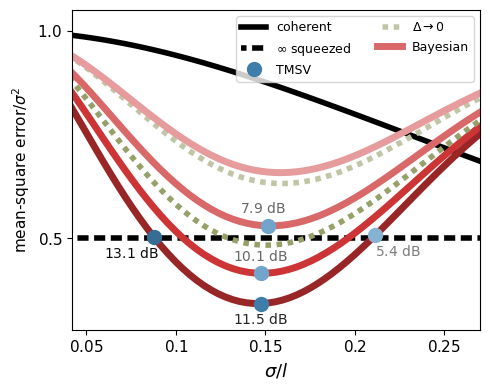

In [7]:
def coherent_limit(v):
    return 1/(v+1)
def gaussian_limit(v):
    return v/2/v

def two_mode_squeezing_limit(v,r):
    return np.exp(-2*r)*v/(np.exp(-2*r)+v)
from scipy.optimize import fsolve
def solve_for_r(v, MSE):
    # Define the equation to solve
    def equation(r):
        return two_mode_squeezing_limit(v, r) - MSE
    # Use fsolve to find the root of the equation
    r_initial_guess = 0.5 # Initial guess for r
    r_solution = fsolve(equation, r_initial_guess)
    return r_solution[0]

def solve_for_r_coherent(v,MSE):
    # Define the equation to solve
    def equation(r):
        return coherent_limit(v, r) - MSE
    # Use fsolve to find the root of the equation
    r_initial_guess = 0.5 # Initial guess for r
    r_solution = fsolve(equation, r_initial_guess)
    return r_solution[0]

def minimum_r(stddev_range,MSE_array):
    r_array = np.zeros(len(MSE_array))
    for i in range(len(MSE_array)):
        MSE = MSE_array[i]
        v = stddev_range[i]
        r = solve_for_r(v, MSE)
        r_array[i] = r
    return r_array

def analytical_1(v):
    return v*(1-l**2*v*np.exp(-l**2*v))
def analytical_2(v):
    a = l**2*v
    return v*(1-2*a/(np.cosh(a)+2*np.sinh(a)))

Delta, k, steps, R = 0.3,0,51,4
cd = np.cosh(Delta**2)
q0_range = (l)*np.linspace(-1.0,1.0,steps)
stddev_range = np.arange(0.05,l/4+.1,.01)

print(coherent_limit(1),gaussian_limit(1))

fig, ax = plt.subplots(1,1,figsize=(5,4))

line1, = ax.plot(stddev_range, coherent_limit(stddev_range**2),color='black',ls='-',lw=4,label='coherent')
line2, = ax.plot(stddev_range, gaussian_limit(stddev_range**2),color='black',ls=(1,(2,1)),lw=4,label=r'$\infty$ squeezed')
path_sBs_bayesian = path_sBs+"data/bayesian/" 
lines = [line1,line2]

T_range = [8,4,2,1]
for i in range(4):
    T = T_range[i]
    name = 'gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
    name2 = 'gaussian_prior_fullpmap_Delta={0:.2f}_T={1:.0f}_q0=lover{2:.0f}_p0range(-l,l)_steps={3:.0f}'.format(Delta,T,4,steps)
    with open(path_sBs_bayesian+name+'.pkl', 'rb') as f:
        dictionary = pickle.load(f)
    MSE = dictionary['MSEs']
    MSE_q = dictionary['mse_qrange']

    with open(path_sBs_bayesian+name2+'.pkl', 'rb') as f:
        dictionary2 = pickle.load(f)
    MSE2 = dictionary2['MSEs']
    MSE_p = dictionary2['mse_qrange']

    shine = .4+.3*np.log(T)
    if i==2:
        line3, = ax.plot(stddev_range,MSE/stddev_range**2,color=lighten_color(red,shine),lw=5,label='Bayesian')
        # ax.plot(stddev_range,MSE2/stddev_range**2,color=lighten_color(blue,shine),lw=5,ls='--')
    else:
        line3, = ax.plot(stddev_range,MSE/stddev_range**2,color=lighten_color(red,shine),lw=5)
        # ax.plot(stddev_range,MSE2/stddev_range**2,color=lighten_color(blue,shine),lw=5,ls='--')

    print('min ratio',np.min(MSE/stddev_range**2))

    variance_list = stddev_range**2
    r_array = minimum_r(variance_list,MSE)
    r_max, argmax = np.max(r_array), np.argmax(r_array)
    print('max',r_max, 10*np.log10(np.exp(2*r_max)), 'variance',variance_list[argmax])

    ind = np.argmin(np.abs(MSE)/variance_list)
    index_gaussian = np.argmin(np.abs(MSE[ind:]/variance_list[ind:] - 0.5))
    print('index min',ind,'T',T)

    ind_min = 12
    r_min = solve_for_r(variance_list[ind_min], variance_list[ind_min]/2)
    db_min = 10*np.log10(np.exp(2*r_min))
    print('min',r_min, db_min)
    
    if i==0:
        index_gaussian = np.argmin(np.abs(MSE[ind:]/variance_list[ind:] - 0.5))
        index_gaussian2 = np.argmin(np.abs(MSE[:ind]/variance_list[:ind] - 0.5))
        print('stddev1',stddev_range[ind+index_gaussian]/l,'stddev2',stddev_range[index_gaussian2]/l) 
    else:
        pass

    if i==0:
        r = solve_for_r(variance_list[ind], MSE[ind])
        dB = 10*np.log10(np.exp(2*r))
        gain = np.cosh(r)**2
        rg1 = solve_for_r(variance_list[ind+index_gaussian], MSE[ind+index_gaussian])
        dbg1 = 10*np.log10(np.exp(2*rg1))
        rg2 = solve_for_r(variance_list[index_gaussian2], MSE[index_gaussian2])
        dbg2 = 10*np.log10(np.exp(2*rg2))
        rmin = solve_for_r(variance_list[ind_min], MSE[ind_min])
        dBmin = 10*np.log10(np.exp(2*rmin))
        print('squeezing parameter r:',r, 'gain:',gain, 'dB:',dB)
        ax.text(np.sqrt(variance_list[ind])-.04,MSE[ind]/variance_list[ind]-.05,r'${0:.1f}$ dB'.format(dB),fontsize=10,color=lighten_color('black',.2+r/2))
        line4, = ax.plot(np.sqrt(variance_list[ind]),MSE[ind]/variance_list[ind],'o',color=lighten_color(blue,.2+r/2),markersize=10,label='TMSV')
        lines.append(line4)
        ax.text(np.sqrt(variance_list[ind+index_gaussian])+.0,MSE[ind+index_gaussian]/variance_list[ind+index_gaussian]-.05,r'${0:.1f}$ dB'.format(dbg1),fontsize=10,color=lighten_color('black',.2+rg1/2))
        ax.plot(np.sqrt(variance_list[ind+index_gaussian]),MSE[ind+index_gaussian]/variance_list[ind+index_gaussian],'o',color=lighten_color(blue,.2+rg1/2),markersize=10,label=None)
        ax.text(np.sqrt(variance_list[index_gaussian2])-.07,MSE[index_gaussian2]/variance_list[index_gaussian2]-.05,r'${0:.1f}$ dB'.format(dbg2),fontsize=10,color=lighten_color('black',.2+rg2/2))
        ax.plot(np.sqrt(variance_list[index_gaussian2]),MSE[index_gaussian2]/variance_list[index_gaussian2],'o',color=lighten_color(blue,.2+rg2/2),markersize=10,label=None)
        # ax.text(np.sqrt(variance_list[ind_min])-.06,MSE[ind_min]/variance_list[ind_min]-.04,r'${0:.1f}$ dB'.format(dBmin),fontsize=13,color=lighten_color('black',1))
        # ax.plot(np.sqrt(variance_list[ind_min]),MSE[ind_min]/variance_list[ind_min],'o',color=lighten_color('black',1),markersize=10,label=None)
    elif i==1 or i==2:
        r = solve_for_r(variance_list[ind], MSE[ind])
        dB = 10*np.log10(np.exp(2*r))
        gain = np.cosh(r)**2
        rg2 = solve_for_r(variance_list[index_gaussian2], MSE[index_gaussian2])
        dbg2 = 10*np.log10(np.exp(2*rg2))
        rmin = solve_for_r(variance_list[ind_min], MSE[ind_min])
        dBmin = 10*np.log10(np.exp(2*rmin))
        ax.text(np.sqrt(variance_list[ind])-.04,MSE[ind]/variance_list[ind]+.03,r'${0:.1f}$ dB'.format(dB),fontsize=10,color=lighten_color('black',1-.4))
        ax.plot(np.sqrt(variance_list[ind]),MSE[ind]/variance_list[ind],'o',color=lighten_color(blue,1-.4),markersize=10)
        # ax.text(np.sqrt(variance_list[index_gaussian2])+0.01,MSE[index_gaussian2]/variance_list[index_gaussian2]-.01,r'${0:.1f}$ dB'.format(dbg2),fontsize=13,color=lighten_color('black',1-.2))
        # ax.plot(np.sqrt(variance_list[index_gaussian2]),MSE[index_gaussian2]/variance_list[index_gaussian2],'o',color=lighten_color('black',1-.2),markersize=10,label=None)
        # ax.text(np.sqrt(variance_list[ind_min])-.0,MSE[ind_min]/variance_list[ind_min]+.015,r'${0:.1f}$ dB'.format(dBmin),fontsize=13,color=lighten_color('black',1))
        # ax.plot(np.sqrt(variance_list[ind_min]),MSE[ind_min]/variance_list[ind_min],'o',color=lighten_color('black',1),markersize=10,label=None)
    if i==2:
        line5, = ax.plot(stddev_range,analytical_1(variance_list)/variance_list,color=lighten_color(green,.6),ls=(1,(1,1)),lw=4,label=r'$\Delta\to 0$')
        lines.append(line5)
    elif i==1:
        ax.plot(stddev_range,analytical_2(variance_list)/variance_list,color=lighten_color(green,1),ls=(1,(1,1)),lw=4)
    lines.append(line3)


handles = lines
labels = [h.get_label() for h in handles]

l = np.sqrt(2*np.pi)
ax.set_xlim(0.042*l,0.27*l)
ax.set_ylim(.28,1.05)
ax.set_xlabel(r'$\sigma/l$',fontsize=13)
ax.set_xticks([0.05*l,0.1*l,0.15*l,0.2*l,0.25*l])
ax.set_yticks([0.5,1])
xlabels = [r'$0.05$',r'$0.1$',r'$0.15$',r'$0.2$',r'$0.25$']
ylabels = [r'$0.5$',r'$1.0$']
ax.set_xticklabels(xlabels,fontsize=11)
ax.set_yticklabels(ylabels,fontsize=11)
ax.set_ylabel(r'$\text{mean-square error}/\sigma^2$',fontsize=11)
ax.legend(handles, labels,loc='upper right',fontsize=9,frameon=True,ncol=2)

plt.tight_layout()
# name = 'noiseless-gaussian-delta={0:.2f}'.format(Delta)
# plt.savefig(path_figures+name+'.pdf',format='pdf',bbox_inches='tight',dpi=1000)
# plt.show()

# comparing TMSV with QFI

(0.0, 0.25)

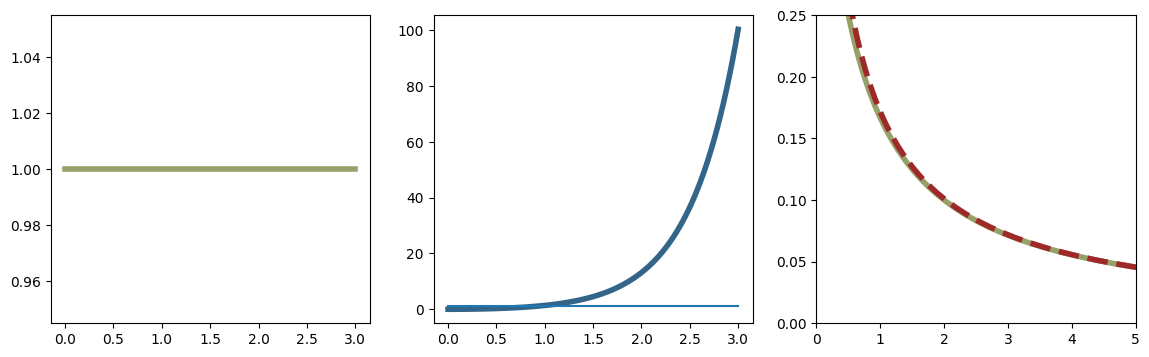

In [7]:
def squeezing_n(n):
    return 1/(n+1/2+np.sqrt(n**2+n))/2

r_range = np.linspace(0.0,3.0,100)
squeezing_values = np.exp(-2*r_range)
photons_values = np.sinh(r_range)**2
fig, axs = plt.subplots(1,3,figsize=(14,4))
ax1, ax2, ax3 = axs
ax1.plot(r_range,squeezing_n(photons_values)/squeezing_values,color=green,lw=4,label='coherent')
# ax1.plot(r_range,squeezing_values,color=red,lw=4,label='squeezing',ls='--')
ax2.plot(r_range,photons_values,color=blue,lw=4,label='photons')
ax2.plot([0,3],[1,1])
ax3.plot(photons_values, 1/(4*photons_values+2),color=green,lw=4,label='coherent')
ax3.plot(photons_values,squeezing_values,color=red,lw=4,label='squeezing',ls='--')
ax3.set_xlim(0,5)
ax3.set_ylim(0,.25)

# Simple numerical experiment to test convergence to QFI

In [104]:
def prob_bit_T(T,r,q):
    #r is delta**2
    a = 0.4
    b = 1.24
    A = np.exp(-a*r)
    rate = b*r*(T)
    return (1+A*np.sin(l*q*np.exp(-rate)))/2

def prob_bits_qrange(T,r,qrange):
    probs = []
    for q in qrange:
        probs.append(prob_bit_T(T,r,q))
    return np.array(probs)

def random_bit_from_probs_bits(probs_bits):
    random_bit = []
    for p in probs_bits:
        random_bit.append(np.random.choice([0,1],p=[1-p,p]))
    return random_bit

def probability_of_bit(probs_bits,bit):
    p = 1
    for i in range(len(bit)):
        if bit[i]==1:
            p *= probs_bits[i]
        else:
            p *= 1-probs_bits[i]
    return p

def probabilities_bit_qrange(probs_qrange,bit):
    probs = []
    for index_q0 in range(len(probs_qrange)):
        probs.append(probability_of_bit(probs_qrange[index_q0],bit))
    return np.array(probs)

def FI_T_q_sample(T_range,r,index_q0,probs_qrange,q_range,bit):
    p_qrange = probabilities_bit_qrange(probs_qrange,bit)
    partial_p_qrange = np.gradient(p_qrange, q_range, edge_order=2)
    partial_index = partial_p_qrange[index_q0]
    p_index = p_qrange[index_q0]
    FI_q = partial_index**2 / p_index**2
    return FI_q

def FI_T_q(T_range,r,index_q0,samples,steps,probs_qrange,q_range):
    FI_q = 0
    # bits = []
    for sample in range(samples):
        bit = random_bit_from_probs_bits(probs_qrange[index_q0])
        FI_q+= FI_T_q_sample(T_range,r,index_q0,probs_qrange,q_range,bit)
        # bits.append(bit)
    return FI_q/samples

def FI_T(T_range,r,q_range,samples,steps):
    probs_qrange = prob_bits_qrange(T_range,r,q_range)#shape qrange x T_range
    FI = []
    # bits_all = []
    # for index_q0 in range(steps):
    #     FI_q, bits = FI_T_q(T_range,r,index_q0,samples,steps,probs_qrange,q_range)
    #     FI.append(FI_q)
    #     bits_all.append(bits)
    # return np.array(FI), bits_all
    FI = Parallel(n_jobs=-1)(delayed(FI_T_q)(T_range,r,index_q0,samples,steps,probs_qrange,q_range) for index_q0 in range(steps))  
    return np.array(FI)

l = np.sqrt(2*np.pi)
Delta = 0.35
n = 3.8072048804006844
r = Delta**2
T_range = np.arange(0,10,1)
steps = 100
q_range = np.linspace(-l/4+.001,l/4-.001,steps)
samples = 10000
R_range = np.arange(1,12,1)
FI = []
for R in tqdm(R_range):
    T_range = np.arange(0,R,1)
    FI.append(FI_T(T_range,r,q_range,samples,steps))

T_range = np.arange(0,40,1)
FI.append(FI_T(T_range,r,q_range,samples,steps))
FI = np.array(FI)

100%|██████████| 11/11 [01:35<00:00,  8.65s/it]


prob of 1 0.0017 prob of 1 correct 0.023910930832585386
sensor n 3.8072048804006844


(-0.25, 0.25)

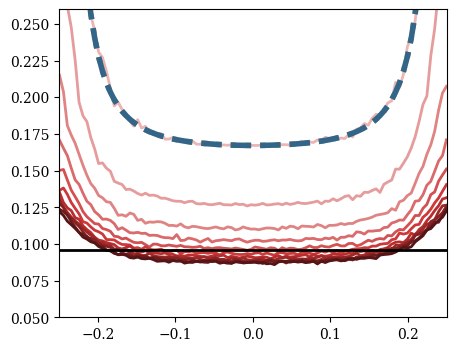

In [102]:
def FI_analytical(q,r):
    '''
    FI of one bit. 
    '''
    a = 0.4
    A = np.exp(-a*r)
    numerator = A**2*l**2*np.cos(l*q)**2
    denominator = 1-A**2*np.sin(l*q)**2
    return numerator/denominator

def exact_FI(q_range,r):
    T_range = np.arange(0,1,1)
    bit0 = np.array([0])
    bit1 = np.array([1])
    probs_qrange = prob_bits_qrange(T_range,r,q_range)
    probs_qrange_0 = probabilities_bit_qrange(probs_qrange,bit0)
    probs_qrange_1 = probabilities_bit_qrange(probs_qrange,bit1)

    partial_p_qrange_0 = np.gradient(probs_qrange_0, q_range, edge_order=2)
    partial_p_qrange_1 = np.gradient(probs_qrange_1, q_range, edge_order=2)

    FI0 = (partial_p_qrange_0)**2/probs_qrange_0
    FI1 = (partial_p_qrange_1)**2/probs_qrange_1
    FI = (partial_p_qrange_0)**2/probs_qrange_0 + (partial_p_qrange_1)**2/probs_qrange_1
    return FI0, FI1

def random_bit_from_probs_bits(probs_bits):
    random_bit = []
    for p in probs_bits:
        random_bit.append(np.random.choice([0,1],p=[1-p,p]))
    return random_bit

probs_qrange = prob_bits_qrange(np.array([0]),r,q_range)
bits = np.array(bits)
bit0 = np.array([0])
bit1 = np.array([1])
probs_qrange_0 = probabilities_bit_qrange(probs_qrange,bit0)
probs_qrange_1 = probabilities_bit_qrange(probs_qrange,bit1)

index_q0 = 0
bits_q = bits[index_q0,:]
number_of_ones = np.sum(bits_q)
number_of_zeros = samples - number_of_ones
probs_ones = number_of_ones/samples
print('prob of 1',probs_ones, 'prob of 1 correct',probs_qrange_1[index_q0])

QFI = np.real(1/(4*n+2))
print('sensor n',np.real(n))


FI_exact_0, FI_exact_1 = exact_FI(q_range,r)

fig, ax = plt.subplots(1,1,figsize=(5,4))

R_range = np.arange(1,12,1)
for R in R_range:
    FI_R = FI[R-1]
    ax.plot(q_range/l,1/np.sqrt(FI_R)/l,color=lighten_color(red,.2+.1*R),lw=2)
ax.plot(q_range/l,1/np.sqrt(FI_analytical(q_range,r))/l,color=green,lw=4,label='coherent',ls='dotted')
ax.plot(q_range/l,1/np.sqrt(FI_exact_0+FI_exact_1)/l,color=blue,lw=4,label='coherent',ls='--')

ax.plot([-1,1],[np.sqrt(QFI)/l,np.sqrt(QFI)/l],color=lighten_color('black',1),lw=2,ls='-',label=r'1/$\sqrt{\text{QFI}}$')

ax.set_ylim(0,.5)
ax.set_ylim(0.05,.26)
ax.set_xlim(-.25,.25)

# figures for MM slides

### cartoon waveform

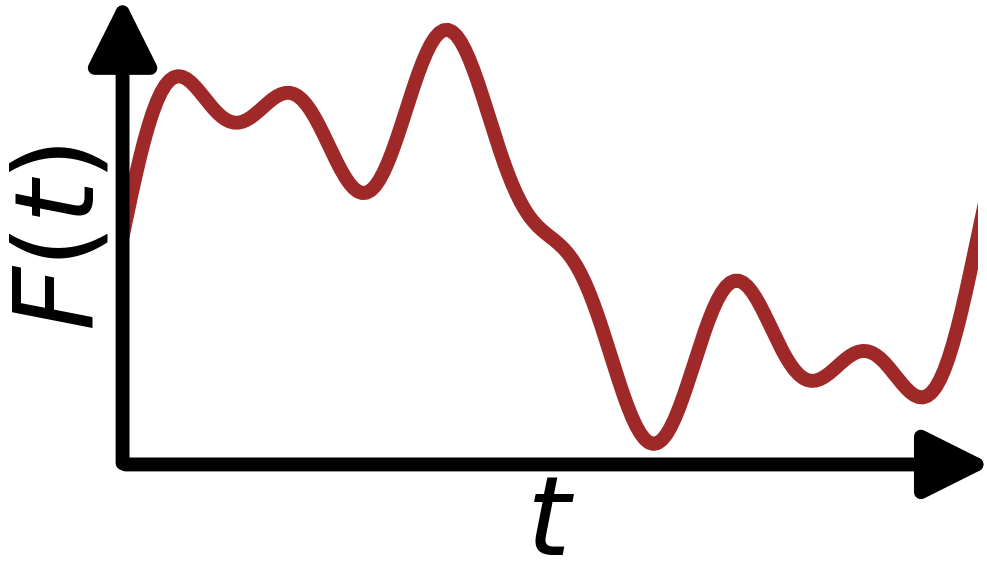

In [8]:
# Generate time data
t = np.linspace(0, 10, 1000)

# Generate force data with overlapping frequencies
f = np.sin(2 * np.pi * 0.5 * t) + 0.5 * np.sin(2 * np.pi * 1.5 * t) + 0.3 * np.sin(2 * np.pi * 3 * t)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
background_color = (255/255, 255/255, 255/255)
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)


# Plot the force as a function of time
ax.plot(t, f, label='Force',lw=10,color=red)

# Add labels and title
ax.set_xlabel(r'$t$', fontsize=80)
ax.set_ylabel(r'$F(t)$', fontsize=80)
# ax.set_title('Force as a Function of Time', fontsize=16)

# Add a legend
# ax.legend(loc='upper right', fontsize=12)

# Customize the plot for a simple and elegant look
# ax.grid(True, which='both', linestyle='--', linewidth=0.5)
# ax.axhline(0, color='black',linewidth=0.5)
# ax.axvline(0, color='black',linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

arrowprops = dict(arrowstyle='-|>,head_width=2.0,head_length=4.0', color='black', linewidth=10)
ax.annotate('', xy=(0, 1.6), xytext=(0, -1.51), arrowprops=arrowprops, xycoords=('axes fraction', 'data'))
ax.annotate('', xy=(2.04, 0), xytext=(0, 0), arrowprops=arrowprops, xycoords=('data', 'axes fraction'))

ax.set_yticks([])
ax.set_xticks([])
ax.set_xlim(0,2)
ax.set_ylim(-1.5,1.5)

# Show the plot
plt.tight_layout()
plt.savefig(path_posters+'force.pdf',format='pdf',bbox_inches='tight',dpi=1000)
plt.show()


### two-mode squeezing vacuum

In [9]:
# Define the squeezed states
squeezing_param = 1.15  # Squeezing parameter

# Squeezed state along the p quadrature
N = 100
squeezed_p = qt.squeeze(N, squeezing_param) * qt.basis(N, 0)

# Squeezed state along the q quadrature
squeezed_q = qt.squeeze(N, -squeezing_param) * qt.basis(N, 0)
coherent = qt.basis(N,0)

# Define the phase space grid
xvec = np.linspace(-3, 3, 300)
p = xvec
x = xvec
X, P = np.meshgrid(x, p)

# Calculate the Wigner functions
W_p = qt.wigner(squeezed_p, x, p)
W_q = qt.wigner(squeezed_q, x, p)
W_coherent = qt.wigner(coherent, x, p)

p_0 = 1j*0.5
q_0 = 0.5
beta = (q_0+p_0)
D_q = qt.displace(N, q_0)
D_p = qt.displace(N, p_0)
D_beta = qt.displace(N, beta)
W_q2 = qt.wigner(D_p*squeezed_q, x, p)
W_p2 = qt.wigner(D_q*squeezed_p, x, p)
W_beta = qt.wigner(D_beta*coherent, x, p)

In [12]:
number_operator = qt.num(N)
photons = qt.expect(number_operator, squeezed_q)
print(photons)

2.0186103226884957


/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_28652/1663567875.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


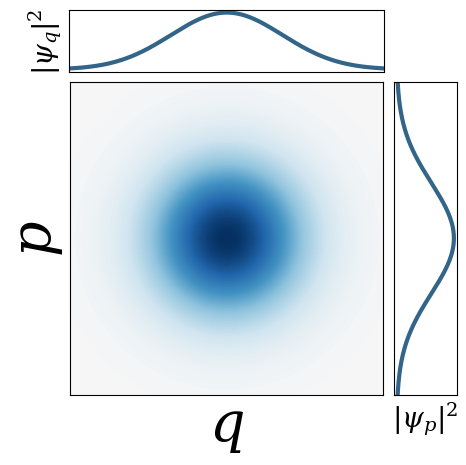

In [84]:
# Assuming W, xvec, and l are already defined
W = W_coherent
W2 = W_beta

row_marginal = np.sum(W, axis=0)*(xvec[1]-xvec[0])
column_marginal = np.sum(W, axis=1)*(xvec[1]-xvec[0])
row_marginal2 = np.sum(W2, axis=0)*(xvec[1]-xvec[0])
column_marginal2 = np.sum(W2, axis=1)*(xvec[1]-xvec[0])

# Normalize the color scale
nrm = mpl.colors.Normalize(-W.max(), W.max())

# Create the main plot and the marginal plots
fig = plt.figure(figsize=(5, 5))
fig.patch.set_facecolor(background_color)
gs = fig.add_gridspec(2, 2, width_ratios=(5, 1), height_ratios=(1, 5), hspace=0.05, wspace=0.05)
for ax in fig.get_axes():
    ax.set_facecolor(background_color)

# Main contour plot
ax_main = fig.add_subplot(gs[1, 0])
# contour = ax_main.contourf(xvec, xvec, W, 200, cmap=cm.RdBu, norm=nrm)
# contour = ax_main.contourf(xvec, xvec, W2, 200, cmap=cm.RdBu, norm=nrm)
im = ax_main.imshow(W, extent=[-3, 3, -3, 3], origin='lower', cmap=cm.RdBu, norm=nrm, interpolation='spline36')

ax_main.set_xlim(-2,2)
ax_main.set_ylim(-2,2)

# contour = ax_main.contourf(xvec/l, xvec/l, W, 100, cmap=cm.RdBu, norm=nrm)
ax_main.set_xlabel(r'$q$',fontsize=40)
ax_main.set_ylabel(r'$p$',fontsize=40)

# Row marginal plot
ax_row = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_row.plot(xvec, row_marginal, color=blue,ls='-',lw=3)
ax_row.set_ylabel(r'$|\psi_q|^2$',fontsize=20)
ax_row.xaxis.set_tick_params(labelbottom=False)
ax_row.set_xticks([])
ax_row.set_yticks([])


# Column marginal plot
ax_col = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_col.plot(column_marginal, xvec, color=blue,ls='-',lw=3)
ax_col.set_xlabel(r'$|\psi_p|^2$',fontsize=20)
ax_col.yaxis.set_tick_params(labelleft=False)
ax_col.set_xticks([])
ax_col.set_yticks([])



ax_main.set_xticks([])
ax_main.set_yticks([])
ax_main.set_aspect('equal')

plt.tight_layout()

name = 'coherent'
plt.savefig(path_posters+name+'.pdf',format='pdf',bbox_inches='tight',dpi=1000)
plt.show()

In [ ]:
# Assuming W, xvec, and l are already defined
W = W_coherent
W2 = W_beta

row_marginal = np.sum(W, axis=0)*(xvec[1]-xvec[0])
column_marginal = np.sum(W, axis=1)*(xvec[1]-xvec[0])
row_marginal2 = np.sum(W2, axis=0)*(xvec[1]-xvec[0])
column_marginal2 = np.sum(W2, axis=1)*(xvec[1]-xvec[0])

# Normalize the color scale
nrm = mpl.colors.Normalize(-W.max(), W.max())

# Create the main plot and the marginal plots
fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(2, 2, width_ratios=(5, 1), height_ratios=(1, 5), hspace=0.05, wspace=0.05)
fig.patch.set_facecolor(background_color)
for ax in fig.get_axes():
    ax.set_facecolor(background_color)
    
# Main contour plot
ax_main = fig.add_subplot(gs[1, 0])
# contour = ax_main.contourf(xvec, xvec, W, 200, cmap=cm.RdBu, norm=nrm)
# contour = ax_main.contourf(xvec, xvec, W2, 200, cmap=cm.RdBu, norm=nrm)
im = ax_main.imshow(W, extent=[-3, 3, -3, 3], origin='lower', cmap=cm.RdBu, norm=nrm, interpolation='spline36')
im2 = ax_main.imshow(W2, extent=[-3, 3, -3, 3], origin='lower', cmap=cm.RdBu, norm=nrm, interpolation='spline36')

ax_main.set_xlim(-2,2)
ax_main.set_ylim(-2,2)

# contour = ax_main.contourf(xvec/l, xvec/l, W, 100, cmap=cm.RdBu, norm=nrm)
ax_main.set_xlabel(r'$q$',fontsize=40)
ax_main.set_ylabel(r'$p$',fontsize=40)

row_style = dict(facecolor=lighten_color(red,.7), edgecolor=lighten_color(red,1.3), shrink=0.0,width=7, headwidth=20, headlength=10)

ax_main.annotate('', xy=(1/np.sqrt(2), 1/np.sqrt(2)), xytext=(0, 0), arrowprops=row_style)

# Row marginal plot
ax_row = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_row.plot(xvec, row_marginal, color=blue,ls=(1,(1,1)),lw=3)
ax_row.plot(xvec, row_marginal2, color=lighten_color(red,1),lw=3)
ax_row.set_ylabel(r'$|\psi_q|^2$',fontsize=20)
ax_row.xaxis.set_tick_params(labelbottom=False)
ax_row.set_xticks([])
ax_row.set_yticks([])

# Add arrow at the top of the Gaussians in the row marginal plot
row_max_idx = np.argmax(row_marginal)
row_max_idx2 = np.argmax(row_marginal2)
ax_row.annotate('', xy=(xvec[row_max_idx2], row_marginal2[row_max_idx2]), xytext=(xvec[row_max_idx], row_marginal[row_max_idx]),
                arrowprops=row_style)
ax_row.text(xvec[row_max_idx]+.5, row_marginal2[row_max_idx] + 0.53, r'$q_0$', fontsize=25, color=red, ha='center')


# Column marginal plot
ax_col = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_col.plot(column_marginal, xvec, color=blue,ls=(1,(1,1)),lw=3)
ax_col.plot(column_marginal2, xvec, color=red,lw=3)
ax_col.set_xlabel(r'$|\psi_p|^2$',fontsize=20)
ax_col.yaxis.set_tick_params(labelleft=False)
ax_col.set_xticks([])
ax_col.set_yticks([])

# Add arrow at the top of the Gaussians in the col marginal plot
col_max_idx = np.argmax(column_marginal)
col_max_idx2 = np.argmax(column_marginal2)
ax_col.annotate('', xy=(column_marginal2[col_max_idx2], xvec[col_max_idx2]), xytext=(column_marginal[col_max_idx], xvec[col_max_idx]),
                arrowprops=row_style)
ax_col.text(column_marginal2[col_max_idx] + .43, xvec[col_max_idx]+.5, r'$p_0$', fontsize=25, color=red, va='center')


ax_main.set_xticks([])
ax_main.set_yticks([])
ax_main.set_aspect('equal')

plt.tight_layout()

name = 'coherent_displacement'
plt.savefig(path_posters+name+'.pdf',format='pdf',bbox_inches='tight',dpi=1000)
plt.show()

/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_28652/1645168395.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


ValueError: 
\q_0
^
ParseFatalException: Unknown symbol: \q, found '\'  (at char 0), (line:1, col:1)

Error in callback <function _draw_all_if_interactive at 0x1307e3880> (for post_execute), with arguments args (),kwargs {}:


ValueError: 
\q_0
^
ParseFatalException: Unknown symbol: \q, found '\'  (at char 0), (line:1, col:1)

ValueError: 
\q_0
^
ParseFatalException: Unknown symbol: \q, found '\'  (at char 0), (line:1, col:1)

<Figure size 500x500 with 3 Axes>

/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_84236/3587829184.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


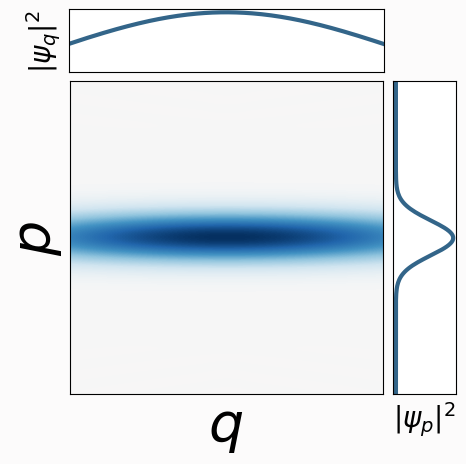

In [ ]:
# Assuming W, xvec, and l are already defined
W = W_q
W2 = W_q2

row_marginal = np.sum(W, axis=0)*(xvec[1]-xvec[0])
column_marginal = np.sum(W, axis=1)*(xvec[1]-xvec[0])
row_marginal2 = np.sum(W2, axis=0)*(xvec[1]-xvec[0])
column_marginal2 = np.sum(W2, axis=1)*(xvec[1]-xvec[0])

# Normalize the color scale
nrm = mpl.colors.Normalize(-W.max(), W.max())

# Create the main plot and the marginal plots
fig = plt.figure(figsize=(5, 5))
fig.patch.set_facecolor(background_color)
gs = fig.add_gridspec(2, 2, width_ratios=(5, 1), height_ratios=(1, 5), hspace=0.05, wspace=0.05)
for ax in fig.get_axes():
    ax.set_facecolor(background_color)

# Main contour plot
ax_main = fig.add_subplot(gs[1, 0])
# contour = ax_main.contourf(xvec, xvec, W, 200, cmap=cm.RdBu, norm=nrm)
# contour = ax_main.contourf(xvec, xvec, W2, 200, cmap=cm.RdBu, norm=nrm)
im = ax_main.imshow(W, extent=[-3, 3, -3, 3], origin='lower', cmap=cm.RdBu, norm=nrm, interpolation='spline36')

ax_main.set_xlim(-2,2)
ax_main.set_ylim(-2,2)

# contour = ax_main.contourf(xvec/l, xvec/l, W, 100, cmap=cm.RdBu, norm=nrm)
ax_main.set_xlabel(r'$q$',fontsize=40)
ax_main.set_ylabel(r'$p$',fontsize=40)

# Row marginal plot
ax_row = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_row.plot(xvec, row_marginal, color=blue,ls='-',lw=3)
ax_row.set_ylabel(r'$|\psi_q|^2$',fontsize=20)
ax_row.xaxis.set_tick_params(labelbottom=False)
ax_row.set_xticks([])
ax_row.set_yticks([])


# Column marginal plot
ax_col = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_col.plot(column_marginal, xvec, color=blue,ls='-',lw=3)
ax_col.set_xlabel(r'$|\psi_p|^2$',fontsize=20)
ax_col.yaxis.set_tick_params(labelleft=False)
ax_col.set_xticks([])
ax_col.set_yticks([])



ax_main.set_xticks([])
ax_main.set_yticks([])
ax_main.set_aspect('equal')

plt.tight_layout()

name = 'squeezed_q'
plt.savefig(path_posters+name+'.pdf',format='pdf',bbox_inches='tight',dpi=1000)
plt.show()

In [ ]:
# Assuming W, xvec, and l are already defined
W = W_q
W2 = W_q2

# row_marginal = np.sum(W, axis=0)*(xvec[1]-xvec[0])
# column_marginal = np.sum(W, axis=1)*(xvec[1]-xvec[0])
# row_marginal2 = np.sum(W2, axis=0)*(xvec[1]-xvec[0])
# column_marginal2 = np.sum(W2, axis=1)*(xvec[1]-xvec[0])

# Normalize the color scale
nrm = mpl.colors.Normalize(-W.max(), W.max())

# Create the main plot and the marginal plots
fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(2, 2, width_ratios=(5, 1), height_ratios=(1, 5), hspace=0.05, wspace=0.05)
fig.patch.set_facecolor(background_color)
for ax in fig.get_axes():
    ax.set_facecolor(background_color)
    
# Main contour plot
ax_main = fig.add_subplot(gs[1, 0])
# contour = ax_main.contourf(xvec, xvec, W, 200, cmap=cm.RdBu, norm=nrm)
# contour = ax_main.contourf(xvec, xvec, W2, 200, cmap=cm.RdBu, norm=nrm)
im = ax_main.imshow(W, extent=[-3, 3, -3, 3], origin='lower', cmap=cm.RdBu, norm=nrm, interpolation='spline36')
im2 = ax_main.imshow(W2, extent=[-3, 3, -3, 3], origin='lower', cmap=cm.RdBu, norm=nrm, interpolation='spline36')

ax_main.set_xlim(-2,2)
ax_main.set_ylim(-2,2)

# contour = ax_main.contourf(xvec/l, xvec/l, W, 100, cmap=cm.RdBu, norm=nrm)
ax_main.set_xlabel(r'$q$',fontsize=40)
ax_main.set_ylabel(r'$p$',fontsize=40)

row_style = dict(facecolor=lighten_color(red,.7), edgecolor=lighten_color(red,1.3), shrink=0.0,width=7, headwidth=20, headlength=10)

ax_main.annotate('', xy=(0, 1/np.sqrt(2)), xytext=(0, 0), arrowprops=row_style)

# Row marginal plot
ax_row = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_row.plot(xvec, row_marginal, color=blue,ls=(1,(1,1)),lw=3)
ax_row.plot(xvec, row_marginal2, color=lighten_color(red,1),lw=3)
ax_row.set_ylabel(r'$|\psi_q|^2$',fontsize=20)
ax_row.xaxis.set_tick_params(labelbottom=False)
ax_row.set_xticks([])
ax_row.set_yticks([])

# Add arrow at the top of the Gaussians in the row marginal plot
row_max_idx = np.argmax(row_marginal)
row_max_idx2 = np.argmax(row_marginal2)
# ax_row.annotate('', xy=(xvec[row_max_idx2], row_marginal2[row_max_idx2]), xytext=(xvec[row_max_idx], row_marginal[row_max_idx]),
#                 arrowprops=row_style)
# ax_row.text(xvec[row_max_idx]+.5, row_marginal2[row_max_idx] + 0.53, r'$\q_0$', fontsize=25, color=red, ha='center')


# Column marginal plot
ax_col = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_col.plot(column_marginal, xvec, color=blue,ls=(1,(1,1)),lw=3)
ax_col.plot(column_marginal2, xvec, color=red,lw=3)
ax_col.set_xlabel(r'$|\psi_p|^2$',fontsize=20)
ax_col.yaxis.set_tick_params(labelleft=False)
ax_col.set_xticks([])
ax_col.set_yticks([])

# Add arrow at the top of the Gaussians in the col marginal plot
col_max_idx = np.argmax(column_marginal)
col_max_idx2 = np.argmax(column_marginal2)
ax_col.annotate('', xy=(column_marginal2[col_max_idx2], xvec[col_max_idx2]), xytext=(column_marginal[col_max_idx], xvec[col_max_idx]),
                arrowprops=row_style)
ax_col.text(column_marginal2[col_max_idx] + 1.7, xvec[col_max_idx]+.3, r'$\p_0$', fontsize=25, color=red, va='center')


ax_main.set_xticks([])
ax_main.set_yticks([])
ax_main.set_aspect('equal')

plt.tight_layout()

name = 'squeezedq_displacement'
plt.savefig(path_posters+name+'.pdf',format='pdf',bbox_inches='tight',dpi=1000)
plt.show()

/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_84236/591022304.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


ValueError: 
\p_0
^
ParseFatalException: Unknown symbol: \p, found '\'  (at char 0), (line:1, col:1)

Error in callback <function _draw_all_if_interactive at 0x37e5e3910> (for post_execute), with arguments args (),kwargs {}:


ValueError: 
\p_0
^
ParseFatalException: Unknown symbol: \p, found '\'  (at char 0), (line:1, col:1)

ValueError: 
\p_0
^
ParseFatalException: Unknown symbol: \p, found '\'  (at char 0), (line:1, col:1)

<Figure size 500x500 with 3 Axes>

/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_84236/3049259236.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


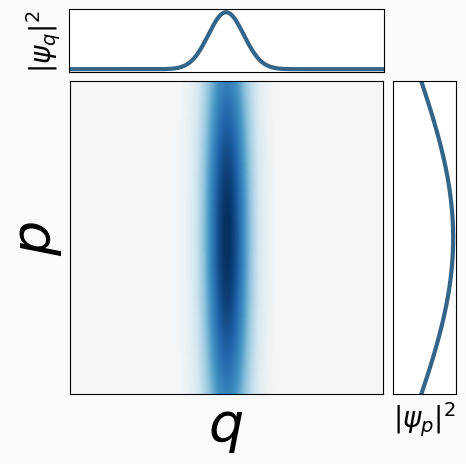

In [ ]:
# Assuming W, xvec, and l are already defined
W = W_p
W2 = W_p2

row_marginal = np.sum(W, axis=0)*(xvec[1]-xvec[0])
column_marginal = np.sum(W, axis=1)*(xvec[1]-xvec[0])
row_marginal2 = np.sum(W2, axis=0)*(xvec[1]-xvec[0])
column_marginal2 = np.sum(W2, axis=1)*(xvec[1]-xvec[0])

# Normalize the color scale
nrm = mpl.colors.Normalize(-W.max(), W.max())

# Create the main plot and the marginal plots
fig = plt.figure(figsize=(5, 5))
fig.patch.set_facecolor(background_color)
gs = fig.add_gridspec(2, 2, width_ratios=(5, 1), height_ratios=(1, 5), hspace=0.05, wspace=0.05)
for ax in fig.get_axes():
    ax.set_facecolor(background_color)

# Main contour plot
ax_main = fig.add_subplot(gs[1, 0])
# contour = ax_main.contourf(xvec, xvec, W, 200, cmap=cm.RdBu, norm=nrm)
# contour = ax_main.contourf(xvec, xvec, W2, 200, cmap=cm.RdBu, norm=nrm)
im = ax_main.imshow(W, extent=[-3, 3, -3, 3], origin='lower', cmap=cm.RdBu, norm=nrm, interpolation='spline36')

ax_main.set_xlim(-2,2)
ax_main.set_ylim(-2,2)

# contour = ax_main.contourf(xvec/l, xvec/l, W, 100, cmap=cm.RdBu, norm=nrm)
ax_main.set_xlabel(r'$q$',fontsize=40)
ax_main.set_ylabel(r'$p$',fontsize=40)

# Row marginal plot
ax_row = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_row.plot(xvec, row_marginal, color=blue,ls='-',lw=3)
ax_row.set_ylabel(r'$|\psi_q|^2$',fontsize=20)
ax_row.xaxis.set_tick_params(labelbottom=False)
ax_row.set_xticks([])
ax_row.set_yticks([])


# Column marginal plot
ax_col = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_col.plot(column_marginal, xvec, color=blue,ls='-',lw=3)
ax_col.set_xlabel(r'$|\psi_p|^2$',fontsize=20)
ax_col.yaxis.set_tick_params(labelleft=False)
ax_col.set_xticks([])
ax_col.set_yticks([])



ax_main.set_xticks([])
ax_main.set_yticks([])
ax_main.set_aspect('equal')

plt.tight_layout()

name = 'squeezed_p'
plt.savefig(path_posters+name+'.pdf',format='pdf',bbox_inches='tight',dpi=1000)
plt.show()

/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_84236/1032695360.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


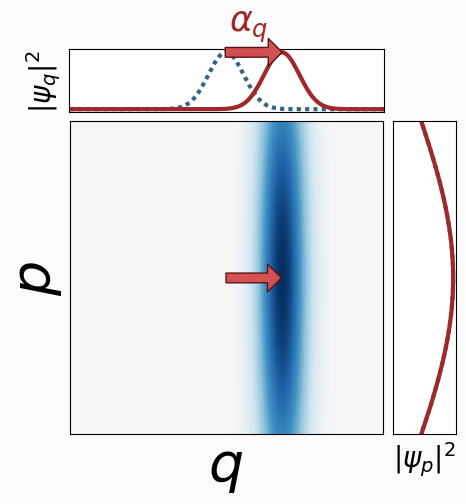

In [ ]:
# Assuming W, xvec, and l are already defined
W = W_p
W2 = W_p2

row_marginal = np.sum(W, axis=0)*(xvec[1]-xvec[0])
column_marginal = np.sum(W, axis=1)*(xvec[1]-xvec[0])
row_marginal2 = np.sum(W2, axis=0)*(xvec[1]-xvec[0])
column_marginal2 = np.sum(W2, axis=1)*(xvec[1]-xvec[0])

# Normalize the color scale
nrm = mpl.colors.Normalize(-W.max(), W.max())

# Create the main plot and the marginal plots
fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(2, 2, width_ratios=(5, 1), height_ratios=(1, 5), hspace=0.05, wspace=0.05)
fig.patch.set_facecolor(background_color)
for ax in fig.get_axes():
    ax.set_facecolor(background_color)
    
# Main contour plot
ax_main = fig.add_subplot(gs[1, 0])
# contour = ax_main.contourf(xvec, xvec, W, 200, cmap=cm.RdBu, norm=nrm)
# contour = ax_main.contourf(xvec, xvec, W2, 200, cmap=cm.RdBu, norm=nrm)
im = ax_main.imshow(W, extent=[-3, 3, -3, 3], origin='lower', cmap=cm.RdBu, norm=nrm, interpolation='spline36')
im2 = ax_main.imshow(W2, extent=[-3, 3, -3, 3], origin='lower', cmap=cm.RdBu, norm=nrm, interpolation='spline36')

ax_main.set_xlim(-2,2)
ax_main.set_ylim(-2,2)

# contour = ax_main.contourf(xvec/l, xvec/l, W, 100, cmap=cm.RdBu, norm=nrm)
ax_main.set_xlabel(r'$q$',fontsize=40)
ax_main.set_ylabel(r'$p$',fontsize=40)

row_style = dict(facecolor=lighten_color(red,.7), edgecolor=lighten_color(red,1.3), shrink=0.0,width=7, headwidth=20, headlength=10)

ax_main.annotate('', xy=(1/np.sqrt(2), 0), xytext=(0, 0), arrowprops=row_style)

# Row marginal plot
ax_row = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_row.plot(xvec, row_marginal, color=blue,ls=(1,(1,1)),lw=3)
ax_row.plot(xvec, row_marginal2, color=lighten_color(red,1),lw=3)
ax_row.set_ylabel(r'$|\psi_q|^2$',fontsize=20)
ax_row.xaxis.set_tick_params(labelbottom=False)
ax_row.set_xticks([])
ax_row.set_yticks([])

# Add arrow at the top of the Gaussians in the row marginal plot
row_max_idx = np.argmax(row_marginal)
row_max_idx2 = np.argmax(row_marginal2)
ax_row.annotate('', xy=(xvec[row_max_idx2], row_marginal2[row_max_idx2]), xytext=(xvec[row_max_idx], row_marginal[row_max_idx]),
                arrowprops=row_style)
ax_row.text(xvec[row_max_idx]+.3, row_marginal2[row_max_idx] + 2, r'$\q_0$', fontsize=25, color=red, ha='center')


# Column marginal plot
ax_col = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_col.plot(column_marginal, xvec, color=blue,ls=(1,(1,1)),lw=3)
ax_col.plot(column_marginal2, xvec, color=red,lw=3)
ax_col.set_xlabel(r'$|\psi_p|^2$',fontsize=20)
ax_col.yaxis.set_tick_params(labelleft=False)
ax_col.set_xticks([])
ax_col.set_yticks([])

# Add arrow at the top of the Gaussians in the col marginal plot
col_max_idx = np.argmax(column_marginal)
col_max_idx2 = np.argmax(column_marginal2)
# ax_col.annotate('', xy=(column_marginal2[col_max_idx2], xvec[col_max_idx2]), xytext=(column_marginal[col_max_idx], xvec[col_max_idx]),
#                 arrowprops=row_style)
# ax_col.text(column_marginal2[col_max_idx] + .43, xvec[col_max_idx]+.5, r'$\p_0$', fontsize=25, color=red, va='center')


ax_main.set_xticks([])
ax_main.set_yticks([])
ax_main.set_aspect('equal')

plt.tight_layout()

name = 'squeezedp_displacement'
plt.savefig(path_posters+name+'.pdf',format='pdf',bbox_inches='tight',dpi=1000)
plt.show()

### arrow

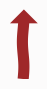

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import matplotlib.path as mpath

# Create a figure and axis
fig, ax = plt.subplots(figsize=(1, 1))
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)
# Define the wiggly path using a sine function
y = (5/2)*1/6
x = np.linspace(0, y, 2000)
y = 0.005 * np.sin(6*np.pi * x)   # Adjust the amplitude and frequency of the sine function

# Create the path data
Path = mpath.Path
path_data = [(Path.MOVETO, (0.5, 0))]
path_data += [(Path.LINETO, (0.5 + y[i], x[i])) for i in range(len(x))]
codes, verts = zip(*path_data)
path = mpath.Path(verts, codes)

# Create the wiggly arrow
line = patches.PathPatch(path, color=red, lw=8)
# Add the arrowhead at the end of the path
ax.annotate('', xy=(0.505, .47), xytext=(0.505, .41),
            arrowprops=dict(facecolor=red, edgecolor='none', shrink=0.05, width=5, headwidth=20, headlength=10))

# arrow = patches.FancyArrowPatch(path=path, arrowstyle='-|>', mutation_scale=20, color='black',lw=10)

# Add the arrow to the plot
ax.add_patch(line)

# Set the limits and aspect ratio
ax.set_xlim(0.45, .55)
ax.set_ylim(0, .47)
ax.set_aspect('equal')

# Remove the axes
ax.axis('off')

# Show the plot

plt.tight_layout()
name='wiggly_arrow'
plt.savefig(path_posters+name+'.pdf',format='pdf',bbox_inches='tight',dpi=1000)

plt.show()

### sBs boxes

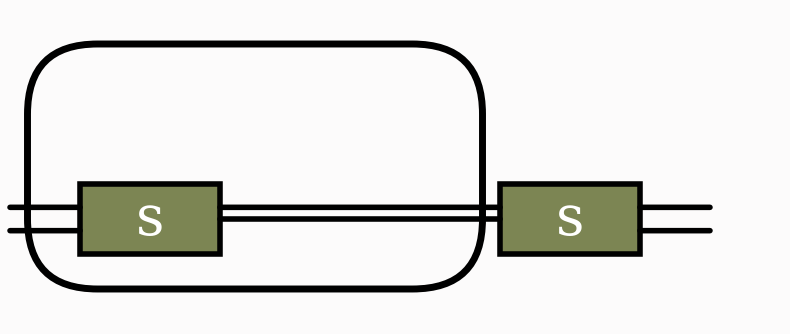

In [61]:
import matplotlib.patches as patches

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))
background_color = (252/255, 251/255, 251/255)
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

# Define the positions and sizes of the boxes
box1_pos = (0.2, 0.4)
box2_pos = (0.8, 0.4)
box_width = 0.2
box_height = 0.1

# Add the boxes
box1 = patches.Rectangle(box1_pos, box_width, box_height, linewidth=4, edgecolor='black', facecolor=lighten_color(green,1.2))
box2 = patches.Rectangle(box2_pos, box_width, box_height, linewidth=4, edgecolor='black', facecolor=lighten_color(green,1.2))
ax.add_patch(box1)
ax.add_patch(box2)

# Add the connecting lines
line1 = patches.ConnectionPatch((box1_pos[0] + box_width, box1_pos[1] + box_height / 2),
                                (box2_pos[0], box2_pos[1] + box_height / 2), 'data', 'data', linewidth=4, color='black')
line2 = patches.ConnectionPatch((box1_pos[0] + box_width, box1_pos[1] + 2 * box_height / 3 ),
                                (box2_pos[0], box2_pos[1] + 2 * box_height / 3 ), 'data', 'data', linewidth=4, color='black')
ax.add_patch(line1)
ax.add_patch(line2)

# Add the lines coming out of the opposite sides
line3 = patches.ConnectionPatch((box1_pos[0], box1_pos[1] + 2 * box_height / 3),
                                (box1_pos[0] - 0.1, box1_pos[1] + 2 * box_height / 3), 'data', 'data', linewidth=4, color='black')
line4 = patches.ConnectionPatch((box1_pos[0], box1_pos[1] + box_height / 3 ),
                                (box1_pos[0] - 0.1, box1_pos[1] + box_height / 3), 'data', 'data', linewidth=4, color='black')
line5 = patches.ConnectionPatch((box2_pos[0] + box_width, box2_pos[1] + box_height / 3),
                                (box2_pos[0] + box_width + 0.1, box2_pos[1] + box_height / 3), 'data', 'data', linewidth=4, color='black')
line6 = patches.ConnectionPatch((box2_pos[0] + box_width, box2_pos[1] + 2  * box_height / 3),
                                (box2_pos[0] + box_width + 0.1, box2_pos[1] + 2 * box_height / 3 ), 'data', 'data', linewidth=4, color='black')
ax.add_patch(line3)
ax.add_patch(line4)
ax.add_patch(line5)
ax.add_patch(line6)

# Add the elegant parenthesis
parenthesis = patches.FancyBboxPatch((0.225, 0.45), 0.45, 0.15, boxstyle="round,pad=0.1", linewidth=5, edgecolor='black', facecolor='none')
ax.add_patch(parenthesis)

# Add textbox 
# ax.text(.45, .75, f'small Big small', fontsize=15,
#              va='center', ha='center', bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))

        
# Add text inside the boxes
ax.text(box1_pos[0] + box_width / 2, box1_pos[1] + box_height / 2, r's', fontsize=40, color='white', ha='center', va='center')
ax.text(box2_pos[0] + box_width / 2, box2_pos[1] + box_height / 2, r's', fontsize=40, color='white', ha='center', va='center')


# Set the limits and aspect ratio
ax.set_xlim(0.1, 1.2)
ax.set_ylim(0.3, .75)
ax.set_aspect('equal')

# Remove the axes
ax.axis('off')
plt.tight_layout()

name = 'sBs-box'
fig.savefig(path_posters+name+'.pdf',format='pdf',bbox_inches='tight',dpi=1000)
# Show the plot
plt.show()

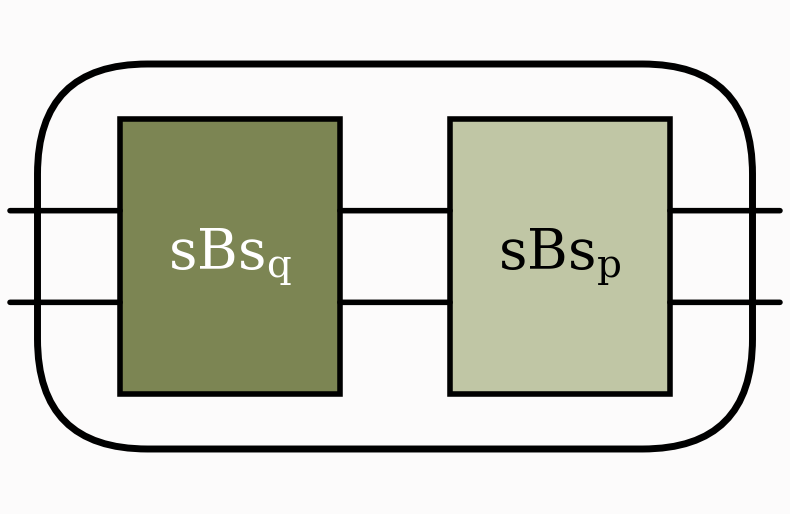

In [53]:
import matplotlib.patches as patches

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))
background_color = (252/255, 251/255, 251/255)
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

# Define the positions and sizes of the boxes
box1_pos = (0.2, 0.4)
box2_pos = (0.5, 0.4)
box_width = 0.2
box_height = 0.25

# Add the boxes
box1 = patches.Rectangle(box1_pos, box_width, box_height, linewidth=4, edgecolor='black', facecolor=lighten_color(green,1.2))
box2 = patches.Rectangle(box2_pos, box_width, box_height, linewidth=4, edgecolor='black', facecolor=lighten_color(green,.6))
ax.add_patch(box1)
ax.add_patch(box2)

# Add the connecting lines
line1 = patches.ConnectionPatch((box1_pos[0] + box_width, box1_pos[1] + box_height / 3),
                                (box2_pos[0], box2_pos[1] + box_height / 3), 'data', 'data', linewidth=4, color='black')
line2 = patches.ConnectionPatch((box1_pos[0] + box_width, box1_pos[1] + 2 * box_height / 3 ),
                                (box2_pos[0], box2_pos[1] + 2 * box_height / 3 ), 'data', 'data', linewidth=4, color='black')
ax.add_patch(line1)
ax.add_patch(line2)

# Add the lines coming out of the opposite sides
line3 = patches.ConnectionPatch((box1_pos[0], box1_pos[1] + 2 * box_height / 3),
                                (box1_pos[0] - 0.1, box1_pos[1] + 2 * box_height / 3), 'data', 'data', linewidth=4, color='black')
line4 = patches.ConnectionPatch((box1_pos[0], box1_pos[1] + box_height / 3 ),
                                (box1_pos[0] - 0.1, box1_pos[1] + box_height / 3), 'data', 'data', linewidth=4, color='black')
line5 = patches.ConnectionPatch((box2_pos[0] + box_width, box2_pos[1] + box_height / 3),
                                (box2_pos[0] + box_width + 0.1, box2_pos[1] + box_height / 3), 'data', 'data', linewidth=4, color='black')
line6 = patches.ConnectionPatch((box2_pos[0] + box_width, box2_pos[1] + 2  * box_height / 3),
                                (box2_pos[0] + box_width + 0.1, box2_pos[1] + 2 * box_height / 3 ), 'data', 'data', linewidth=4, color='black')
ax.add_patch(line3)
ax.add_patch(line4)
ax.add_patch(line5)
ax.add_patch(line6)

# Add the elegant parenthesis
parenthesis = patches.FancyBboxPatch((0.225, 0.45), 0.45, 0.15, boxstyle="round,pad=0.1", linewidth=5, edgecolor='black', facecolor='none')
ax.add_patch(parenthesis)

# Add textbox 
# ax.text(.45, .75, f'small Big small', fontsize=15,
#              va='center', ha='center', bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))

        
# Add text inside the boxes
ax.text(box1_pos[0] + box_width / 2, box1_pos[1] + box_height / 2, r'sBs$_{\text{q}}$', fontsize=40, color='white', ha='center', va='center')
ax.text(box2_pos[0] + box_width / 2, box2_pos[1] + box_height / 2, r'sBs$_{\text{p}}$', fontsize=40, color='black', ha='center', va='center')


# Set the limits and aspect ratio
ax.set_xlim(0.1, .8)
ax.set_ylim(0.3, .75)
ax.set_aspect('equal')

# Remove the axes
ax.axis('off')
plt.tight_layout()

name = 'sBs-box-Lindblad'
fig.savefig(path_posters+name+'.pdf',format='pdf',bbox_inches='tight',dpi=1000)
# Show the plot
plt.show()

### sensitivity

sensor n 2.214126136076655
QFI-r: 1.1923821987654717 dB-QFI: 10.356900184870215 gain-QFI: 3.2371538057082314
1 0.0
squeezing parameter r: 0.8479862570754632 gain: 1.9088415612431848 dB: 7.36551504355332
squeezing parameter rmin: 1.3819098331424653 dB: 12.003116300432325
average MSE 0.20828804972033654 18536.14939806704
2 0.0
squeezing parameter r: 1.042193204029787 gain: 2.541010079170868 dB: 9.052375151744128
squeezing parameter rmin: 1.410118182091931 dB: 12.24813090627941
average MSE 0.13046059127704512 0.20382763152130182
4 0.0
squeezing parameter r: 1.1496945012374873 gain: 3.0171025589396407 dB: 9.986119555239041
squeezing parameter rmin: 1.4328834140138869 dB: 12.445867198338474
average MSE 0.0819120841466454 0.1285374209434644
10 0.0
squeezing parameter r: 1.1609965480222049 gain: 3.0735133846937734 dB: 10.084287886295346
squeezing parameter rmin: 1.4500017935146827 dB: 12.5945555534649
average MSE 0.07983859765936512 0.10150891223456324


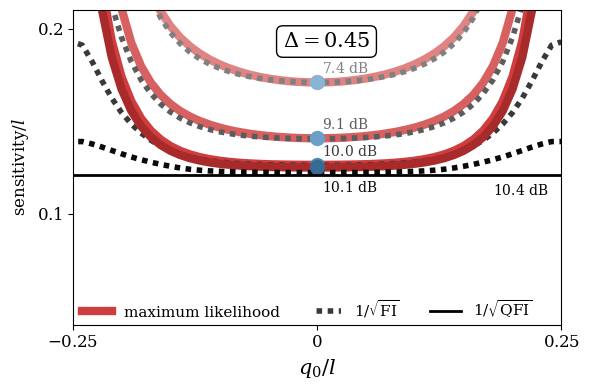

In [51]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['DejaVu Serif'],
    'mathtext.fontset': 'dejavuserif'
})
Delta = .45
cd = np.cosh(Delta**2)
fig, ax2 = plt.subplots(1,1,figsize=(6,4),sharex=True)
R1, k, steps, l = 10, 0, 51, np.sqrt(2*np.pi)
q0_range = (l/4)*np.linspace(-1.0,1.0,steps)
T_range = [1,2,4,10]

name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,120)
sensor = sps.load_npz(path_data_sBs_sensor+name)
n = (n_op@sensor).diagonal().sum()
QFI = np.real(1/(4*n+2))
print('sensor n',np.real(n))
print('QFI-r:',np.real(r_QFI),'dB-QFI:',dB_QFI, 'gain-QFI:',gain_QFI)
for T in T_range:
    
    name = 'data-noiseless-sensitivity-fullqmap-delta={0:.2f}-T={1:.0f}'.format(Delta,T)
    with open(path_sBs_MP_ML+name+'.pkl', 'rb') as file:
        dictionary = pickle.load(file)
    MSE = dictionary['MSE']
    biases = dictionary['biases']
    partial_means = dictionary['partial_means']
    FIqT = dictionary['FIqT']

    # ax1.plot(q0_range/l,MSE-biases**2,ls='-',color=lighten_color(red,.7),lw=2)
    # ax1.plot(q0_range/l, np.sqrt(1/FIqT)/l,color=lighten_color('black',shine),lw=3,ls='--')
    shine = .5+.2*np.log(T)

    # ax2.plot(q0_range/l, Var/partial_means**2,color=blue,lw=3)
    sensitivity = np.sqrt(MSE/partial_means**2)
    if T==4:
        ax2.plot(q0_range/l, sensitivity/l,color=lighten_color(red,shine),lw=6,label='maximum likelihood')
        ax2.plot(q0_range/l, np.sqrt(1/FIqT)/l,color=lighten_color('black',shine),lw=4,ls=(1,(1,1)),label=r'1/$\sqrt{\text{FI}}$')
    else:
        ax2.plot(q0_range/l, sensitivity/l,color=lighten_color(red,shine),lw=6)
        ax2.plot(q0_range/l, np.sqrt(1/FIqT)/l,color=lighten_color('black',shine),lw=4,ls=(1,(1,1)))
    print(T,q0_range[np.argmin(MSE/partial_means**2)]/l)


    rs = np.log(1/np.min(sensitivity))
    gains = np.cosh(rs)**2
    dBs = 10*np.log10(np.exp(2*rs))
    rmin = np.log(1/np.sqrt(np.min(MSE)))
    print('squeezing parameter r:',rs, 'gain:',gains, 'dB:',10*np.log10(np.exp(2*rs)))
    print('squeezing parameter rmin:',rmin,'dB:',10*np.log10(np.exp(2*rmin)))
    if T==10:
        ax2.text(q0_range[np.argmin(sensitivity)]/l+.005,sensitivity[np.argmin(sensitivity)]/l-.013,r'${0:.1f}$ dB'.format(dBs),fontsize=10,color=lighten_color('black',shine))
        ax2.plot(q0_range[np.argmin(sensitivity)]/l,sensitivity[np.argmin(sensitivity)]/l,'o',color=lighten_color(blue,shine),markersize=10)

    else:
        ax2.text(q0_range[np.argmin(sensitivity)]/l+.005,sensitivity[np.argmin(sensitivity)]/l+.005,r'${0:.1f}$ dB'.format(dBs),fontsize=10,color=lighten_color('black',shine))
        ax2.plot(q0_range[np.argmin(sensitivity)]/l,sensitivity[np.argmin(sensitivity)]/l,'o',color=lighten_color(blue,shine),markersize=10)

    print('average MSE',np.mean(MSE),np.mean(1/FIqT))

ax2.plot([-1,1],[np.sqrt(QFI)/l,np.sqrt(QFI)/l],color=lighten_color('black',1),lw=2,ls='-',label=r'1/$\sqrt{\text{QFI}}$')
r_QFI = np.log(1/np.sqrt(QFI))
dB_QFI = 10*np.log10(np.exp(2*r_QFI))
gain_QFI = np.cosh(r_QFI)**2
ax2.text(0.18,.11,r'${0:.1f}$ dB'.format(dB_QFI),fontsize=10,color=lighten_color('black',1))

# Add textbox with the value of delta
ax2.text(0.43, 0.93, f'$\Delta = {Delta}$', transform=ax2.transAxes, fontsize=15,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))

        

ax2.set_ylim(0.04,.21)
ax2.set_xlim(-.25,.25)
xticks = [-1/4,0,1/4]
xlabels = [r'$-0.25$',r'$0$',r'$0.25$']
ax2.set_xticks(xticks)
ax2.set_xticklabels(xlabels,fontsize=12)
ax2.set_xlabel(r'$q_0/l$',fontsize=15)
y2ticks = [.1,.2]
y2labels = [r'$0.1$',r'$0.2$']
ax2.set_yticks(y2ticks)
ax2.set_yticklabels(y2labels,fontsize=12)
ax2.set_ylabel(r'$\text{sensitivity}/l$',fontsize=12)
ax2.legend(fontsize=11,loc='lower left',framealpha=0,bbox_to_anchor=(-0.01,-0.03),ncol=3)

plt.tight_layout()
name = 'sensitivity-delta={0:.2f}'.format(Delta)
fig.savefig(path_posters+name+'.pdf',bbox_inches='tight',dpi=1000)